In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [2]:
def histogram(df, column, bins, title, x_label, y_label ):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column, bins=bins, kde=False)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()

In [3]:
def line_chart(df, column, title, x_label, y_label, rotation):
    grouped = df.groupby(column).size().reset_index(name='count')
    
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    sns.lineplot(data=grouped, x=column, y='count')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

In [4]:
def line_chart_groupby(df, groupby_cols, y_fields, agg_method='count', hue=None, title='Line Chart', x_label='', y_label='', marker=None,legend_title=None, rotation=0):
    if agg_method == 'count':
        if hue:
            grouped = df.groupby([groupby_cols,hue]).size().reset_index(name='count')
            value_cols = 'count'
        else:
            grouped = df.groupby(groupby_cols).size().reset_index(name='count')
            value_cols = 'count'
    elif agg_method == 'nunique':
        if hue:
            grouped = df.groupby([groupby_cols,hue]).nunique().reset_index()
            value_cols = y_fields
        else:
            grouped = df.groupby(groupby_cols).nunique().reset_index()
            value_cols = y_fields
    elif agg_method == 'sum':
        if hue:
            grouped = df.groupby([groupby_cols,hue])[y_fields].sum().reset_index()
            value_cols = y_fields
        else:
            grouped = df.groupby(groupby_cols)[y_fields].sum().reset_index()
            value_cols = y_fields
    else:
        raise ValueError("Invalid aggregation method.")

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    sns.lineplot(data=grouped, x=groupby_cols, y=y_fields,hue=hue,marker=marker)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=rotation)
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [5]:
def stacked_bar(df, column_x, column_y, title, x_label, y_label, colormap, rotation, legend):
    grouped = df.groupby([column_x, column_y]).size().reset_index(name='count')
    grouped[column_x] = pd.to_datetime(grouped[column_x]).dt.date
    
    grouped_pivot = grouped.pivot(index=column_x, columns=column_y, values='count').fillna(0)
    grouped_pivot.plot(kind='bar', stacked=True, figsize=(14, 6), colormap=colormap)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=90)
    plt.legend(title= legend, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [6]:
def heat_map(df, column_x, column_y,value_col, title, x_label, y_label, colormap, rotation):
    grouped = df.groupby([column_x, column_y])[value_col].sum().reset_index()
    pivot = grouped.pivot(index=column_y, columns=column_x, values=value_col).fillna(0)

    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot, cmap=colormap, linewidths=0.5, annot=True, fmt='.0f')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

In [7]:
def bar_chart_month(df, date_col, value_col, title, x_label, y_label, rotation):
    grouped = df.groupby(date_col)[value_col].sum().reset_index()
    grouped = grouped.sort_values(date_col)

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    sns.barplot(data=grouped, x=date_col, y=value_col)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

In [8]:
def bar_chart_category(df, category, title, x_label, y1_label, y2_label, rotation, qty_col='PROD_QTY', sales_col='TOT_SALES'):
    grouped = df.groupby(category).agg({
        qty_col: 'sum',
        sales_col: 'sum'
    }).reset_index().sort_values(by=qty_col, ascending=False)

    fig, ax1 = plt.subplots(figsize=(16, 6))
    sns.set(style="whitegrid")

    sns.barplot(data=grouped, x=category, y=qty_col, palette='Blues_d', ax=ax1)
    ax1.set_ylabel(y1_label, color='blue')
    ax1.set_xlabel(x_label)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.tick_params(axis='x', rotation=rotation)
    ax1.set_title(title)

    ax2 = ax1.twinx()
    sns.lineplot(data=grouped, x=category, y=sales_col, color='red', marker='o', ax=ax2)
    ax2.set_ylabel(y2_label, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.tight_layout()
    plt.show()

In [9]:
def mode_percent(series):
    mode_val = series.mode().iloc[0] if not series.mode().empty else None
    mode_count = (series == mode_val).sum()
    percentage = round((mode_count / len(series)) * 100, 2) if len(series) > 0 else 0
    return mode_val, percentage

In [10]:
def brand_summary(df,mode_percent):
    brands, total_sales, qty_ordered, transactions, avg_sales, avg_quantity, life_stage, life_stage_pct, cust_seg, cust_seg_pct,flavour, flavour_pct, prod_type, prod_type_pct, pack_size, pack_size_pct = ([] for _ in range(16))

    for brand, group in df.groupby('Brand Name'):
        brands.append(brand)
        total_sales.append(group['TOT_SALES'].sum())
        qty_ordered.append(group['PROD_QTY'].sum())
        avg_sales.append(group['TOT_SALES'].mean())
        avg_quantity.append(group['PROD_QTY'].mean())
        transactions.append(len(group))

        l, lp = mode_percent(group['LIFESTAGE'])
        life_stage.append(l)
        life_stage_pct.append(lp)

        cs, cp = mode_percent(group['PREMIUM_CUSTOMER'])
        cust_seg.append(cs)
        cust_seg_pct.append(cp)

        f, fp = mode_percent(group['L2 Flavour'])
        flavour.append(f)
        flavour_pct.append(fp)

        pt, ptp = mode_percent(group['L2 Product Type'])
        prod_type.append(pt)
        prod_type_pct.append(ptp)

        ps, psp = mode_percent(group['Packet Size'])
        pack_size.append(ps)
        pack_size_pct.append(psp)

    brand_summary = pd.DataFrame({
        'Brand Name': brands,
        'Total Sales ($)': total_sales,
        'Quantity Ordered': qty_ordered,
        'Total Transactions': transactions,
        'Average Sales ($)': avg_sales,
        'Average Quantity': avg_quantity,
        'Lifestage (Most Ordered)': life_stage,
        'Lifestage (%)': life_stage_pct,
        'Customer Segment (Most Ordered)': cust_seg,
        'Customer Segment (%)': cust_seg_pct,
        'Flavour (Most Ordered)': flavour,
        'Flavour (%)': flavour_pct,
        'Product Type (Most Ordered)': prod_type,
        'Product Type (%)': prod_type_pct,
        'Packet Size (Most Ordered)': pack_size,
        'Packet Size (%)': pack_size_pct
    })

    brand_summary['Total Sales ($)'] = brand_summary['Total Sales ($)'].round(0)
    brand_summary['Average Sales ($)'] = brand_summary['Average Sales ($)'].round(0)
    brand_summary['Average Quantity'] = brand_summary['Average Quantity'].round(0)
    brand_summary['Lifestage (%)'] = brand_summary['Lifestage (%)'].round(0)
    brand_summary['Customer Segment (%)'] = brand_summary['Customer Segment (%)'].round(0)
    brand_summary['Flavour (%)'] = brand_summary['Flavour (%)'].round(0)
    brand_summary['Product Type (%)'] = brand_summary['Product Type (%)'].round(0)
                                                                                          
    brand_summary = brand_summary.sort_values(by='Total Sales ($)', ascending=False).reset_index(drop=True)
    return brand_summary

In [11]:
def customer_behavior_dashboard(df):
    sns.set(style='whitegrid')
    fig, axes = plt.subplots(6, 1, figsize=(24, 48))
    fig.suptitle("Customer Purchasing Behavior by Brand", fontsize=24, fontweight='bold')

    # Total Sales per Brand
    sns.barplot(data=df, x='Brand Name', y='Total Sales ($)', palette='viridis', ax=axes[0])
    axes[0].set_title("Total Sales by Brand", fontsize=18)
    axes[0].set_xlabel("Brand")
    axes[0].set_ylabel("Sales ($)")
    axes[0].tick_params(axis='x', rotation=45)

    # Average Spend per Transaction
    df['Avg Spend per Transaction'] = df['Total Sales ($)'] / df['Total Transactions']
    sns.barplot(data=df, x='Brand Name', y='Avg Spend per Transaction', palette='coolwarm', ax=axes[1])
    axes[1].set_title("Avg Spend per Transaction", fontsize=18)
    axes[1].set_xlabel("Brand")
    axes[1].set_ylabel("Spend ($)")
    axes[1].tick_params(axis='x', rotation=45)

    # Dominant Customer Lifestage
    sns.barplot(data=df, x='Brand Name', y='Lifestage (%)',
                hue='Lifestage (Most Ordered)', dodge=False, ax=axes[2])
    axes[2].set_title("Lifestage with Most Orders", fontsize=18)
    axes[2].set_xlabel("Brand")
    axes[2].set_ylabel("Lifestage Share (%)")
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].legend(title='Lifestage', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Dominant Customer Segment
    sns.barplot(data=df, x='Brand Name', y='Customer Segment (%)',
                hue='Customer Segment (Most Ordered)', dodge=False, ax=axes[3])
    axes[3].set_title("Customer Segment with Most Orders", fontsize=18)
    axes[3].set_xlabel("Brand")
    axes[3].set_ylabel("Segment Share (%)")
    axes[3].tick_params(axis='x', rotation=45)
    axes[3].legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Most Ordered Packet Size
    sns.barplot(data=df, x='Brand Name', y='Packet Size (%)',
                hue='Packet Size (Most Ordered)', dodge=False, ax=axes[4])
    axes[4].set_title("Most Ordered Packet Size", fontsize=18)
    axes[4].set_xlabel("Brand")
    axes[4].set_ylabel("Packet Size Share (%)")
    axes[4].tick_params(axis='x', rotation=45)
    axes[4].legend(title='Packet Size', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Most Ordered Flavor
    sns.barplot(data=df, x='Brand Name', y='Flavour (%)',
                hue='Flavour (Most Ordered)', dodge=False, ax=axes[5])
    axes[5].set_title("Most Ordered Flavor", fontsize=18)
    axes[5].set_xlabel("Brand")
    axes[5].set_ylabel("Flavor Share (%)")
    axes[5].tick_params(axis='x', rotation=45)
    axes[5].legend(title='Flavor', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Customer Purchasing Behaviour

## Data Pre-processing

### Transaction Data

In [12]:
df1 = pd.read_excel("Data/QVI_transaction_data.xlsx")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [13]:
# data formatting
df1['DATE'] = pd.to_datetime(df1['DATE'], origin='1899-12-30', unit='D')
df1['STORE_NBR'] = df1['STORE_NBR'].astype(str)
df1['LYLTY_CARD_NBR'] = df1['LYLTY_CARD_NBR'].astype(str)
df1['TXN_ID'] = df1['TXN_ID'].astype(str)
df1['PROD_NBR'] = df1['PROD_NBR'].astype(str)

In [14]:
df1.head()

DATE STORE_NBR LYLTY_CARD_NBR TXN_ID PROD_NBR  \
0 2018-10-17         1           1000      1        5   
1 2019-05-14         1           1307    348       66   
2 2019-05-20         1           1343    383       61   
3 2018-08-17         2           2373    974       69   
4 2018-08-18         2           2426   1038      108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8

### Purchasing Behaviour

In [15]:
df2 = pd.read_csv("Data/QVI_purchase_behaviour.csv")
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
df2['LYLTY_CARD_NBR'] = df2['LYLTY_CARD_NBR'].astype(str)
df2.head()

LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0           1000   YOUNG SINGLES/COUPLES          Premium
1           1002   YOUNG SINGLES/COUPLES       Mainstream
2           1003          YOUNG FAMILIES           Budget
3           1004   OLDER SINGLES/COUPLES       Mainstream
4           1005  MIDAGE SINGLES/COUPLES       Mainstream

### Missing & Unique values detection

In [17]:
# Missing values detection
print("Transaction Data (Missing Values):")
print(df1.isnull().sum().to_dict())
print("\nPurchase Behaviour (Missing Values):")
print(df2.isnull().sum().to_dict())

Transaction Data (Missing Values):
{'DATE': 0, 'STORE_NBR': 0, 'LYLTY_CARD_NBR': 0, 'TXN_ID': 0, 'PROD_NBR': 0, 'PROD_NAME': 0, 'PROD_QTY': 0, 'TOT_SALES': 0}

Purchase Behaviour (Missing Values):
{'LYLTY_CARD_NBR': 0, 'LIFESTAGE': 0, 'PREMIUM_CUSTOMER': 0}


In [18]:
# Unique values detection
print("Transaction Data (Unique Values):")
print(df1.nunique().to_dict())
print("\nPurchase Behaviour (Unique Values):")
print(df2.nunique().to_dict())

Transaction Data (Unique Values):
{'DATE': 364, 'STORE_NBR': 272, 'LYLTY_CARD_NBR': 72637, 'TXN_ID': 263127, 'PROD_NBR': 114, 'PROD_NAME': 114, 'PROD_QTY': 6, 'TOT_SALES': 112}

Purchase Behaviour (Unique Values):
{'LYLTY_CARD_NBR': 72637, 'LIFESTAGE': 7, 'PREMIUM_CUSTOMER': 3}


### Deduplication

In [19]:
# Duplicate events detection using TXN_ID field
duplicate = df1[df1.duplicated(subset='TXN_ID')]
duplicate.shape

(1709, 8)

In [20]:
duplicate.head()

DATE STORE_NBR LYLTY_CARD_NBR TXN_ID PROD_NBR  \
42  2019-05-20        55          55073  48887      113   
377 2019-01-10         7           7364   7739       20   
419 2018-10-18        12          12301  10982       93   
476 2018-09-08        16          16427  14546       81   
511 2018-08-03        19          19272  16683       31   

                                   PROD_NAME  PROD_QTY  TOT_SALES  
42                      Twisties Chicken270g         1        4.6  
377         Doritos Cheese      Supreme 330g         2       11.4  
419  Doritos Corn Chip Southern Chicken 150g         2        7.8  
476          Pringles Original   Crisps 134g         1        3.7  
511   Infzns Crn Crnchers Tangy Gcamole 110g         2        7.6

In [21]:
similar_events = df1[df1['TXN_ID']=='108462']
similar_events.head()

DATE STORE_NBR LYLTY_CARD_NBR  TXN_ID PROD_NBR  \
124843 2018-10-01       107         107024  108462       45   
124844 2018-10-01       107         107024  108462       18   
124845 2018-10-01       107         107024  108462       45   

                                     PROD_NAME  PROD_QTY  TOT_SALES  
124843  Smiths Thinly Cut   Roast Chicken 175g         2        6.0  
124844          Cheetos Chs & Bacon Balls 190g         2        6.6  
124845  Smiths Thinly Cut   Roast Chicken 175g         2        6.0

In [22]:
#Primary Key generation
df1['Primary_key'] = df1['TXN_ID']+'-'+df1['PROD_NBR']
df1.nunique()

DATE                 364
STORE_NBR            272
LYLTY_CARD_NBR     72637
TXN_ID            263127
PROD_NBR             114
PROD_NAME            114
PROD_QTY               6
TOT_SALES            112
Primary_key       264835
dtype: int64

In [23]:
# check for duplicate events
duplicate = df1[df1.duplicated()]
duplicate.head()

DATE STORE_NBR LYLTY_CARD_NBR  TXN_ID PROD_NBR  \
124845 2018-10-01       107         107024  108462       45   

                                     PROD_NAME  PROD_QTY  TOT_SALES  \
124845  Smiths Thinly Cut   Roast Chicken 175g         2        6.0   

       Primary_key  
124845   108462-45

In [24]:
duplicate_events = df1[df1['Primary_key']=='108462-45']
duplicate_events.head()

DATE STORE_NBR LYLTY_CARD_NBR  TXN_ID PROD_NBR  \
124843 2018-10-01       107         107024  108462       45   
124845 2018-10-01       107         107024  108462       45   

                                     PROD_NAME  PROD_QTY  TOT_SALES  \
124843  Smiths Thinly Cut   Roast Chicken 175g         2        6.0   
124845  Smiths Thinly Cut   Roast Chicken 175g         2        6.0   

       Primary_key  
124843   108462-45  
124845   108462-45

In [25]:
# Drop duplicated event
df1.drop_duplicates(inplace=True)
df1.shape

(264835, 9)

### Data Linking

In [26]:
df = pd.merge(df1, df2, on = 'LYLTY_CARD_NBR', how = 'left')
df.shape

(264835, 11)

In [27]:
# Unit Price
df['Unit Price'] = df['TOT_SALES'] / df['PROD_QTY']

In [28]:
df.describe()

DATE       PROD_QTY      TOT_SALES  \
count                         264835  264835.000000  264835.000000   
mean   2018-12-30 00:52:42.252722944       1.907308       7.304205   
min              2018-07-01 00:00:00       1.000000       1.500000   
25%              2018-09-30 00:00:00       2.000000       5.400000   
50%              2018-12-30 00:00:00       2.000000       7.400000   
75%              2019-03-31 00:00:00       2.000000       9.200000   
max              2019-06-30 00:00:00     200.000000     650.000000   
std                              NaN       0.643655       3.083231   

          Unit Price  
count  264835.000000  
mean        3.824628  
min         1.320000  
25%         3.000000  
50%         3.800000  
75%         4.600000  
max         6.500000  
std         1.109524

In [29]:
print(f"Net Quantity of products ordered: {df['PROD_QTY'].sum()}")
print(f"Total Sales: ${int(df['TOT_SALES'].sum())}")

Net Quantity of products ordered: 505122
Total Sales: $1934408


### Removing Outliers - Product Quantity

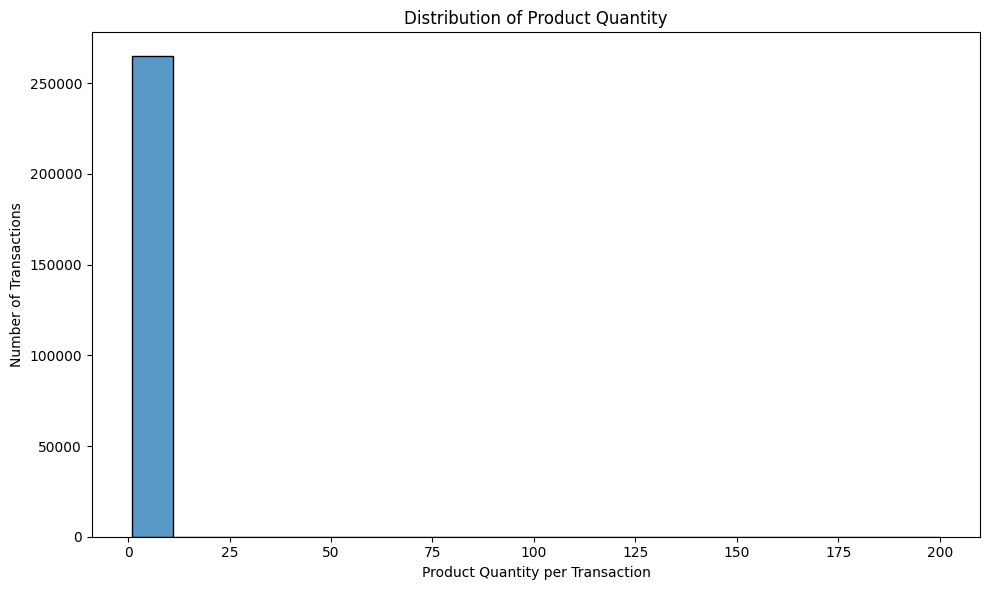

In [30]:
histogram(df,'PROD_QTY',20,"Distribution of Product Quantity","Product Quantity per Transaction","Number of Transactions")

In [31]:
outlier = df[df['PROD_QTY']==200]
outlier.head()

DATE STORE_NBR LYLTY_CARD_NBR  TXN_ID PROD_NBR  \
69762 2018-08-19       226         226000  226201        4   
69763 2019-05-20       226         226000  226210        4   

                              PROD_NAME  PROD_QTY  TOT_SALES Primary_key  \
69762  Dorito Corn Chp     Supreme 380g       200      650.0    226201-4   
69763  Dorito Corn Chp     Supreme 380g       200      650.0    226210-4   

            LIFESTAGE PREMIUM_CUSTOMER  Unit Price  
69762  OLDER FAMILIES          Premium        3.25  
69763  OLDER FAMILIES          Premium        3.25

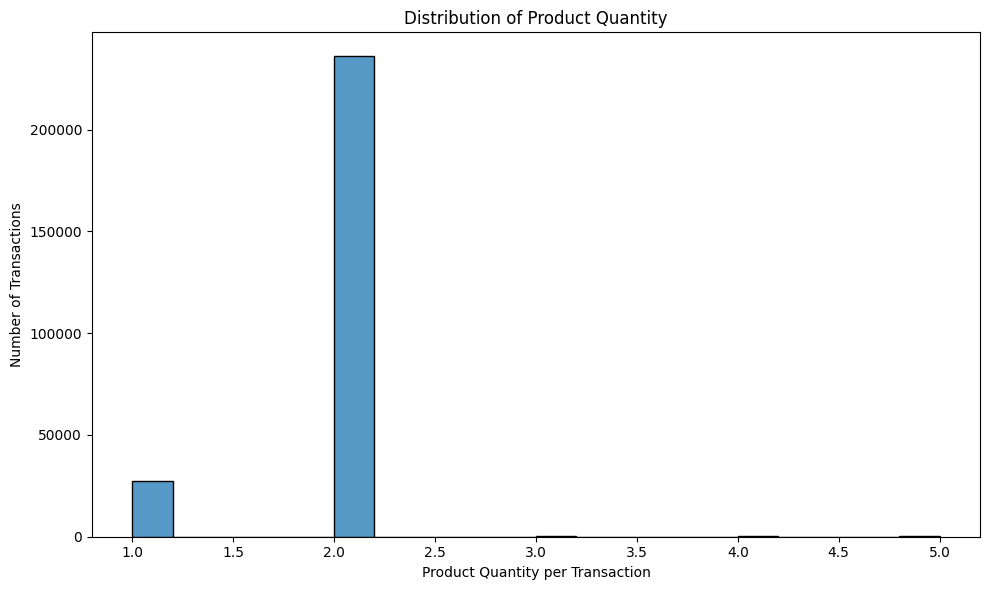

In [32]:
df = df[df['PROD_QTY']<200]
histogram(df,'PROD_QTY',20,"Distribution of Product Quantity","Product Quantity per Transaction","Number of Transactions")

In [33]:
df.describe()

DATE       PROD_QTY      TOT_SALES  \
count                         264833  264833.000000  264833.000000   
mean   2018-12-30 00:52:39.666657792       1.905812       7.299351   
min              2018-07-01 00:00:00       1.000000       1.500000   
25%              2018-09-30 00:00:00       2.000000       5.400000   
50%              2018-12-30 00:00:00       2.000000       7.400000   
75%              2019-03-31 00:00:00       2.000000       9.200000   
max              2019-06-30 00:00:00       5.000000      29.500000   
std                              NaN       0.343437       2.527244   

          Unit Price  
count  264833.000000  
mean        3.824632  
min         1.320000  
25%         3.000000  
50%         3.800000  
75%         4.600000  
max         6.500000  
std         1.109527

### Derived Fields-> Packet Size, Brand Name, Product Type, Flavour

In [34]:
# Data Formatting
df['PROD_NAME'] = df['PROD_NAME'].str.replace(r' +', ' ', regex=True)
df['LIFESTAGE'] = df['LIFESTAGE'].str.rstrip()
df['PREMIUM_CUSTOMER'] = df['PREMIUM_CUSTOMER'].str.rstrip()

In [35]:
# Packet Size Field Creation
df['Packet Size'] = df['PROD_NAME'].str[-4:]
df['Packet Size'] = df['Packet Size'].str.lower()
df['Packet Size'] = df['Packet Size'].str.rstrip()
print(df['Packet Size'].value_counts().to_dict())

{'175g': 66389, '150g': 43131, '134g': 25102, '110g': 22387, '170g': 19983, '165g': 15297, '300g': 15166, '330g': 12540, '380g': 6416, '270g': 6285, '210g': 6272, '200g': 4473, 'salt': 3257, '250g': 3169, ' 90g': 3008, '190g': 2995, '160g': 2970, '220g': 1564, ' 70g': 1507, '180g': 1468, '125g': 1454}


In [36]:
# Detect the Packet Size for Salt
salt = df[df['Packet Size']=='salt']
salt['PROD_NAME'].value_counts()

PROD_NAME
Kettle 135g Swt Pot Sea Salt    3257
Name: count, dtype: int64

In [37]:
# Replacing salt with 135g
df['Packet Size'] = df['Packet Size'].replace('salt', '135g')

In [38]:
# Brand Name, Product Type & Flavor - performed data cleaning manually
brand_mapping = pd.read_csv("Data/Quantium_Brand_Name_&_Product_Type_Mapping.csv")
brand_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product          114 non-null    object
 1   Brand Name       114 non-null    object
 2   L2 Product Type  114 non-null    object
 3   L1 Product Type  114 non-null    object
 4   L2 Flavour       114 non-null    object
 5   L1 Flavour       114 non-null    object
dtypes: object(6)
memory usage: 5.5+ KB


- **_L2 Product Type_**: This field is granular with more field values regarding the type of chip or other products purchased.
- **_L1 Product Type_**: This field has 2 field values (i.e) Chips, and Others and this field will provide a holistic view on chip products.
- **_L2 Flavour_**: This field is granular with more field values regarding the flavour of chip that's been purchased.
- **_L1 Flavour_**: This field is contains flavour of chips on a high level.
- **_Note_**: L2 shows more granular fields, while L1 covers high-level categories.

In [39]:
# Data linking
df = pd.merge(df,brand_mapping,left_on='PROD_NAME',right_on='Product',how='left')
df.drop(columns=['Product'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264833 entries, 0 to 264832
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              264833 non-null  datetime64[ns]
 1   STORE_NBR         264833 non-null  object        
 2   LYLTY_CARD_NBR    264833 non-null  object        
 3   TXN_ID            264833 non-null  object        
 4   PROD_NBR          264833 non-null  object        
 5   PROD_NAME         264833 non-null  object        
 6   PROD_QTY          264833 non-null  int64         
 7   TOT_SALES         264833 non-null  float64       
 8   Primary_key       264833 non-null  object        
 9   LIFESTAGE         264833 non-null  object        
 10  PREMIUM_CUSTOMER  264833 non-null  object        
 11  Unit Price        264833 non-null  float64       
 12  Packet Size       264833 non-null  object        
 13  Brand Name        264833 non-null  object        
 14  L2 P

In [40]:
print("Categorical Fields - All Products:")
print(f"* Brand Name: {df['Brand Name'].nunique()}\n",df["Brand Name"].value_counts().to_dict())
print(f"* L2 Product Type: {df['L2 Product Type'].nunique()}\n",df["L2 Product Type"].value_counts().to_dict())
print(f"* Packet Size: {df['Packet Size'].nunique()}\n",df["Packet Size"].value_counts().to_dict())
print(f"* Lifestage: {df['LIFESTAGE'].nunique()}\n",df["LIFESTAGE"].value_counts().to_dict())
print(f"* Customer Segment: {df['PREMIUM_CUSTOMER'].nunique()}\n",df["PREMIUM_CUSTOMER"].value_counts().to_dict())
print(f"* Store Number: {df['STORE_NBR'].nunique()}")
print(f"* Product Name: {df['PROD_NAME'].nunique()}")

Categorical Fields - All Products:
* Brand Name: 21
 {'Kettle': 41288, 'Smiths': 31822, 'Doritos': 28145, 'Pringles': 25102, 'Red Rock Deli': 17779, 'Woolworths': 14757, 'Infuzions': 14201, 'Thins': 14075, 'Cobs Popd': 9693, 'Tostitos': 9471, 'Twisties': 9454, 'Old El Paso': 9324, 'Grain Waves': 7740, 'Natural Chip Co': 7469, 'Tyrrells': 6442, 'Cheezels': 4603, 'CCs': 4551, 'Sunbites': 3008, 'Cheetos': 2927, 'Burger Rings': 1564, 'French Fries': 1418}
* L2 Product Type: 12
 {'Potato Chips': 149377, 'Corn Chips': 42390, 'Salsa': 15166, 'Corn Puffs': 12381, 'Wholegrain Chips (Corn, Wheat & Oats)': 10748, 'Popped Chips (Potato, Rice & Corn)': 9693, 'Tortilla Chips': 9580, 'Cheese Rings': 6119, 'Prawn Crackers': 3174, 'Veggie Straws': 3134, 'Corn Rings': 1564, 'Papadums': 1507}
* Packet Size: 21
 {'175g': 66389, '150g': 43131, '134g': 25102, '110g': 22387, '170g': 19983, '165g': 15297, '300g': 15166, '330g': 12540, '380g': 6416, '270g': 6285, '210g': 6272, '200g': 4473, '135g': 3257, '250g

**_Observation_**:
- *_Net Quantity of Chips ordered_*: 504k
- *_Total Sales_*: $1.9M
- *_Number of Transactions_*: 2,64,833 (after deduplication, outlier removal)
- *_Number of Stores_*: 272
- *_Number of Products_*: 114
- *_Brands_*: 21
- *_Product_types_*: 12
- *_Packet Sizes_*: 21
- *_Date Range_*: 2018-07-01 to 2019-06-30

### Chips

In [41]:
chips = df[df['L1 Product Type'].isin(['Chips'])]
chips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224962 entries, 0 to 264832
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              224962 non-null  datetime64[ns]
 1   STORE_NBR         224962 non-null  object        
 2   LYLTY_CARD_NBR    224962 non-null  object        
 3   TXN_ID            224962 non-null  object        
 4   PROD_NBR          224962 non-null  object        
 5   PROD_NAME         224962 non-null  object        
 6   PROD_QTY          224962 non-null  int64         
 7   TOT_SALES         224962 non-null  float64       
 8   Primary_key       224962 non-null  object        
 9   LIFESTAGE         224962 non-null  object        
 10  PREMIUM_CUSTOMER  224962 non-null  object        
 11  Unit Price        224962 non-null  float64       
 12  Packet Size       224962 non-null  object        
 13  Brand Name        224962 non-null  object        
 14  L2 Produc

In [42]:
print(f"Net Quantity of chips ordered: {chips['PROD_QTY'].sum()}")
print(f"Total Sales: ${int(chips['TOT_SALES'].sum())}")

Net Quantity of chips ordered: 428843
Total Sales: $1639788


In [43]:
chips.describe()

DATE       PROD_QTY      TOT_SALES  \
count                         224962  224962.000000  224962.000000   
mean   2018-12-30 00:43:42.778958336       1.906291       7.289178   
min              2018-07-01 00:00:00       1.000000       1.700000   
25%              2018-09-30 00:00:00       2.000000       5.800000   
50%              2018-12-30 00:00:00       2.000000       7.400000   
75%              2019-03-31 00:00:00       2.000000       8.800000   
max              2019-06-30 00:00:00       5.000000      29.500000   
std                              NaN       0.341995       2.453416   

          Unit Price  
count  224962.000000  
mean        3.818593  
min         1.320000  
25%         3.000000  
50%         3.700000  
75%         4.400000  
max         6.500000  
std         1.066652

In [44]:
print("Categorical Fields - Chips:")
print(f"* Brand Name: {chips['Brand Name'].nunique()}\n",chips["Brand Name"].value_counts().to_dict())
print(f"* L2 Product Type: {chips['L2 Product Type'].nunique()}\n",chips["L2 Product Type"].value_counts().to_dict())
print(f"* Packet Size: {chips['Packet Size'].nunique()}\n",chips["Packet Size"].value_counts().to_dict())
print(f"* Lifestage: {chips['LIFESTAGE'].nunique()}\n",chips["LIFESTAGE"].value_counts().to_dict())
print(f"* Customer Segment: {chips['PREMIUM_CUSTOMER'].nunique()}\n",chips["PREMIUM_CUSTOMER"].value_counts().to_dict())
print(f"* Store Number: {chips['STORE_NBR'].nunique()}")
print(f"* Product Name: {chips['PROD_NAME'].nunique()}")

Categorical Fields - Chips:
* Brand Name: 16
 {'Kettle': 41288, 'Smiths': 31822, 'Doritos': 25224, 'Pringles': 25102, 'Red Rock Deli': 17779, 'Thins': 14075, 'Woolworths': 10320, 'Cobs Popd': 9693, 'Infuzions': 9560, 'Tostitos': 9471, 'Grain Waves': 7740, 'Natural Chip Co': 7469, 'Tyrrells': 6442, 'CCs': 4551, 'Sunbites': 3008, 'French Fries': 1418}
* L2 Product Type: 6
 {'Potato Chips': 149377, 'Corn Chips': 42390, 'Wholegrain Chips (Corn, Wheat & Oats)': 10748, 'Popped Chips (Potato, Rice & Corn)': 9693, 'Tortilla Chips': 9580, 'Prawn Crackers': 3174}
* Packet Size: 14
 {'175g': 66389, '150g': 43131, '134g': 25102, '170g': 19983, '110g': 19253, '165g': 13849, '330g': 9391, '380g': 6416, '210g': 6272, '200g': 4473, '135g': 3257, ' 90g': 3008, '160g': 2970, '180g': 1468}
* Lifestage: 7
 {'OLDER SINGLES/COUPLES': 46325, 'RETIREES': 42342, 'OLDER FAMILIES': 41148, 'YOUNG FAMILIES': 36928, 'YOUNG SINGLES/COUPLES': 30942, 'MIDAGE SINGLES/COUPLES': 21341, 'NEW FAMILIES': 5936}
* Customer Se

**_Observation_**:
- *_Net Quantity of Chips ordered_*: 428k
- *_Total Sales_*: $1.6M
- *_Number of Transactions_*: 2,24,962 (after deduplication, outlier removal & filteration)
- *_Number of Stores_*: 271
- *_Number of Products_*: 96
- *_Brands_*: 16
- *_Product_types_*: 6
- *_Packet Sizes_*: 14
- *_Date Range_*: 2018-07-01 to 2019-06-30

### Other products

In [45]:
other_products = df[~df['L1 Product Type'].isin(['Chips'])]
other_products.shape

(39871, 18)

In [46]:
other_products.describe()

DATE      PROD_QTY     TOT_SALES    Unit Price
count                          39871  39871.000000  39871.000000  39871.000000
mean   2018-12-30 01:43:08.919264512      1.903113      7.356748      3.858704
min              2018-07-01 00:00:00      1.000000      1.500000      1.500000
25%              2018-09-30 00:00:00      2.000000      4.800000      2.600000
50%              2018-12-30 00:00:00      2.000000      7.600000      4.300000
75%              2019-04-01 00:00:00      2.000000     10.200000      5.100000
max              2019-06-30 00:00:00      5.000000     28.500000      5.700000
std                              NaN      0.351453      2.908268      1.325209

In [47]:
print(f"Net Quantity of other products ordered: {other_products['PROD_QTY'].sum()}")
print(f"Total Sales: ${int(other_products['TOT_SALES'].sum())}")

Net Quantity of other products ordered: 75879
Total Sales: $293320


In [48]:
print("Categorical Fields - Other Products:")
print(f"* Brand Name: {other_products['Brand Name'].nunique()}\n",other_products["Brand Name"].value_counts().to_dict())
print(f"* L2 Product Type: {other_products['L2 Product Type'].nunique()}\n",other_products["L2 Product Type"].value_counts().to_dict())
print(f"* Packet Size: {other_products['Packet Size'].nunique()}\n",other_products["Packet Size"].value_counts().to_dict())
print(f"* Lifestage: {other_products['LIFESTAGE'].nunique()}\n",other_products["LIFESTAGE"].value_counts().to_dict())
print(f"* Customer Segment: {other_products['PREMIUM_CUSTOMER'].nunique()}\n",other_products["PREMIUM_CUSTOMER"].value_counts().to_dict())
print(f"* Store Number: {other_products['STORE_NBR'].nunique()}")
print(f"* Product Name: {other_products['PROD_NAME'].nunique()}")

Categorical Fields - Other Products:
* Brand Name: 8
 {'Twisties': 9454, 'Old El Paso': 9324, 'Infuzions': 4641, 'Cheezels': 4603, 'Woolworths': 4437, 'Cheetos': 2927, 'Doritos': 2921, 'Burger Rings': 1564}
* L2 Product Type: 6
 {'Salsa': 15166, 'Corn Puffs': 12381, 'Cheese Rings': 6119, 'Veggie Straws': 3134, 'Corn Rings': 1564, 'Papadums': 1507}
* Packet Size: 10
 {'300g': 15166, '270g': 6285, '250g': 3169, '330g': 3149, '110g': 3134, '190g': 2995, '220g': 1564, ' 70g': 1507, '125g': 1454, '165g': 1448}
* Lifestage: 7
 {'OLDER SINGLES/COUPLES': 8153, 'OLDER FAMILIES': 7446, 'RETIREES': 7421, 'YOUNG FAMILIES': 6664, 'YOUNG SINGLES/COUPLES': 5435, 'MIDAGE SINGLES/COUPLES': 3769, 'NEW FAMILIES': 983}
* Customer Segment: 3
 {'Mainstream': 15339, 'Budget': 14055, 'Premium': 10477}
* Store Number: 266
* Product Name: 18


**_Observation_**:
- *_Net Quantity of Chips ordered_*: 75.8k
- *_Total Sales_*: $293k
- *_Number of Transactions_*: 2,24,962 (after deduplication, outlier removal & filteration)
- *_Number of Stores_*: 266
- *_Number of Products_*: 18
- *_Brands_*: 8
- *_Product_types_*: 6
- *_Packet Sizes_*: 10
- *_Date Range_*: 2018-07-01 to 2019-06-30

## Data Visualization

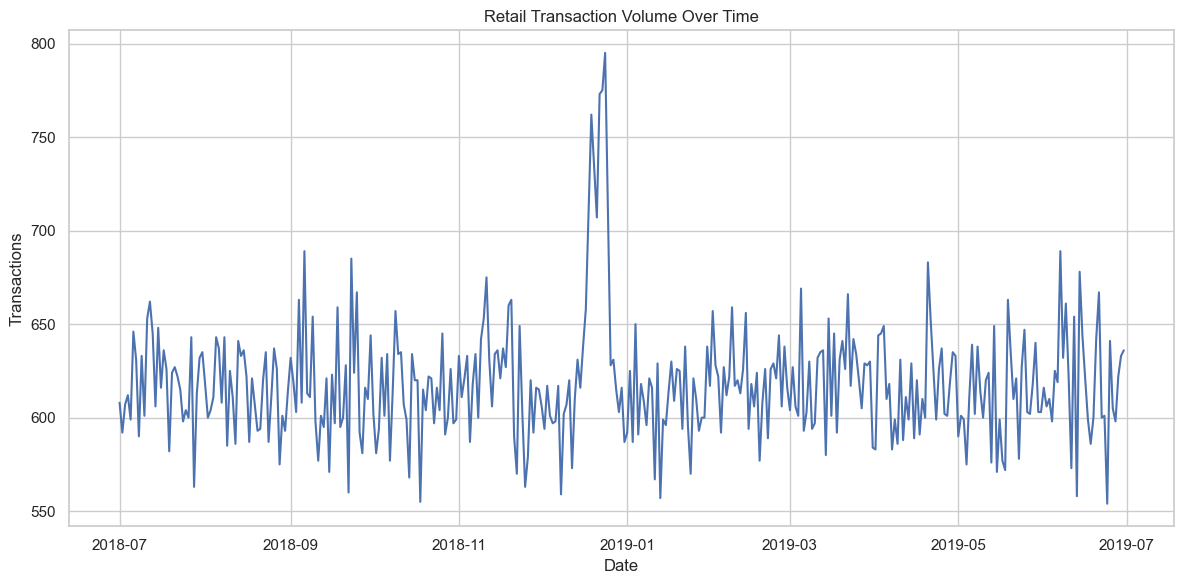

In [49]:
line_chart(chips, 'DATE', "Retail Transaction Volume Over Time", "Date", "Transactions",0)

**_Observation_**: Average transactions per day is around 750 during Christmas Week of 2018

### December 2018

In [50]:
df_dec_2018 = chips[(chips['DATE'].dt.month == 12) & (chips['DATE'].dt.year == 2018)]
df_dec_2018.shape

(19281, 18)

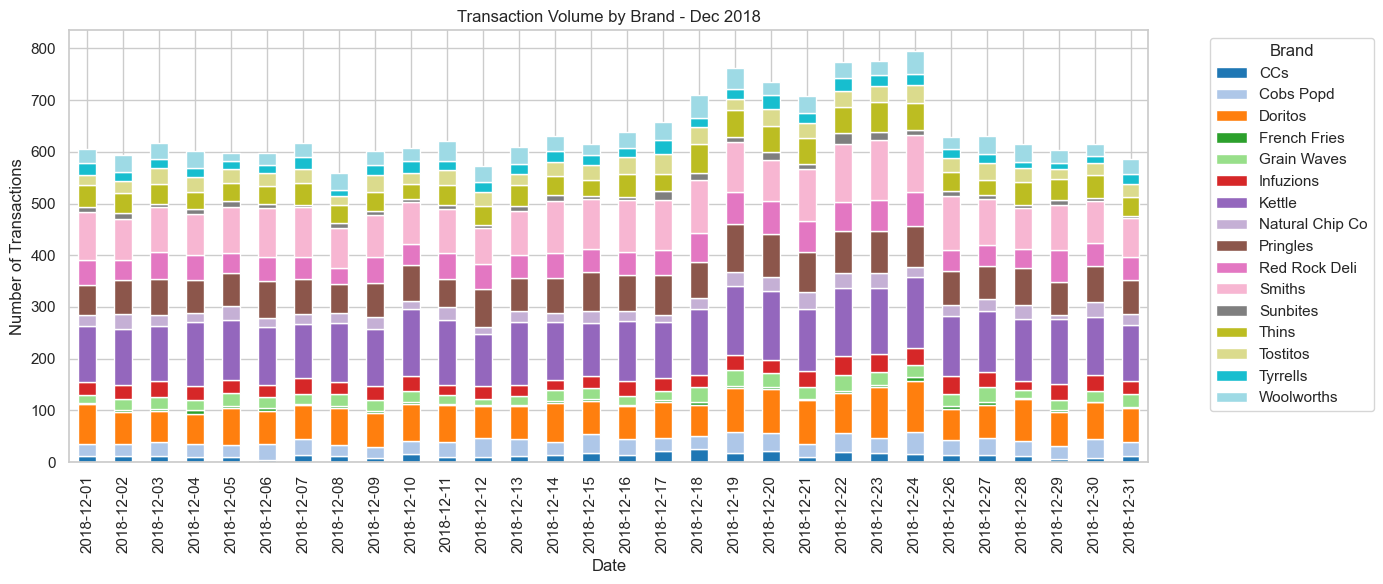

In [51]:
stacked_bar(df_dec_2018, 'DATE', 'Brand Name', "Transaction Volume by Brand - Dec 2018", "Date", "Number of Transactions", 'tab20',90,'Brand')

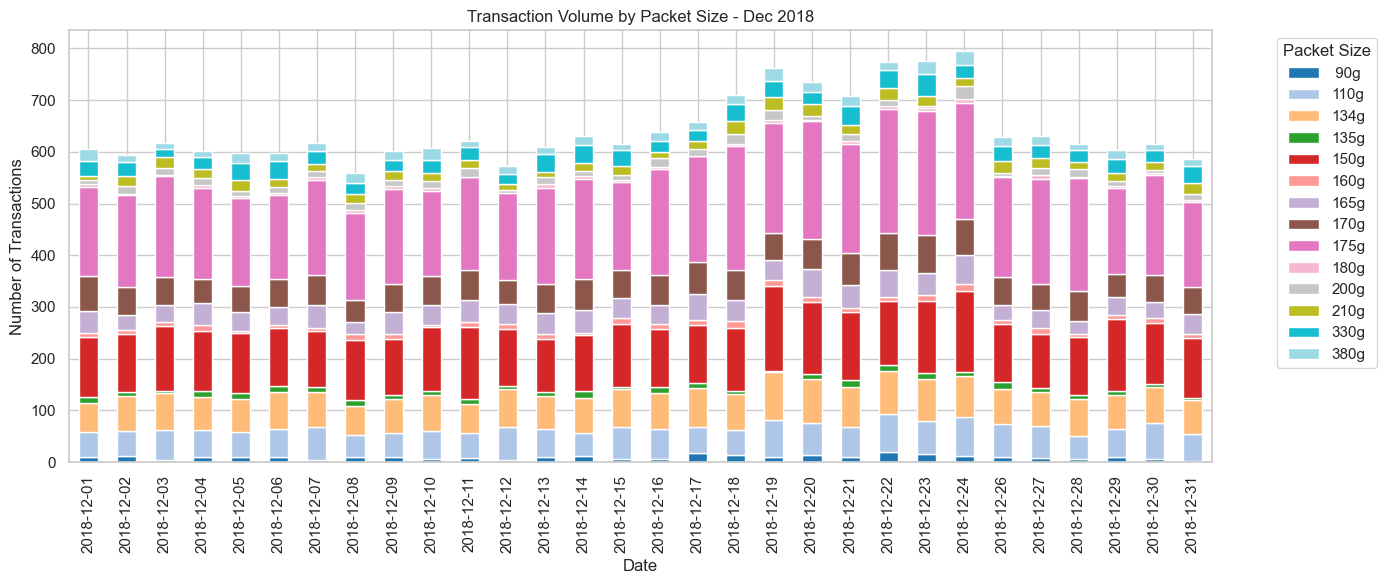

In [52]:
stacked_bar(df_dec_2018, 'DATE', 'Packet Size', "Transaction Volume by Packet Size - Dec 2018", "Date", "Number of Transactions", 'tab20',90,'Packet Size')

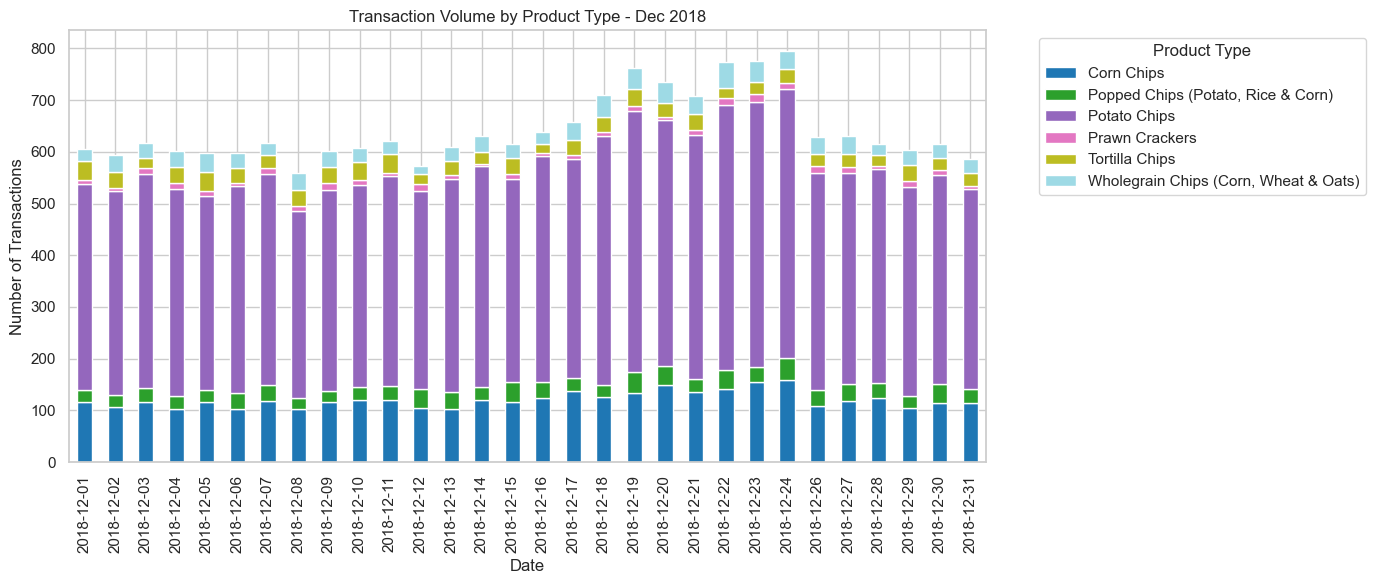

In [53]:
stacked_bar(df_dec_2018, 'DATE', 'L2 Product Type', "Transaction Volume by Product Type - Dec 2018", "Date", "Number of Transactions", 'tab20',90,'Product Type')

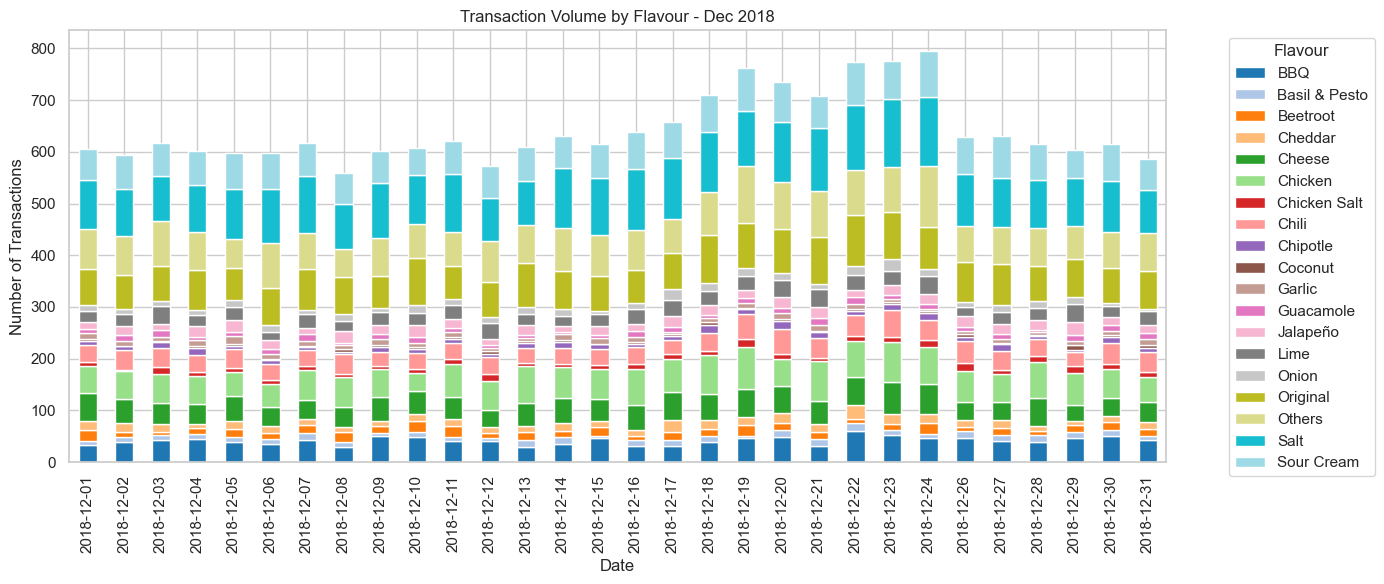

In [54]:
stacked_bar(df_dec_2018, 'DATE', 'L1 Flavour', "Transaction Volume by Flavour - Dec 2018", "Date", "Number of Transactions", 'tab20',90,'Flavour')

### Christmas 2018

In [55]:
start_date = '2018-12-18'
end_date = '2018-12-24'
christmas_2018 = chips[(chips['DATE'] >= start_date) & (chips['DATE'] <= end_date)]
christmas_2018.shape

(5257, 18)

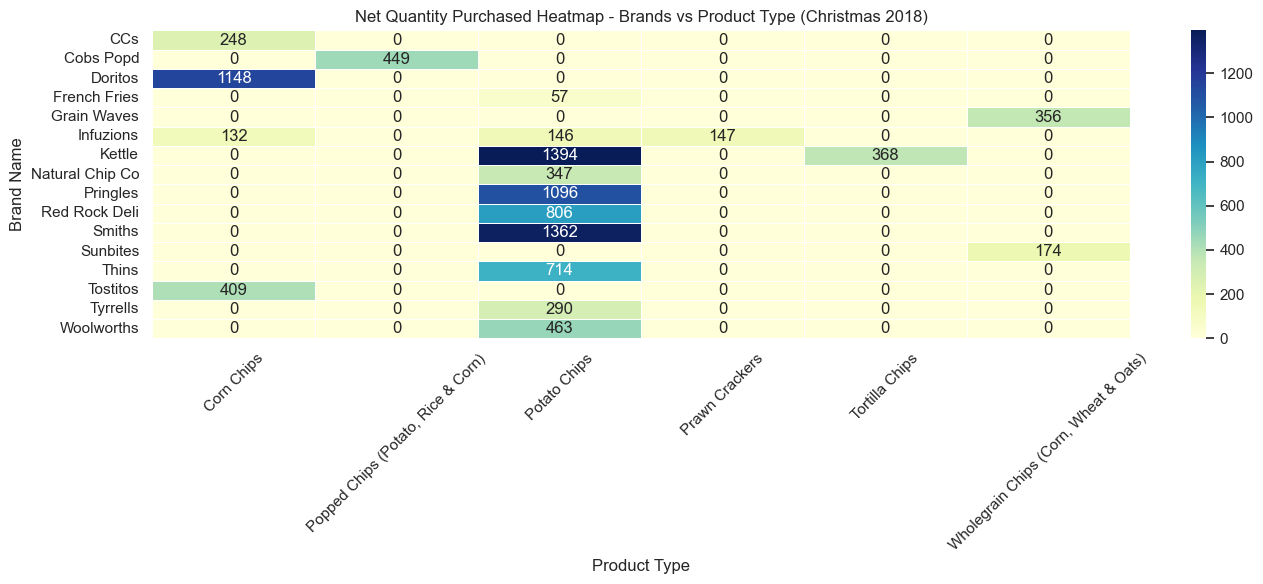

In [56]:
heat_map(christmas_2018, 'L2 Product Type', 'Brand Name','PROD_QTY', "Net Quantity Purchased Heatmap - Brands vs Product Type (Christmas 2018)", "Product Type", "Brand Name", 'YlGnBu', 45)

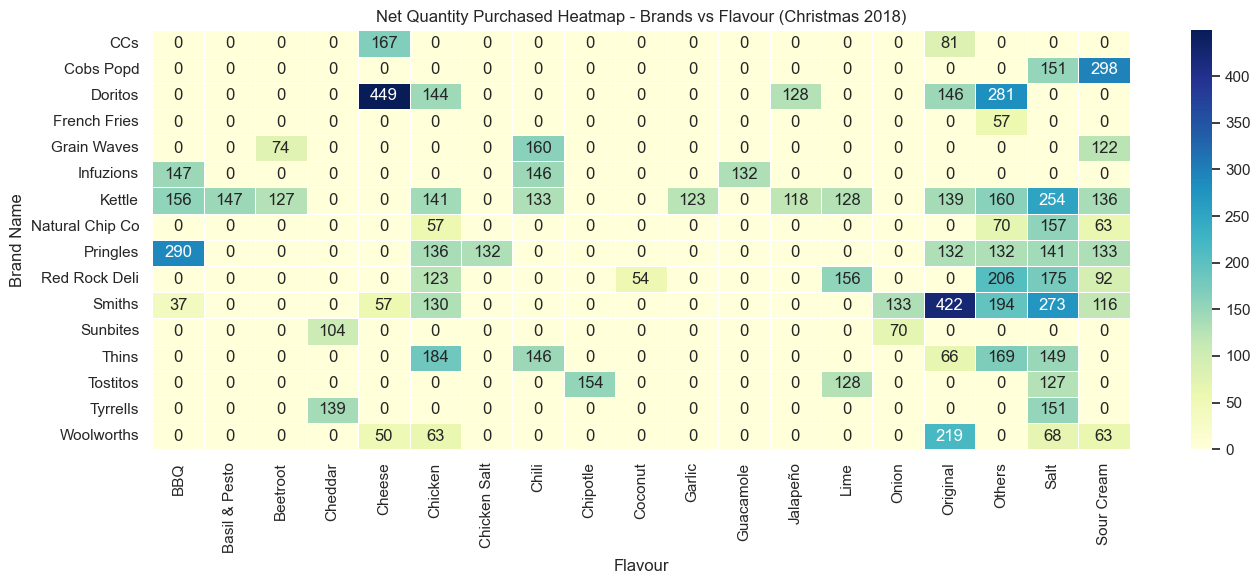

In [57]:
heat_map(christmas_2018, 'L1 Flavour', 'Brand Name', 'PROD_QTY', "Net Quantity Purchased Heatmap - Brands vs Flavour (Christmas 2018)", "Flavour", "Brand Name", 'YlGnBu', 90)

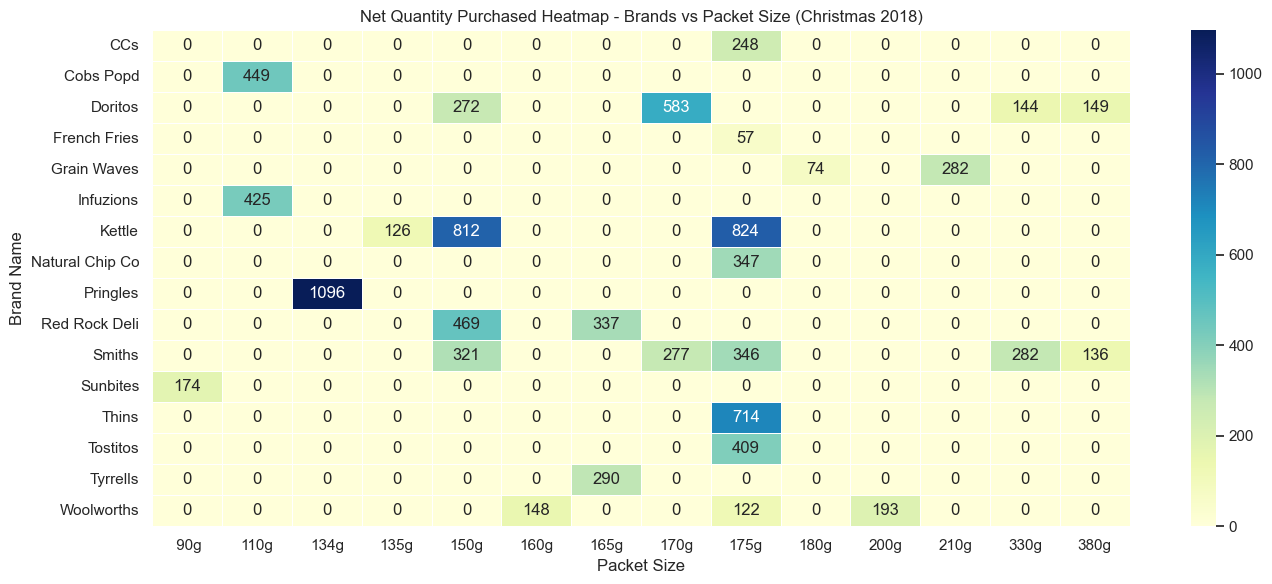

In [58]:
heat_map(christmas_2018, 'Packet Size', 'Brand Name','PROD_QTY', "Net Quantity Purchased Heatmap - Brands vs Packet Size (Christmas 2018)", "Packet Size", "Brand Name", 'YlGnBu', 0)

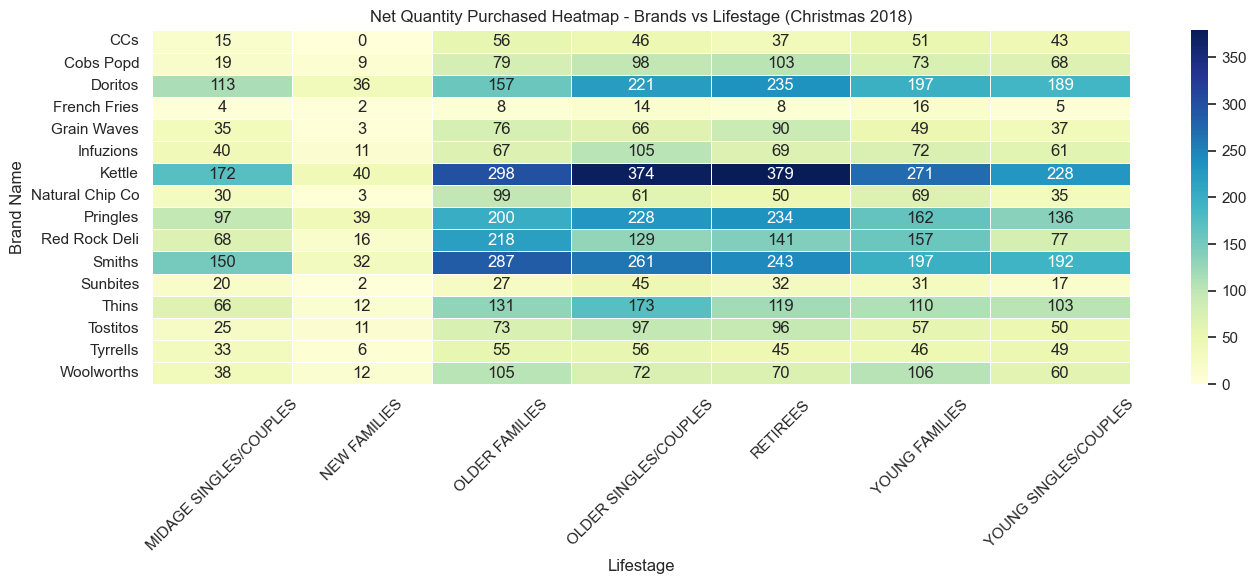

In [59]:
heat_map(christmas_2018, 'LIFESTAGE', 'Brand Name', 'PROD_QTY', "Net Quantity Purchased Heatmap - Brands vs Lifestage (Christmas 2018)", "Lifestage", "Brand Name", 'YlGnBu', 45)

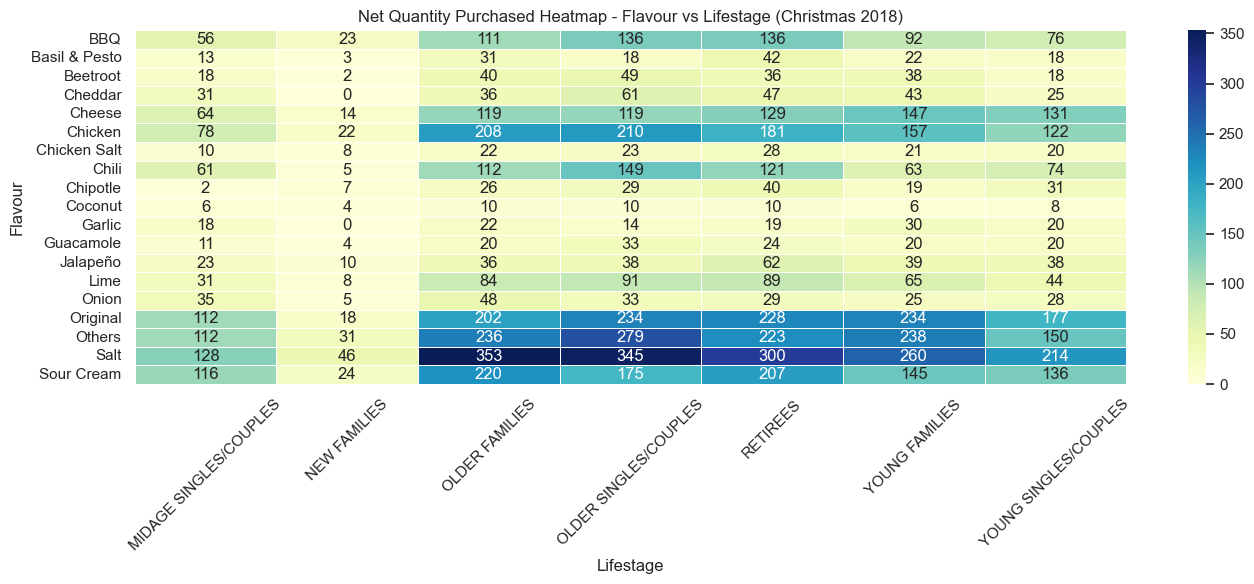

In [60]:
heat_map(christmas_2018, 'LIFESTAGE', 'L1 Flavour','PROD_QTY', "Net Quantity Purchased Heatmap - Flavour vs Lifestage (Christmas 2018)", "Lifestage", "Flavour", 'YlGnBu', 45)

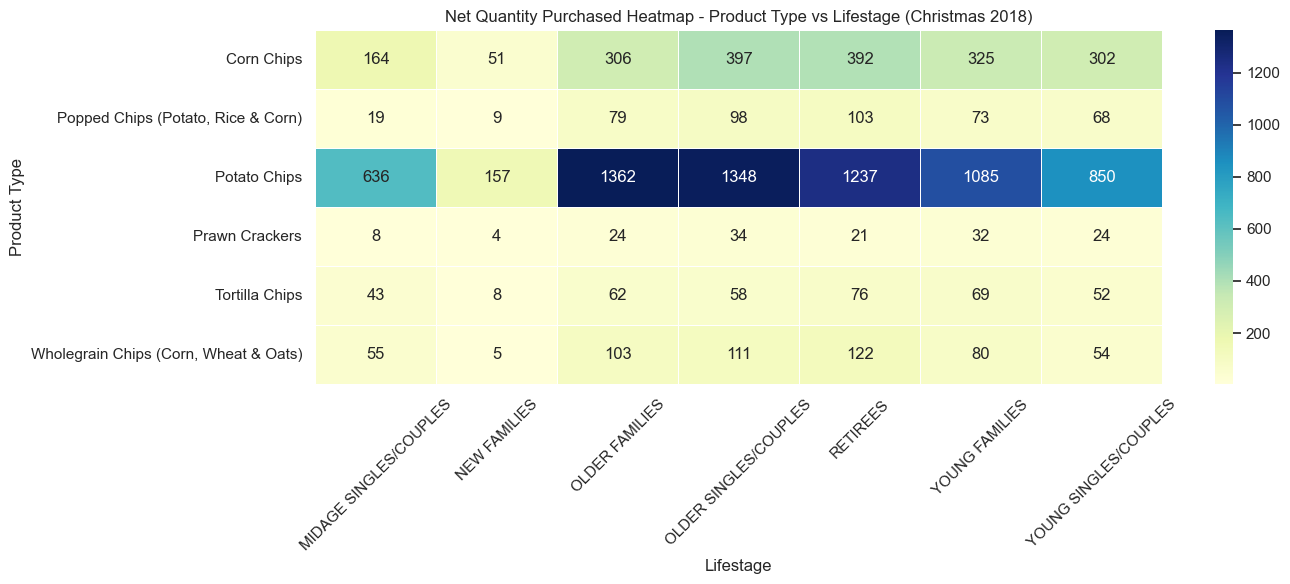

In [61]:
heat_map(christmas_2018, 'LIFESTAGE', 'L2 Product Type','PROD_QTY', "Net Quantity Purchased Heatmap - Product Type vs Lifestage (Christmas 2018)", "Lifestage", "Product Type", 'YlGnBu', 45)

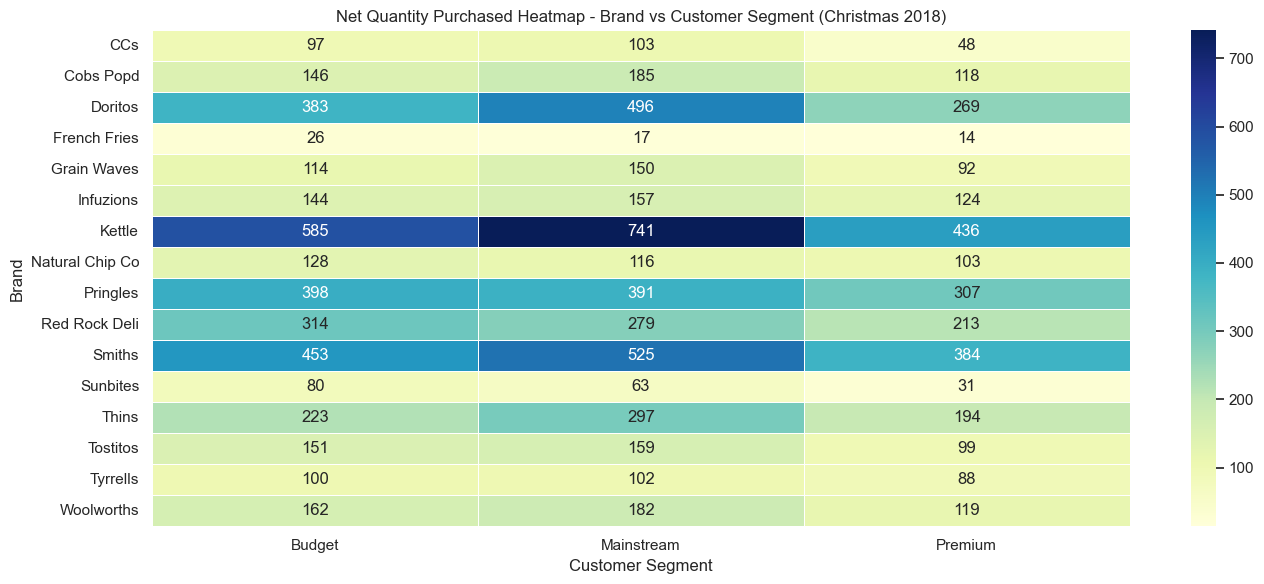

In [62]:
heat_map(christmas_2018, 'PREMIUM_CUSTOMER', 'Brand Name','PROD_QTY', "Net Quantity Purchased Heatmap - Brand vs Customer Segment (Christmas 2018)", "Customer Segment", "Brand", 'YlGnBu', 0)

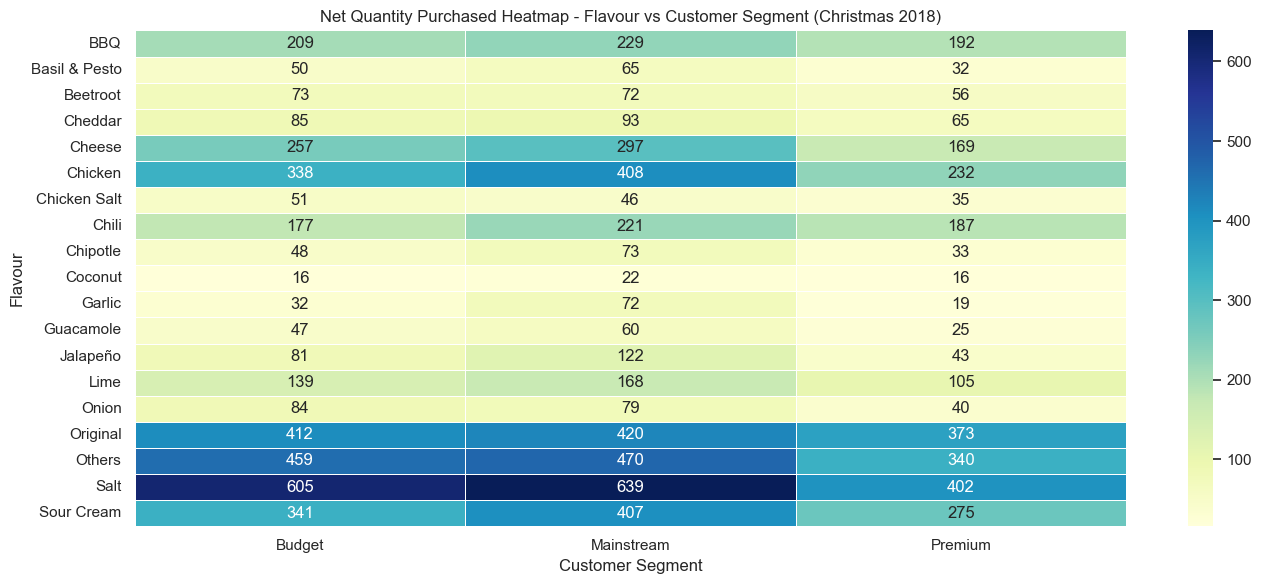

In [63]:
heat_map(christmas_2018, 'PREMIUM_CUSTOMER', 'L1 Flavour', 'PROD_QTY', "Net Quantity Purchased Heatmap - Flavour vs Customer Segment (Christmas 2018)", "Customer Segment", "Flavour", 'YlGnBu', 0)

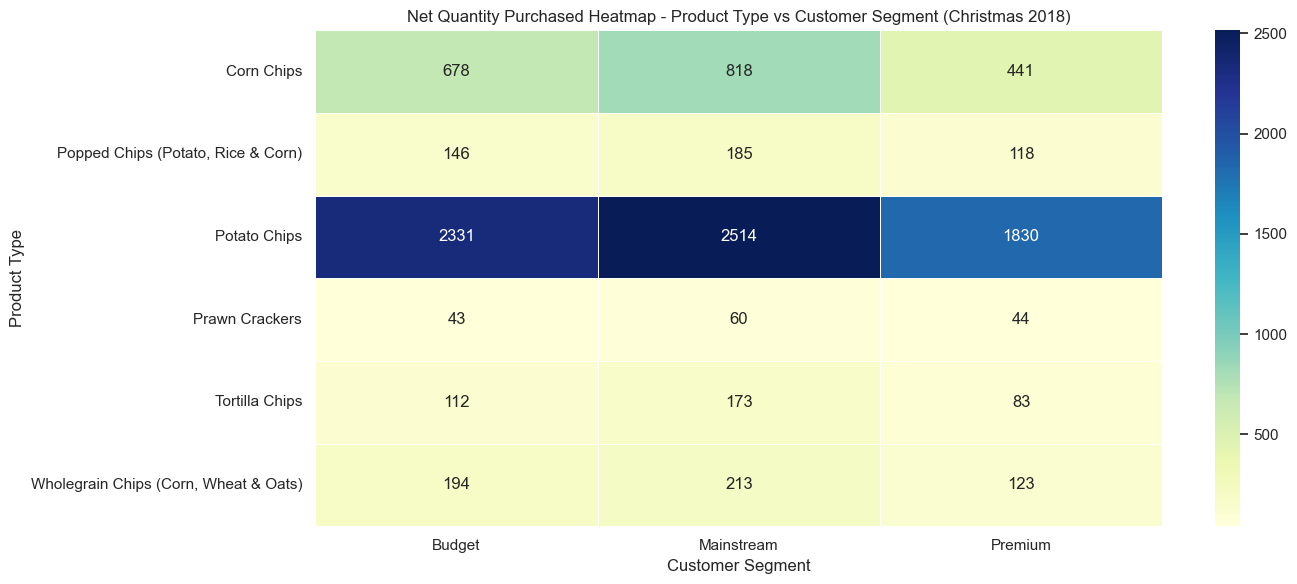

In [64]:
heat_map(christmas_2018, 'PREMIUM_CUSTOMER', 'L2 Product Type', 'PROD_QTY', "Net Quantity Purchased Heatmap - Product Type vs Customer Segment (Christmas 2018)", "Customer Segment", "Product Type", 'YlGnBu', 0)

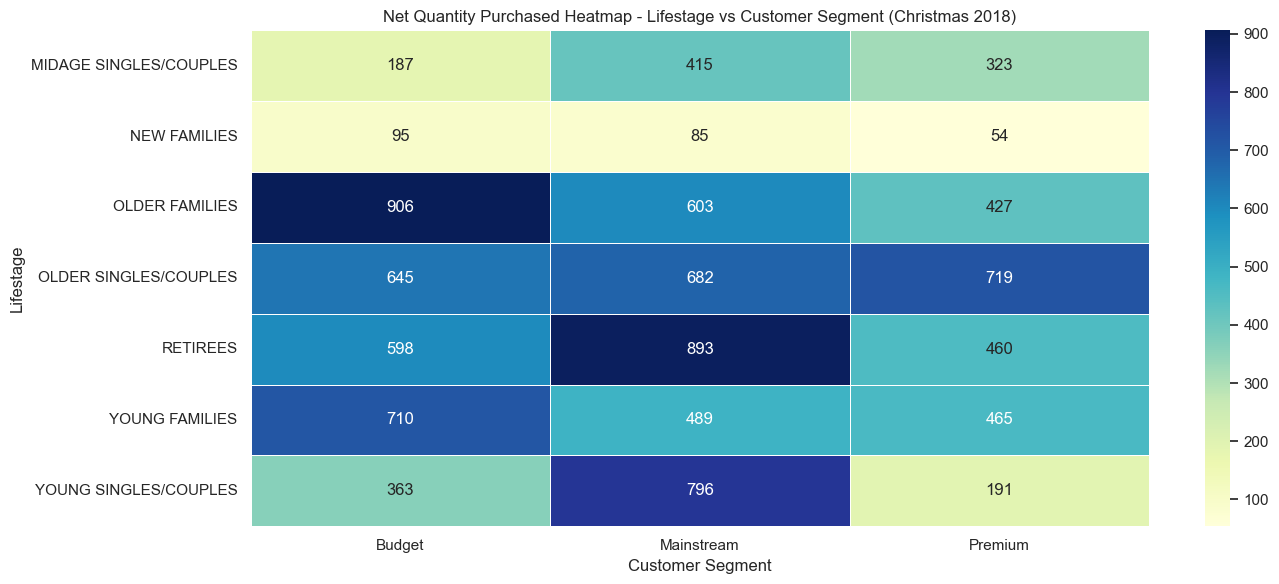

In [65]:
heat_map(christmas_2018, 'PREMIUM_CUSTOMER', 'LIFESTAGE', 'PROD_QTY', "Net Quantity Purchased Heatmap - Lifestage vs Customer Segment (Christmas 2018)", "Customer Segment", "Lifestage", 'YlGnBu', 0)

#### Kettle Products - Christmas 2018

In [66]:
Kettle_Xmas_2018 = christmas_2018[christmas_2018['Brand Name']=='Kettle']
Kettle_Xmas_2018.shape

(908, 18)

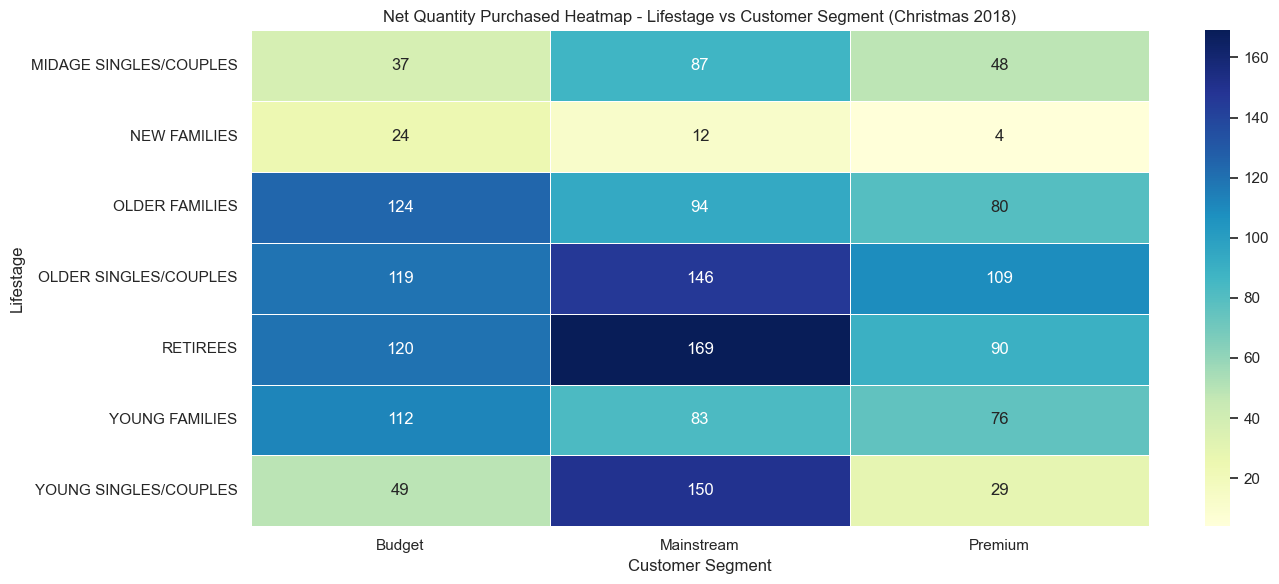

In [67]:
heat_map(Kettle_Xmas_2018, 'PREMIUM_CUSTOMER', 'LIFESTAGE','PROD_QTY', "Net Quantity Purchased Heatmap - Lifestage vs Customer Segment (Christmas 2018)", "Customer Segment", "Lifestage", 'YlGnBu', 0)

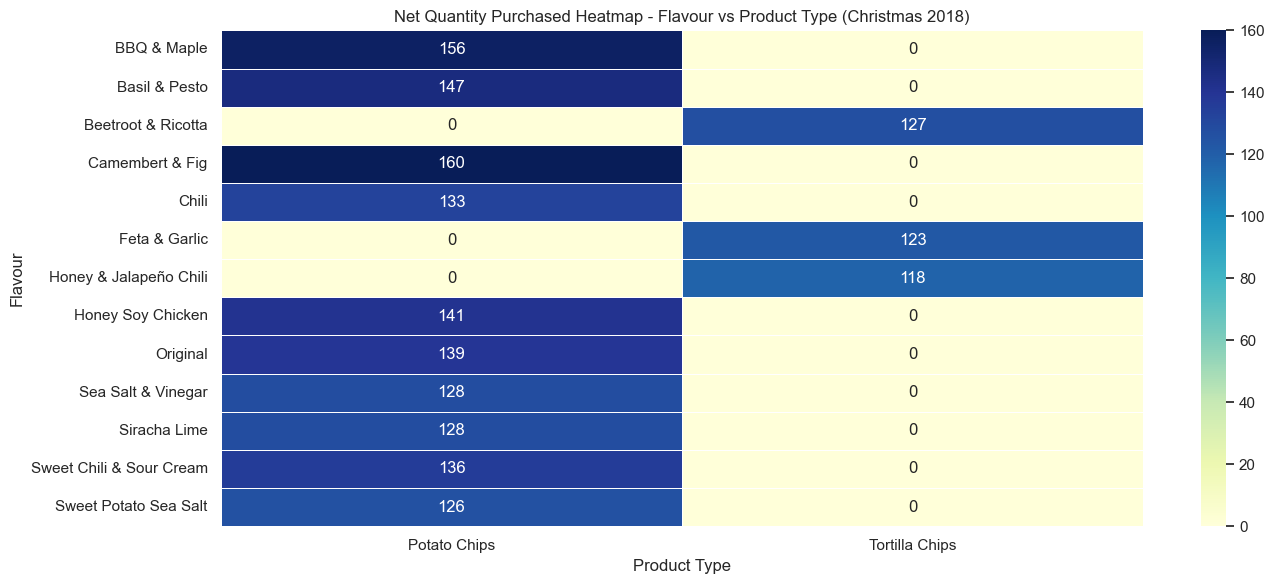

In [68]:
heat_map(Kettle_Xmas_2018, 'L2 Product Type', 'L2 Flavour','PROD_QTY', "Net Quantity Purchased Heatmap - Flavour vs Product Type (Christmas 2018)", "Product Type", "Flavour", 'YlGnBu', 0)

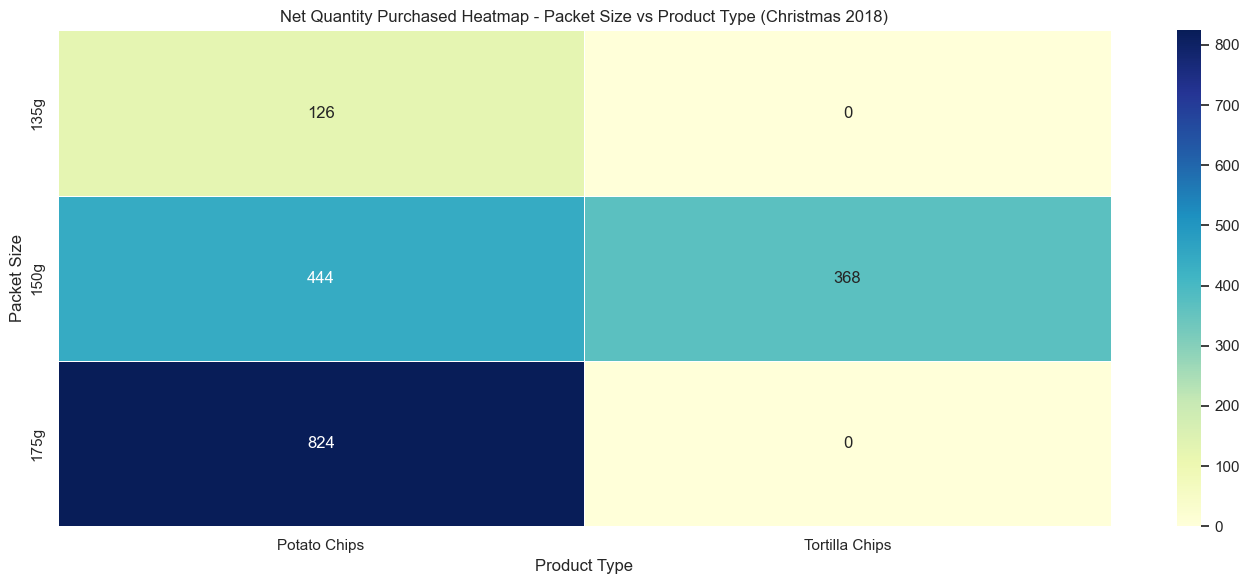

In [69]:
heat_map(Kettle_Xmas_2018, 'L2 Product Type', 'Packet Size','PROD_QTY', "Net Quantity Purchased Heatmap - Packet Size vs Product Type (Christmas 2018)", "Product Type", "Packet Size", 'YlGnBu', 0)

### Smiths Products - Christmas 2018

In [70]:
Smiths_Xmas_2018 = christmas_2018[christmas_2018['Brand Name']=='Smiths']
Smiths_Xmas_2018.shape

(719, 18)

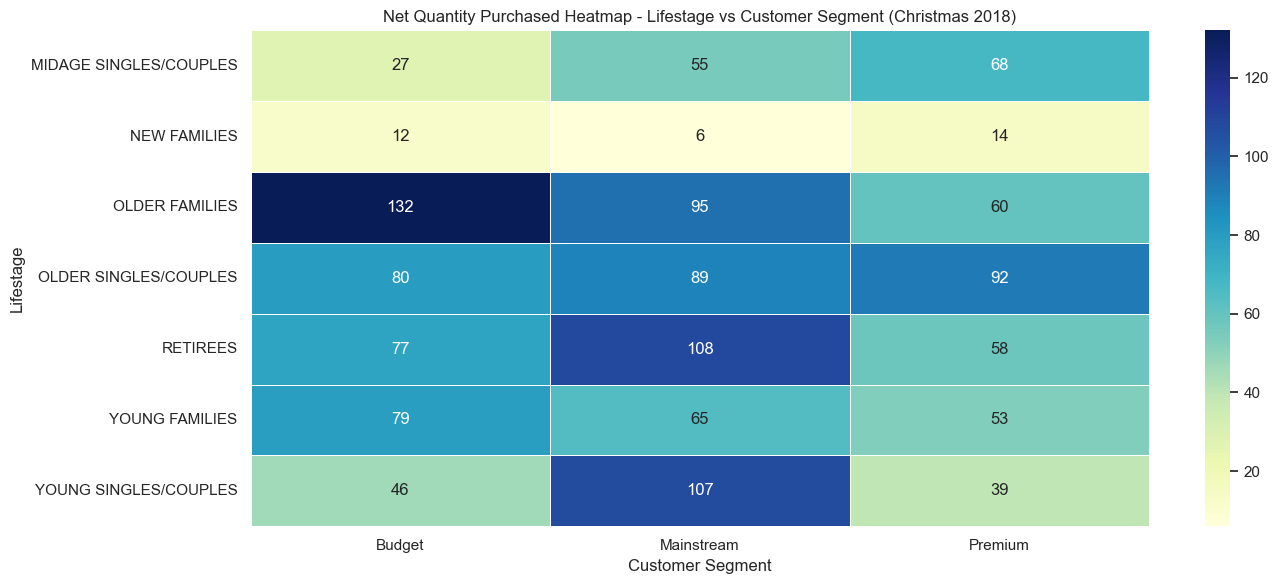

In [71]:
heat_map(Smiths_Xmas_2018, 'PREMIUM_CUSTOMER', 'LIFESTAGE', 'PROD_QTY', "Net Quantity Purchased Heatmap - Lifestage vs Customer Segment (Christmas 2018)", "Customer Segment", "Lifestage", 'YlGnBu', 0)

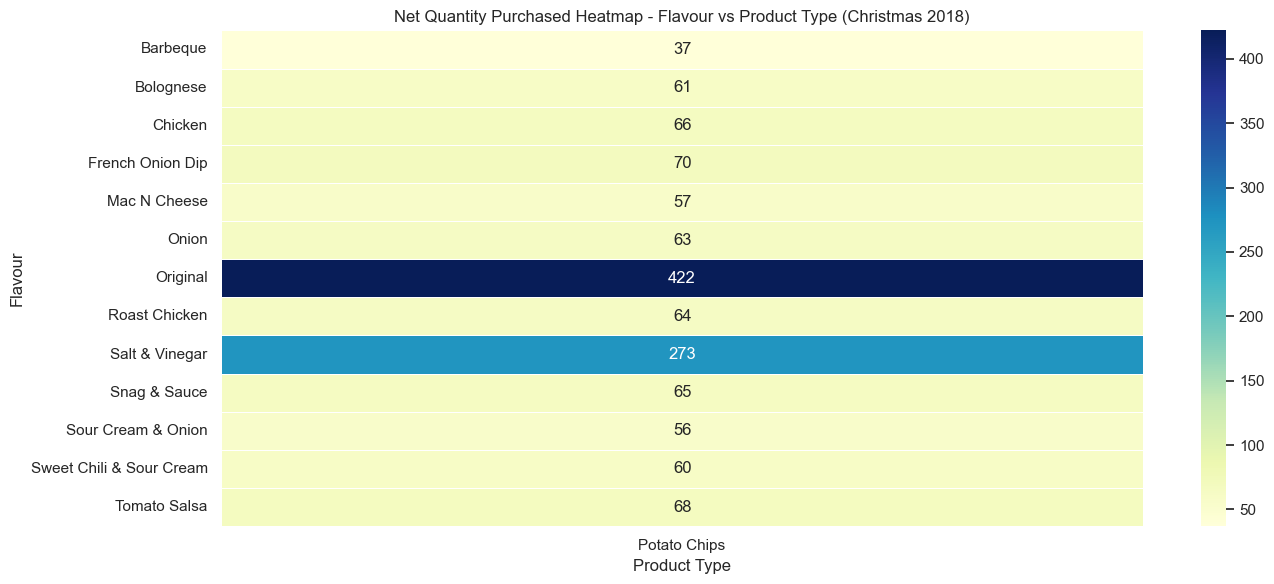

In [72]:
heat_map(Smiths_Xmas_2018, 'L2 Product Type', 'L2 Flavour','PROD_QTY', "Net Quantity Purchased Heatmap - Flavour vs Product Type (Christmas 2018)", "Product Type", "Flavour", 'YlGnBu', 0)

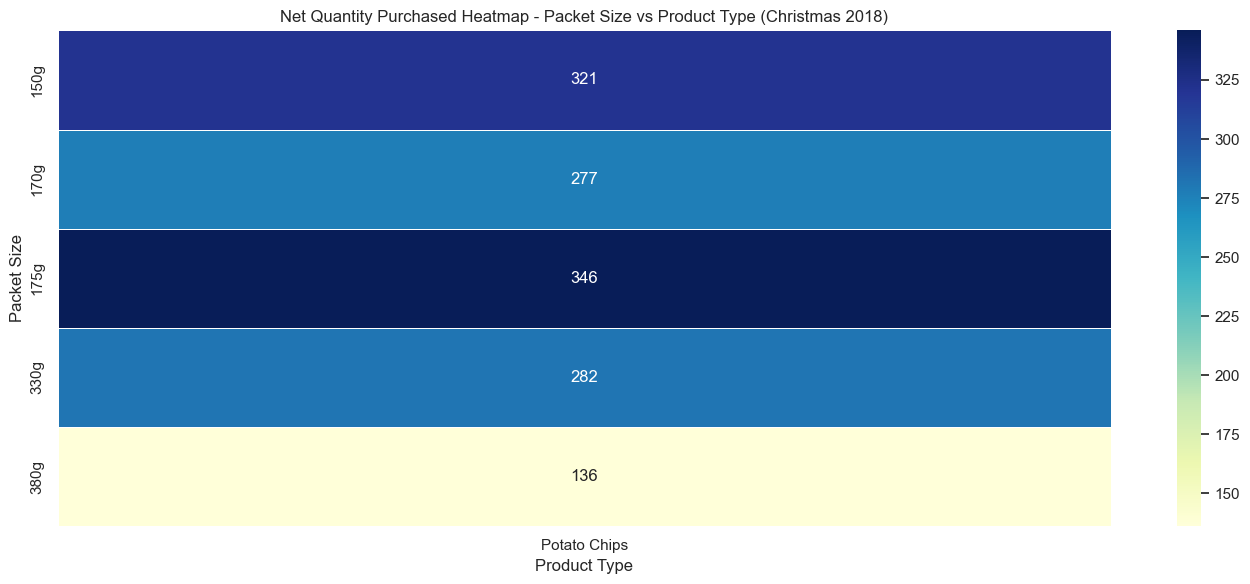

In [73]:
heat_map(Smiths_Xmas_2018, 'L2 Product Type', 'Packet Size','PROD_QTY', "Net Quantity Purchased Heatmap - Packet Size vs Product Type (Christmas 2018)", "Product Type", "Packet Size", 'YlGnBu', 0)

#### Doritos Products - Christmas 2018

In [74]:
Doritos_Xmas_2018 = christmas_2018[christmas_2018['Brand Name']=='Doritos']
Doritos_Xmas_2018.shape

(588, 18)

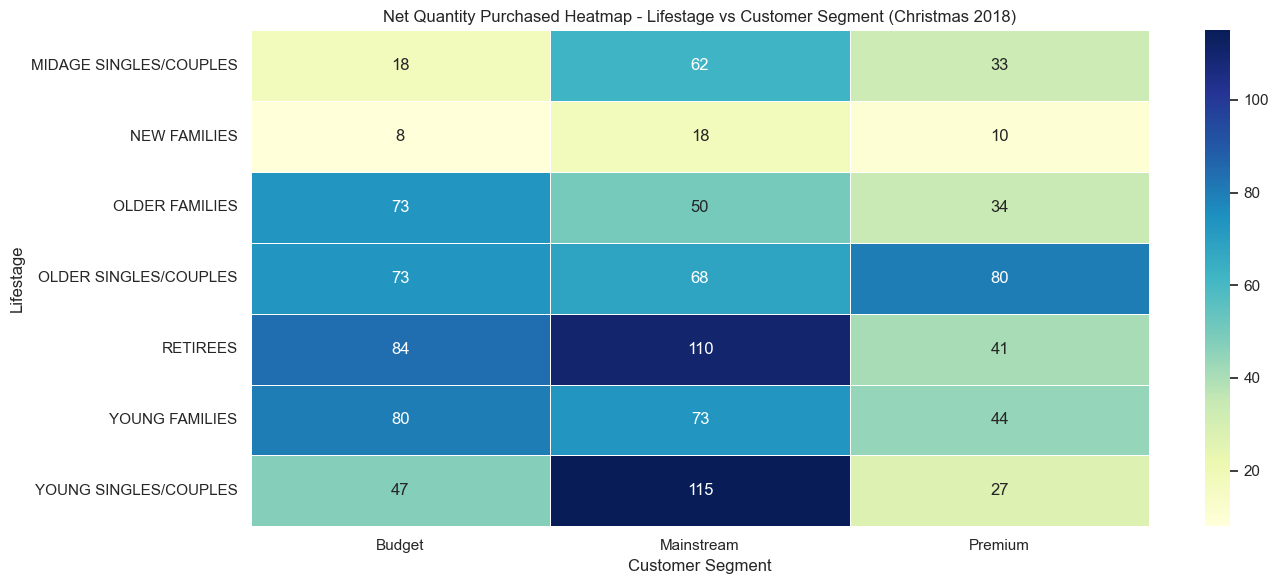

In [75]:
heat_map(Doritos_Xmas_2018, 'PREMIUM_CUSTOMER', 'LIFESTAGE', 'PROD_QTY', "Net Quantity Purchased Heatmap - Lifestage vs Customer Segment (Christmas 2018)", "Customer Segment", "Lifestage", 'YlGnBu', 0)

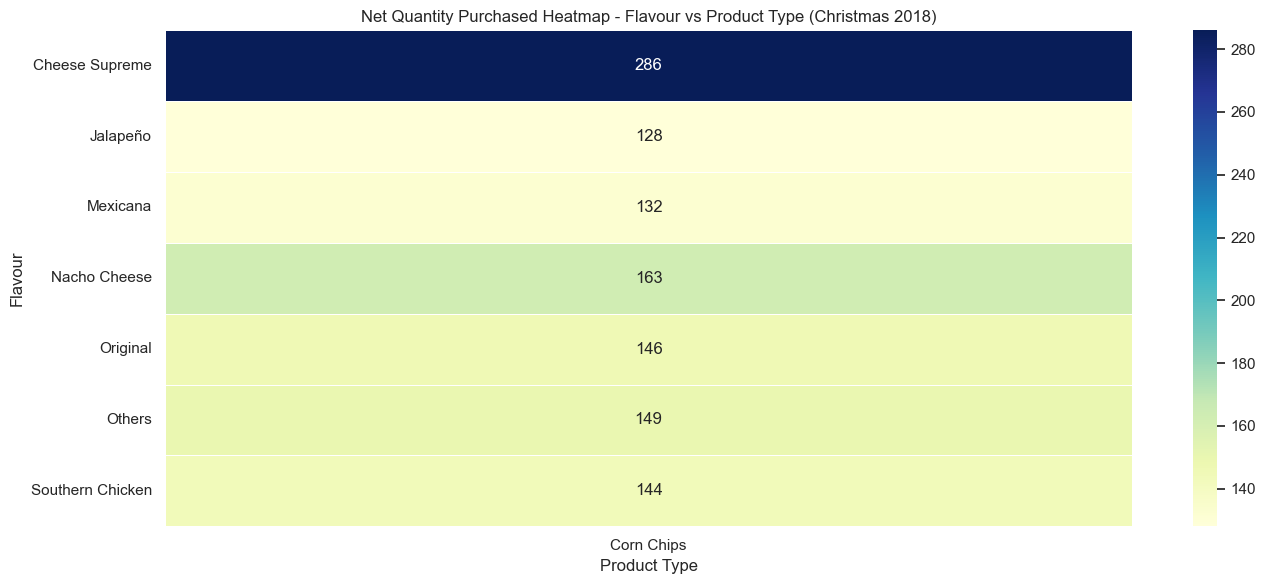

In [76]:
heat_map(Doritos_Xmas_2018, 'L2 Product Type', 'L2 Flavour', 'PROD_QTY', "Net Quantity Purchased Heatmap - Flavour vs Product Type (Christmas 2018)", "Product Type", "Flavour", 'YlGnBu', 0)

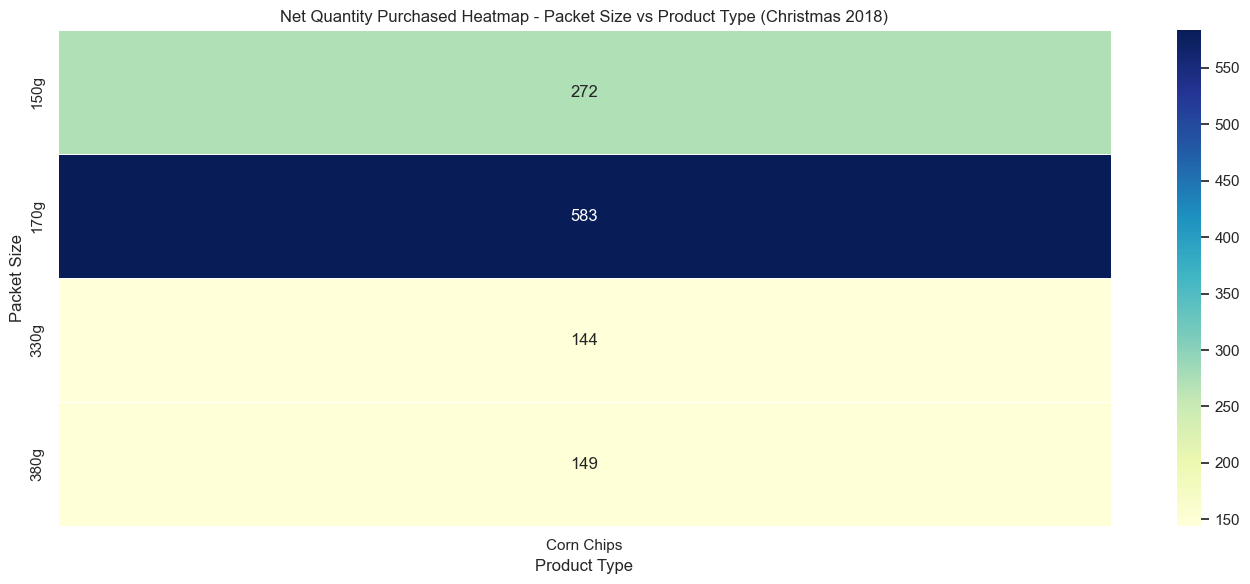

In [77]:
heat_map(Doritos_Xmas_2018, 'L2 Product Type', 'Packet Size', 'PROD_QTY', "Net Quantity Purchased Heatmap - Packet Size vs Product Type (Christmas 2018)", "Product Type", "Packet Size", 'YlGnBu', 0)

#### Pringles Products - Christmas 2018

In [78]:
Pringles_Xmas_2018 = christmas_2018[christmas_2018['Brand Name']=='Pringles']
Pringles_Xmas_2018.shape

(568, 18)

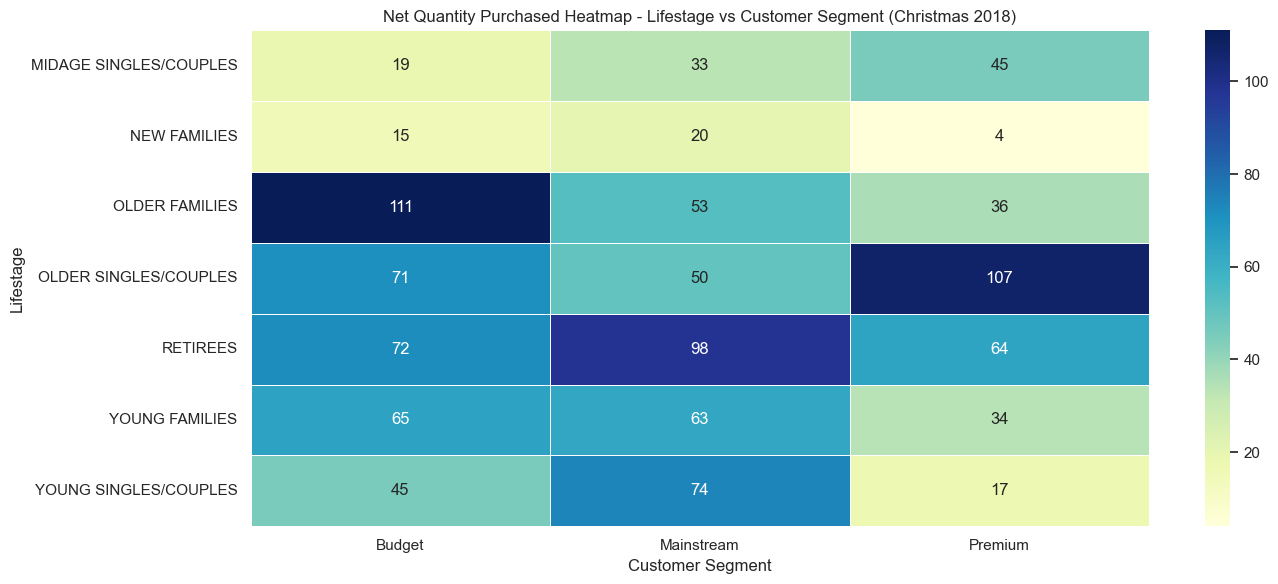

In [79]:
heat_map(Pringles_Xmas_2018, 'PREMIUM_CUSTOMER', 'LIFESTAGE', 'PROD_QTY', "Net Quantity Purchased Heatmap - Lifestage vs Customer Segment (Christmas 2018)", "Customer Segment", "Lifestage", 'YlGnBu', 0)

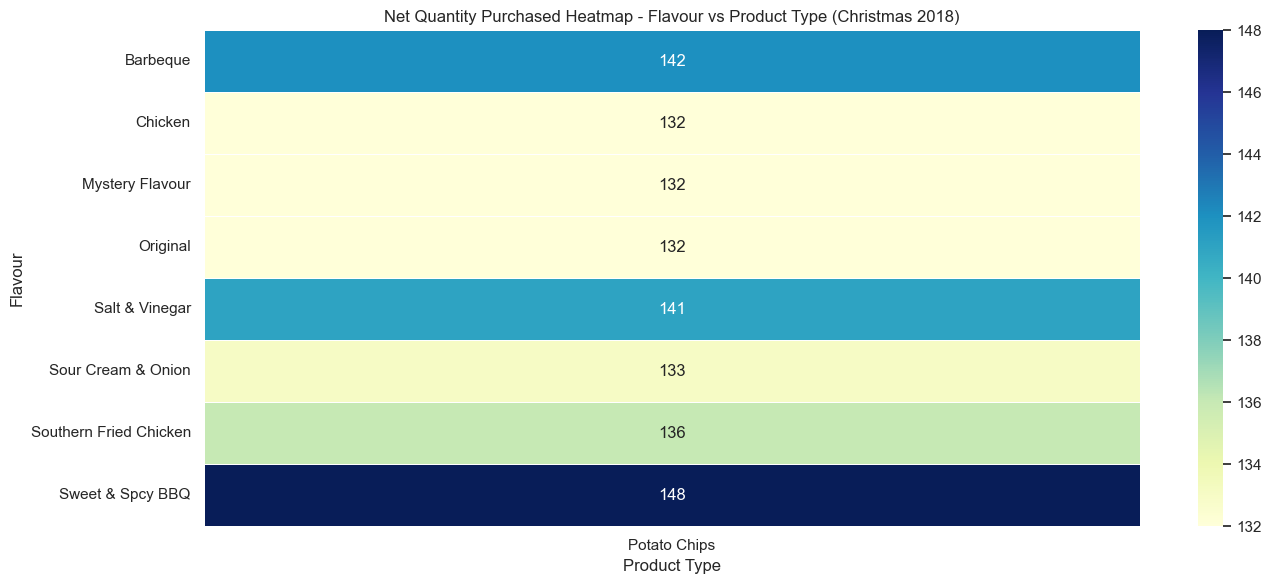

In [80]:
heat_map(Pringles_Xmas_2018, 'L2 Product Type', 'L2 Flavour', 'PROD_QTY', "Net Quantity Purchased Heatmap - Flavour vs Product Type (Christmas 2018)", "Product Type", "Flavour", 'YlGnBu', 0)

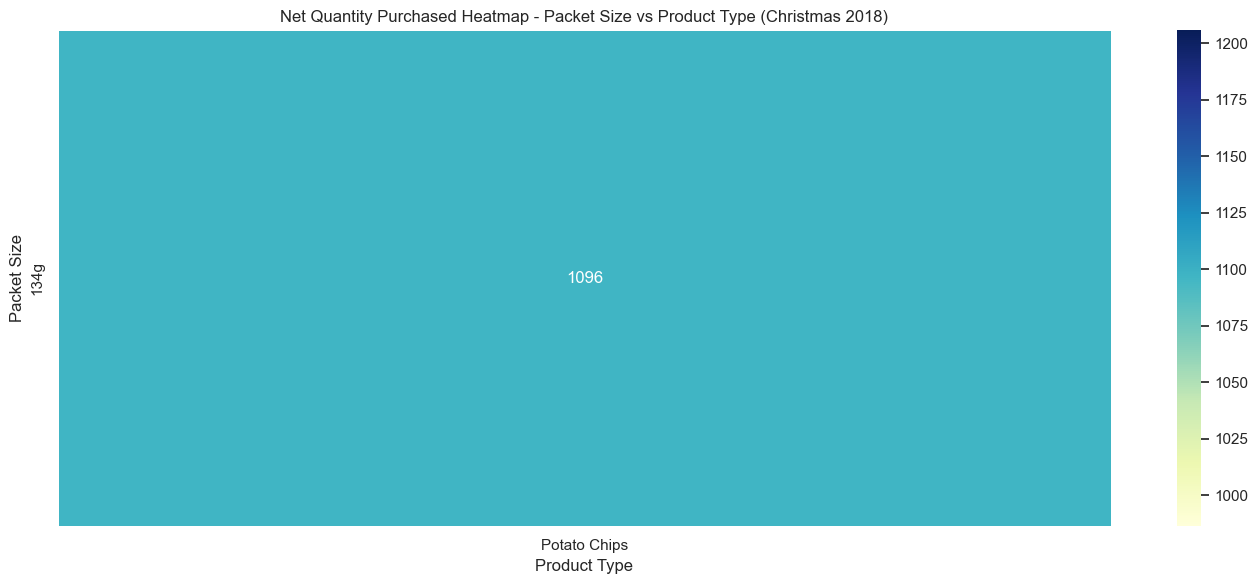

In [81]:
heat_map(Pringles_Xmas_2018, 'L2 Product Type', 'Packet Size', 'PROD_QTY', "Net Quantity Purchased Heatmap - Packet Size vs Product Type (Christmas 2018)", "Product Type", "Packet Size", 'YlGnBu', 0)

#### RRD Products - Christmas 2018

In [82]:
RRD_Xmas_2018 = christmas_2018[christmas_2018['Brand Name']=='Red Rock Deli']
RRD_Xmas_2018.shape

(421, 18)

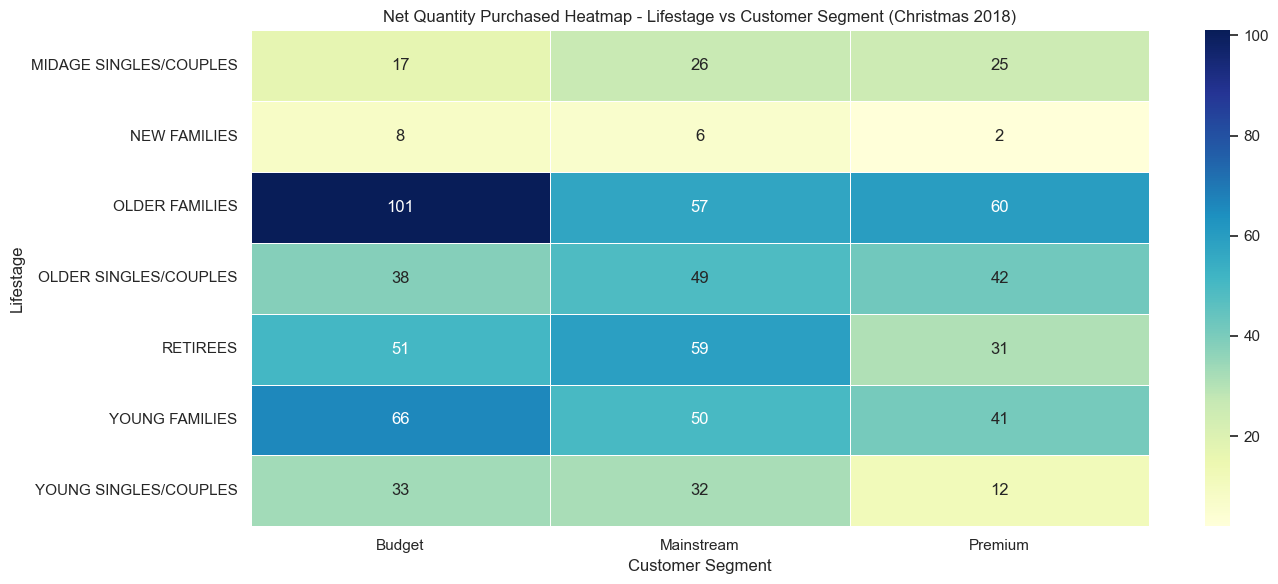

In [83]:
heat_map(RRD_Xmas_2018, 'PREMIUM_CUSTOMER', 'LIFESTAGE', 'PROD_QTY', "Net Quantity Purchased Heatmap - Lifestage vs Customer Segment (Christmas 2018)", "Customer Segment", "Lifestage", 'YlGnBu', 0)

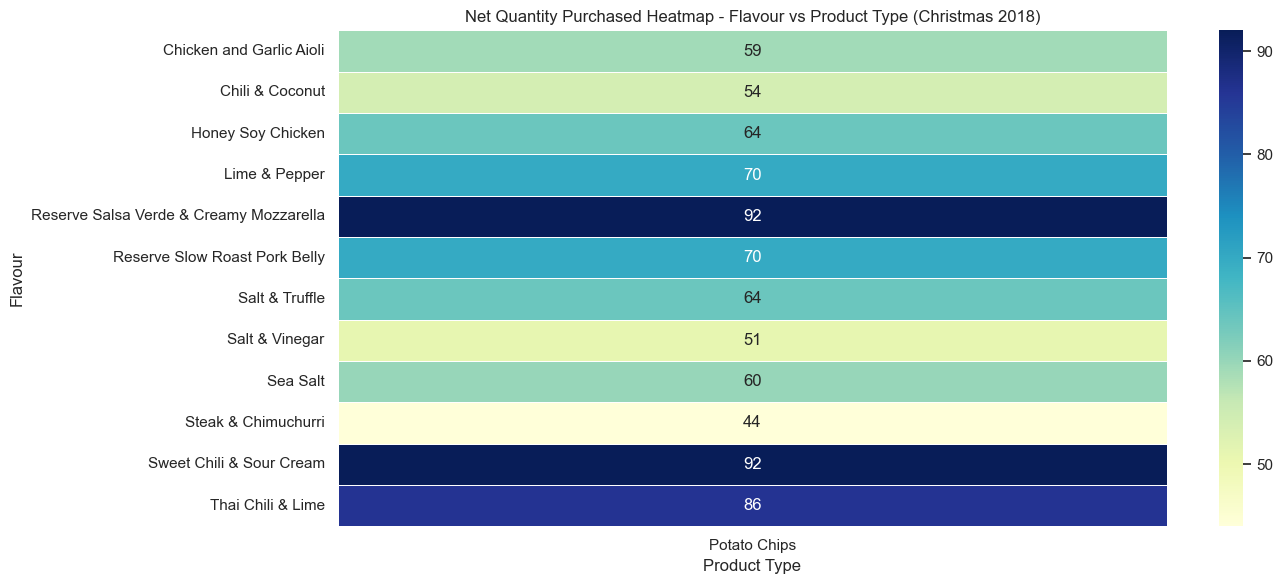

In [84]:
heat_map(RRD_Xmas_2018, 'L2 Product Type', 'L2 Flavour', 'PROD_QTY', "Net Quantity Purchased Heatmap - Flavour vs Product Type (Christmas 2018)", "Product Type", "Flavour", 'YlGnBu', 0)

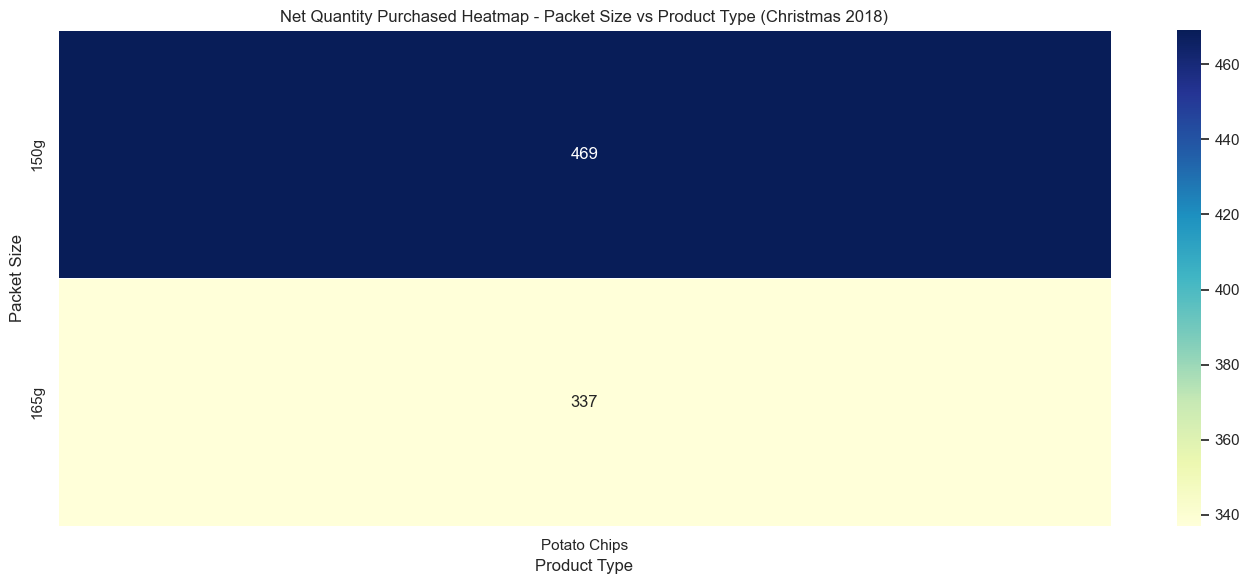

In [85]:
heat_map(RRD_Xmas_2018, 'L2 Product Type', 'Packet Size', 'PROD_QTY', "Net Quantity Purchased Heatmap - Packet Size vs Product Type (Christmas 2018)", "Product Type", "Packet Size", 'YlGnBu', 0)

### Monthly Sales/Quantity Purchased

/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/3562826950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chips['Month_Year'] = chips['DATE'].dt.to_period('M').astype(str)


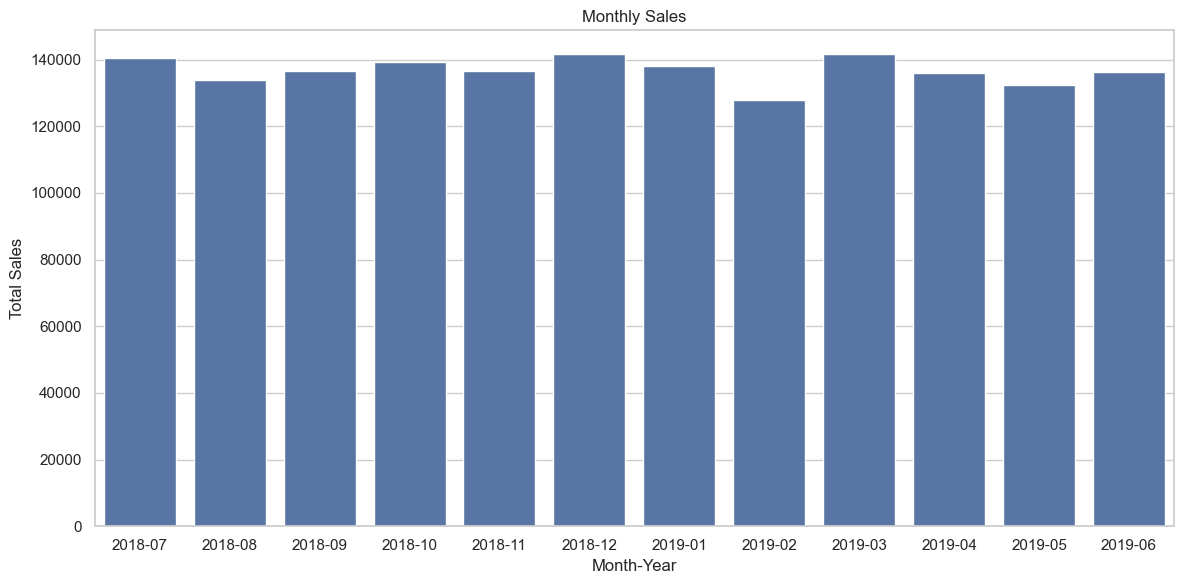

In [86]:
chips['Month_Year'] = chips['DATE'].dt.to_period('M').astype(str)
bar_chart_month(chips, 'Month_Year', 'TOT_SALES', 'Monthly Sales', "Month-Year", "Total Sales", 0)

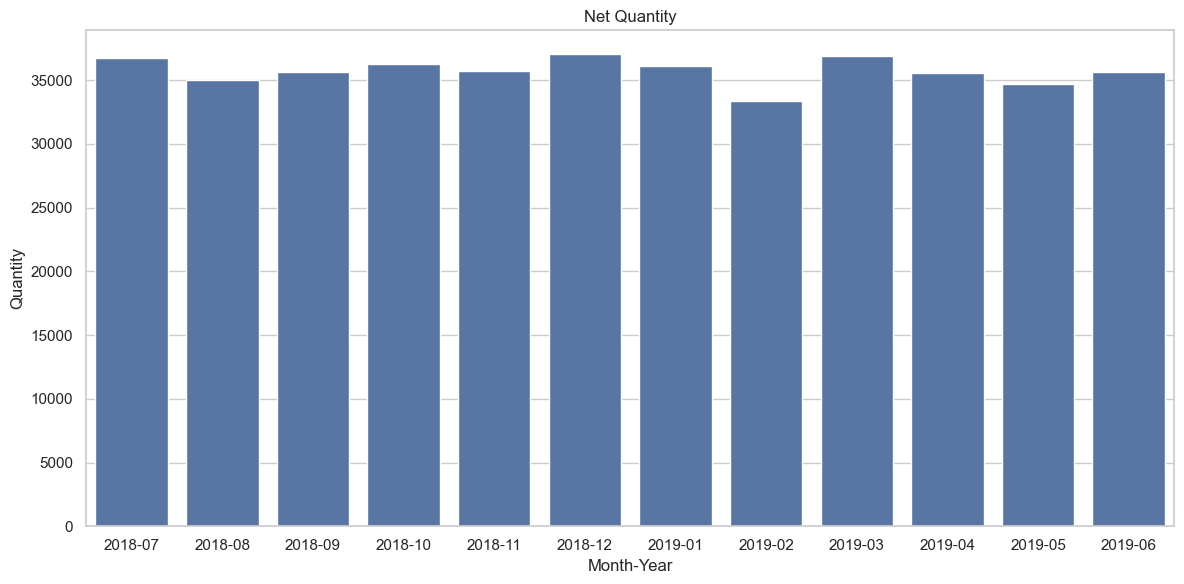

In [87]:
bar_chart_month(chips, 'Month_Year', 'PROD_QTY', 'Net Quantity', "Month-Year", "Quantity", 0)

### Categorical Fields

#### Bar Charts

/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2056992893.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x=category, y=qty_col, palette='Blues_d', ax=ax1)


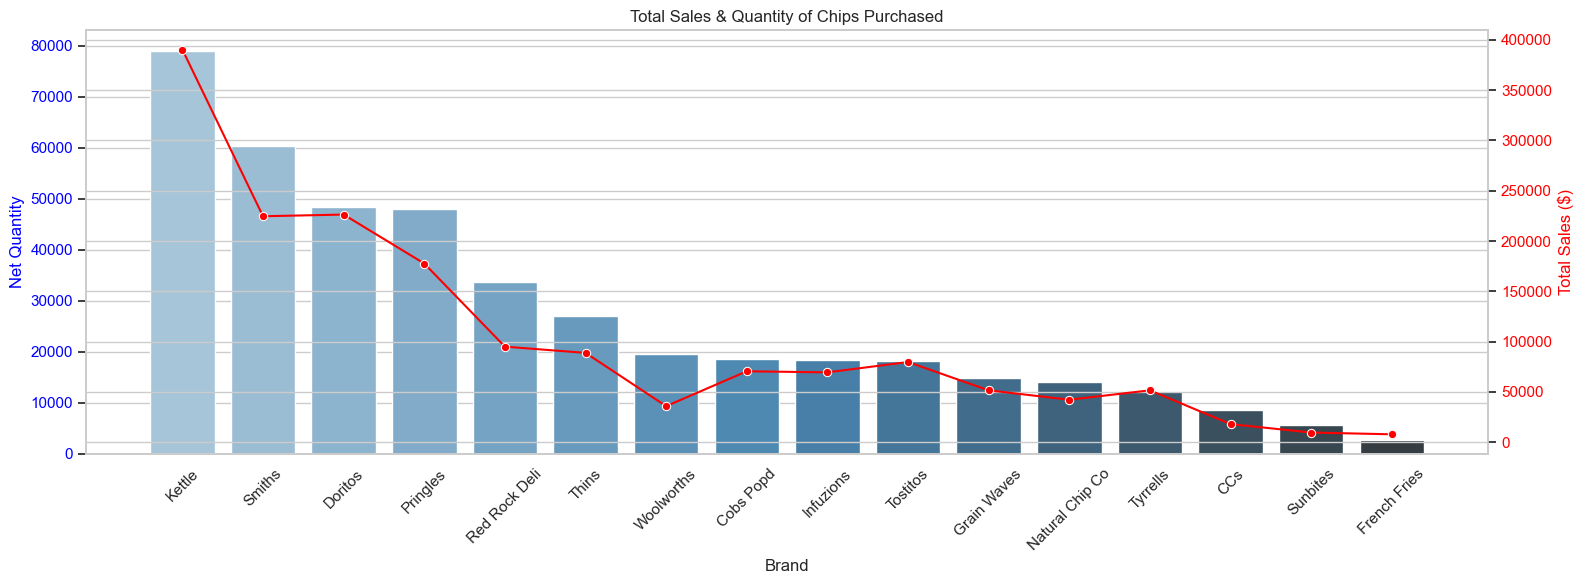

In [88]:
bar_chart_category(chips, 'Brand Name', 'Total Sales & Quantity of Chips Purchased', 'Brand', 'Net Quantity', 'Total Sales ($)', 45)

/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2056992893.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x=category, y=qty_col, palette='Blues_d', ax=ax1)


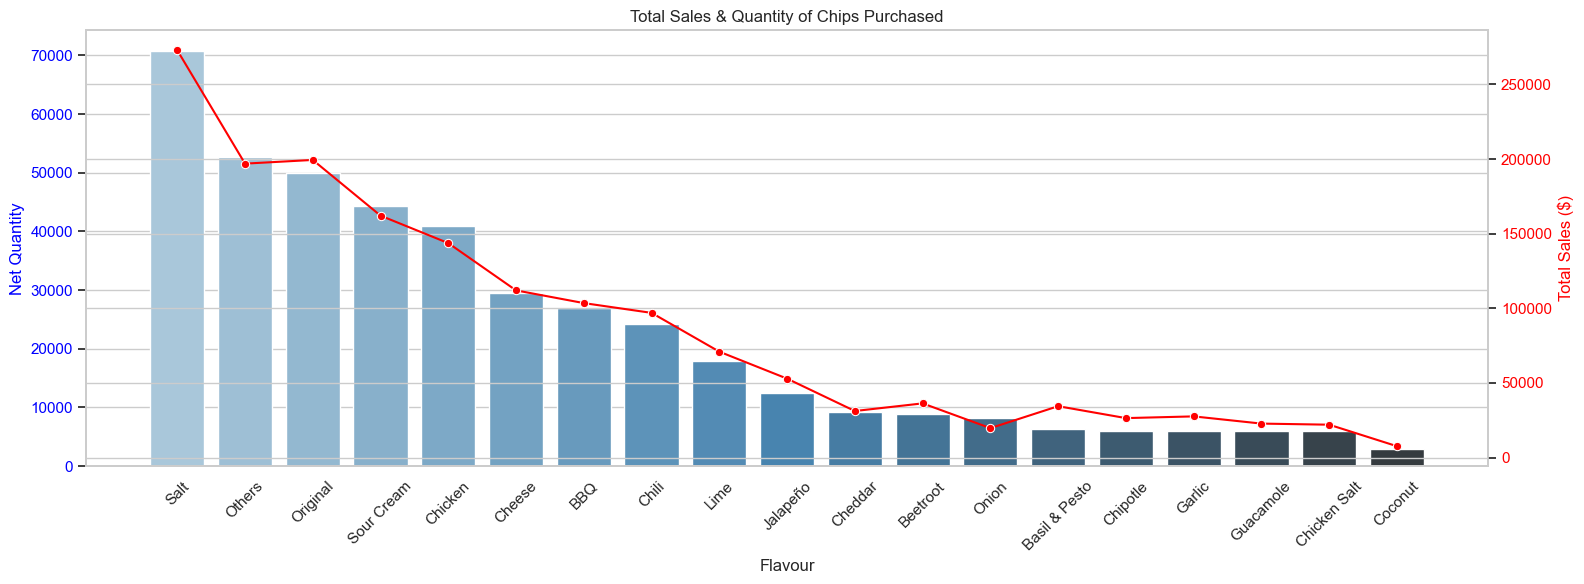

In [89]:
bar_chart_category(chips, 'L1 Flavour', 'Total Sales & Quantity of Chips Purchased', 'Flavour', 'Net Quantity', 'Total Sales ($)', 45)

/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2056992893.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x=category, y=qty_col, palette='Blues_d', ax=ax1)


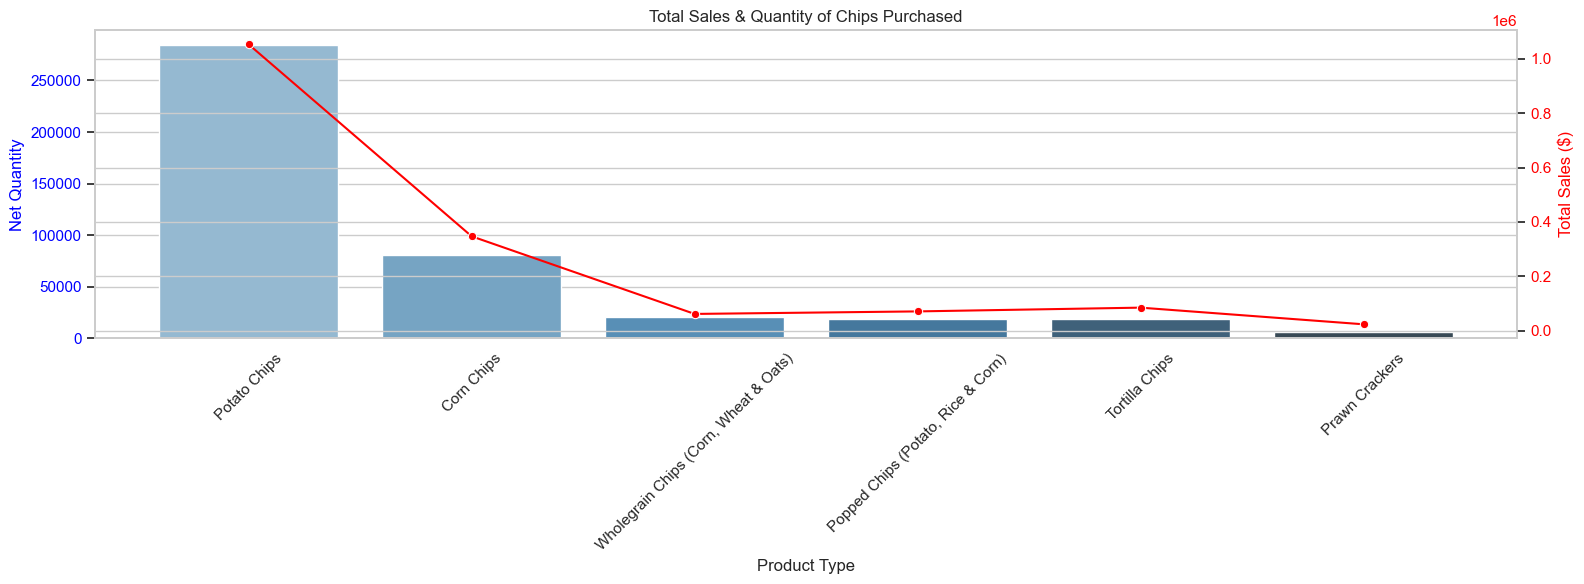

In [90]:
bar_chart_category(chips, 'L2 Product Type', 'Total Sales & Quantity of Chips Purchased', 'Product Type', 'Net Quantity', 'Total Sales ($)', 45)

/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2056992893.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x=category, y=qty_col, palette='Blues_d', ax=ax1)


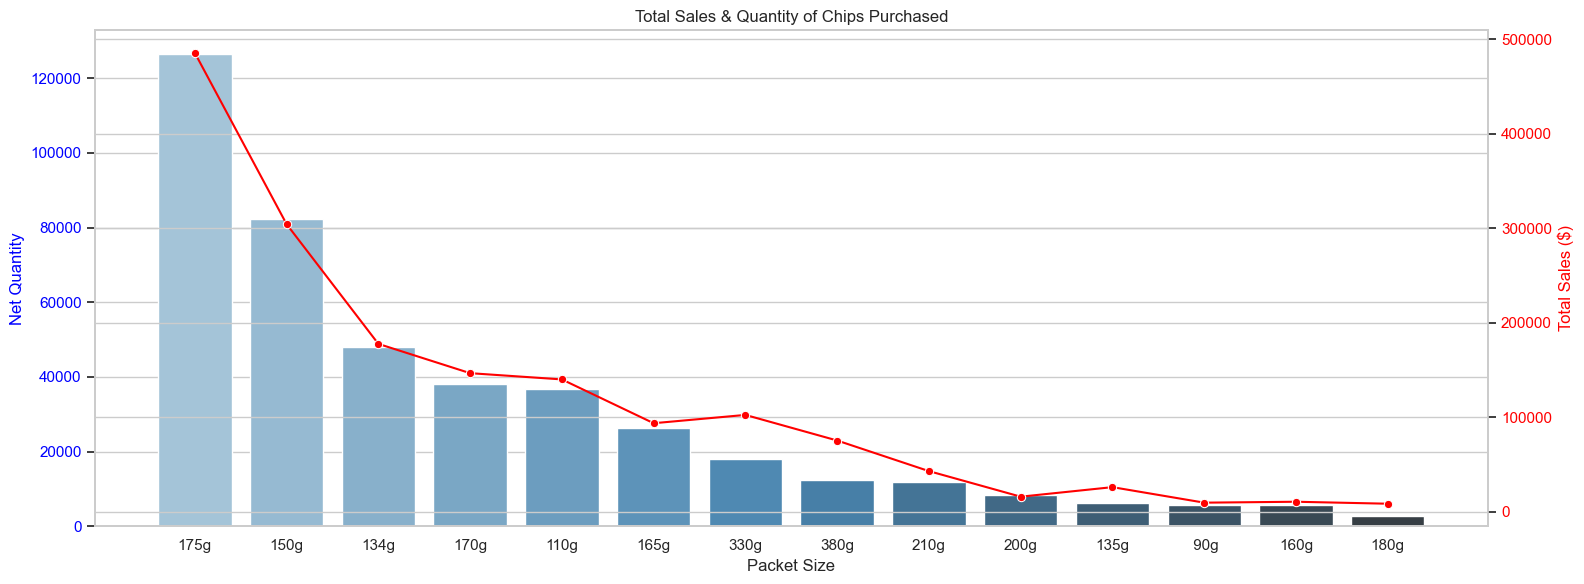

In [91]:
bar_chart_category(chips, 'Packet Size', 'Total Sales & Quantity of Chips Purchased', 'Packet Size', 'Net Quantity', 'Total Sales ($)', 0)

/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2056992893.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x=category, y=qty_col, palette='Blues_d', ax=ax1)


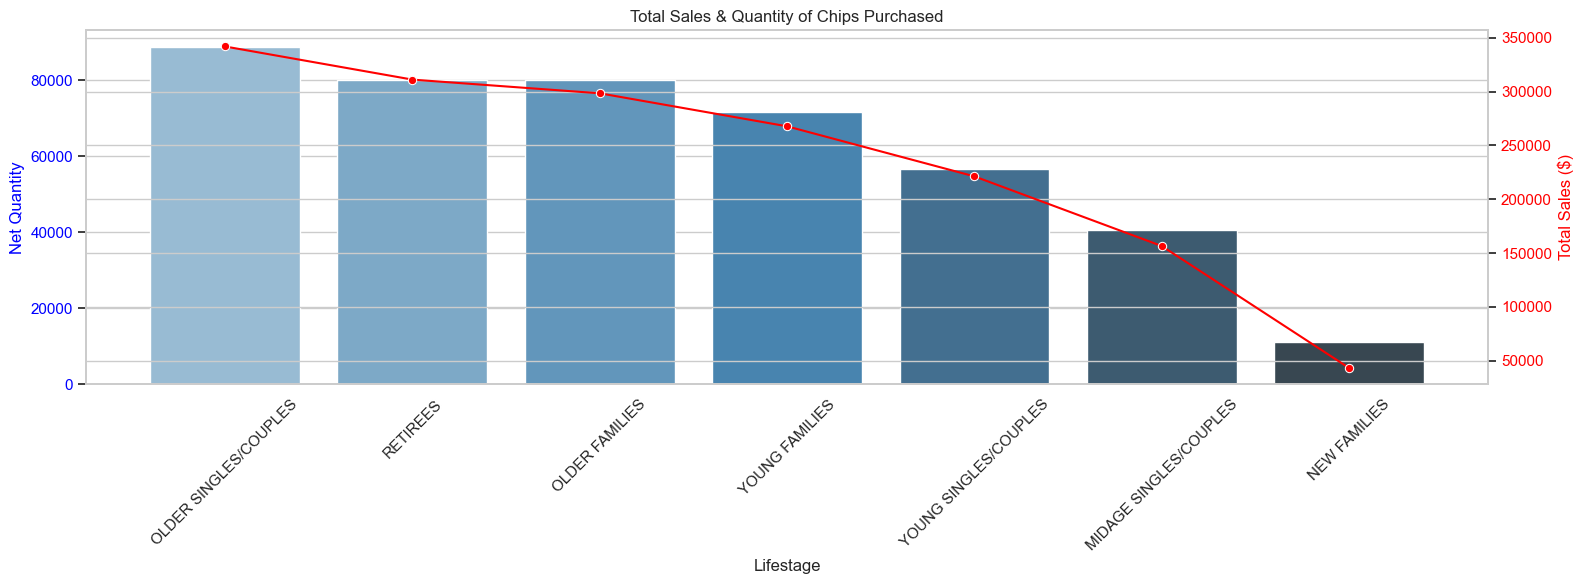

In [92]:
bar_chart_category(chips, 'LIFESTAGE', 'Total Sales & Quantity of Chips Purchased', 'Lifestage', 'Net Quantity', 'Total Sales ($)', 45)

/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2056992893.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x=category, y=qty_col, palette='Blues_d', ax=ax1)


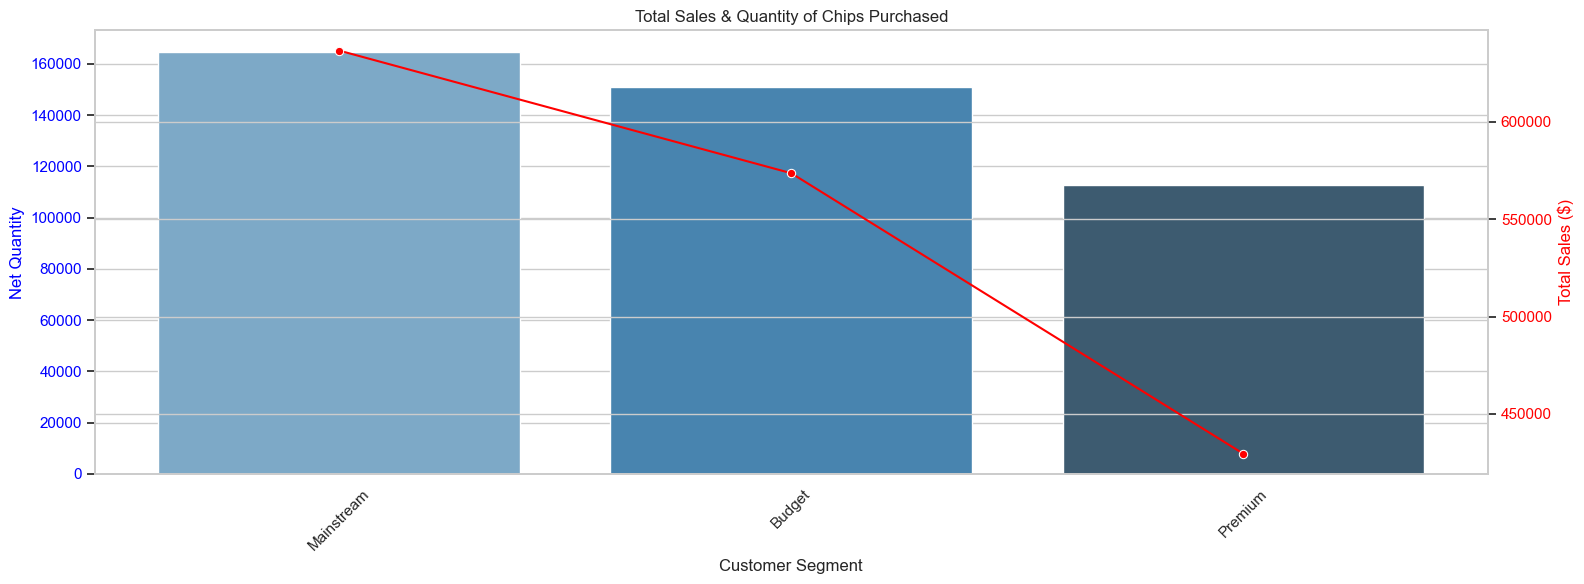

In [93]:
bar_chart_category(chips, 'PREMIUM_CUSTOMER', 'Total Sales & Quantity of Chips Purchased', 'Customer Segment', 'Net Quantity', 'Total Sales ($)', 45)

#### Heat Map - Kettle

In [94]:
kettle_chips = chips[chips['Brand Name']=='Kettle']
kettle_chips.shape

(41288, 19)

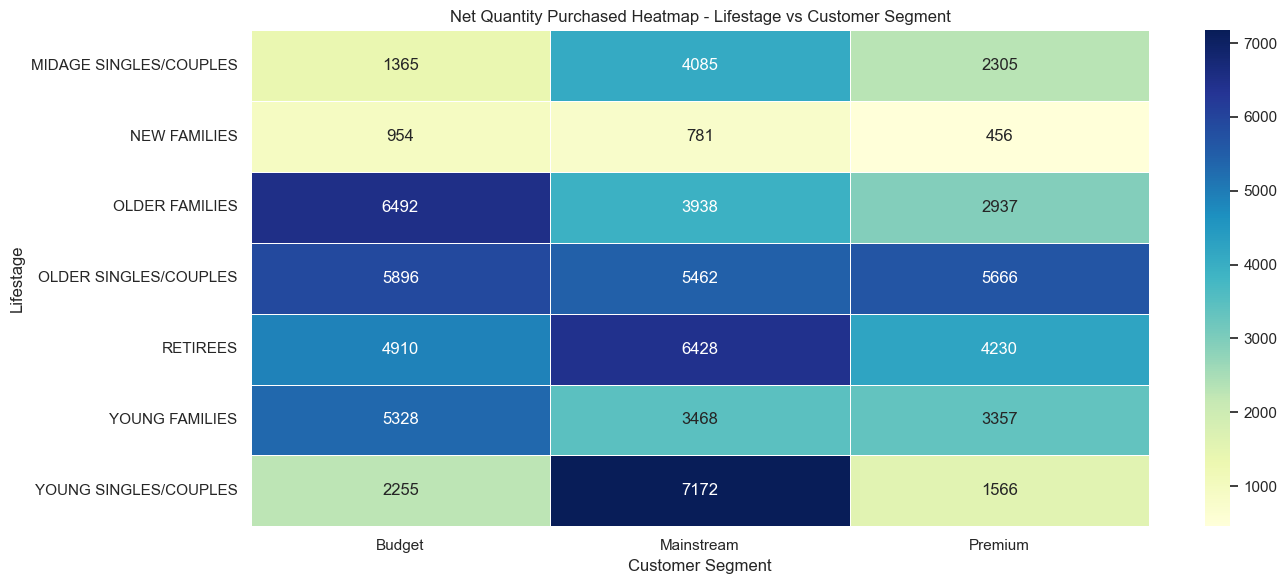

In [95]:
heat_map(kettle_chips, 'PREMIUM_CUSTOMER', 'LIFESTAGE', 'PROD_QTY', "Net Quantity Purchased Heatmap - Lifestage vs Customer Segment", "Customer Segment", "Lifestage", 'YlGnBu', 0)

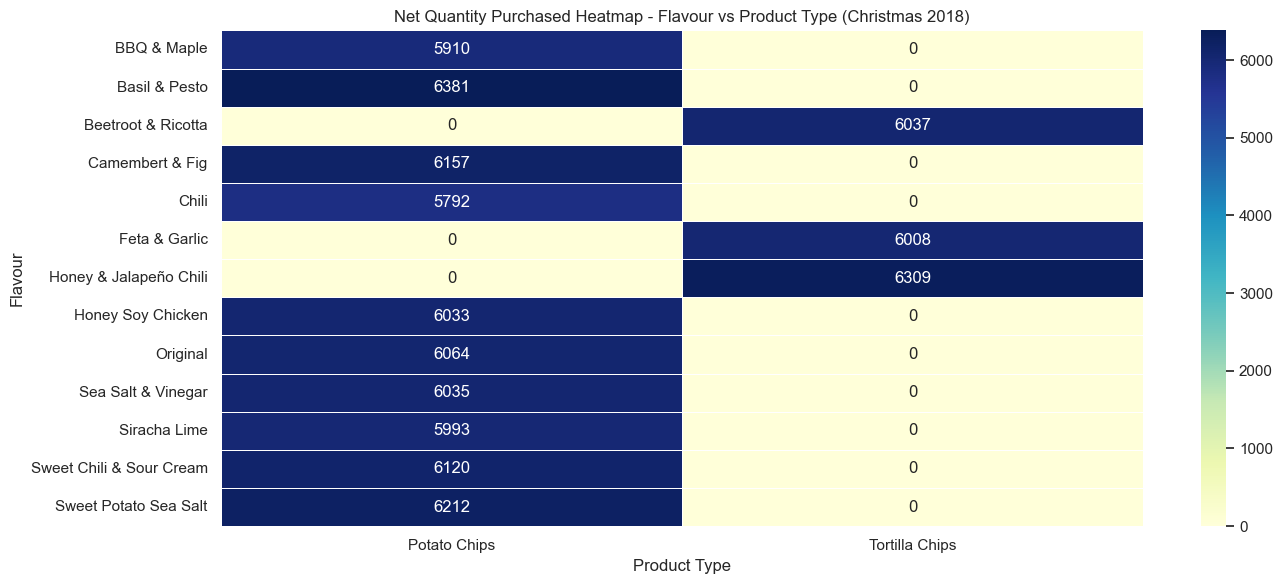

In [96]:
heat_map(kettle_chips, 'L2 Product Type', 'L2 Flavour', 'PROD_QTY', "Net Quantity Purchased Heatmap - Flavour vs Product Type (Christmas 2018)", "Product Type", "Flavour", 'YlGnBu', 0)

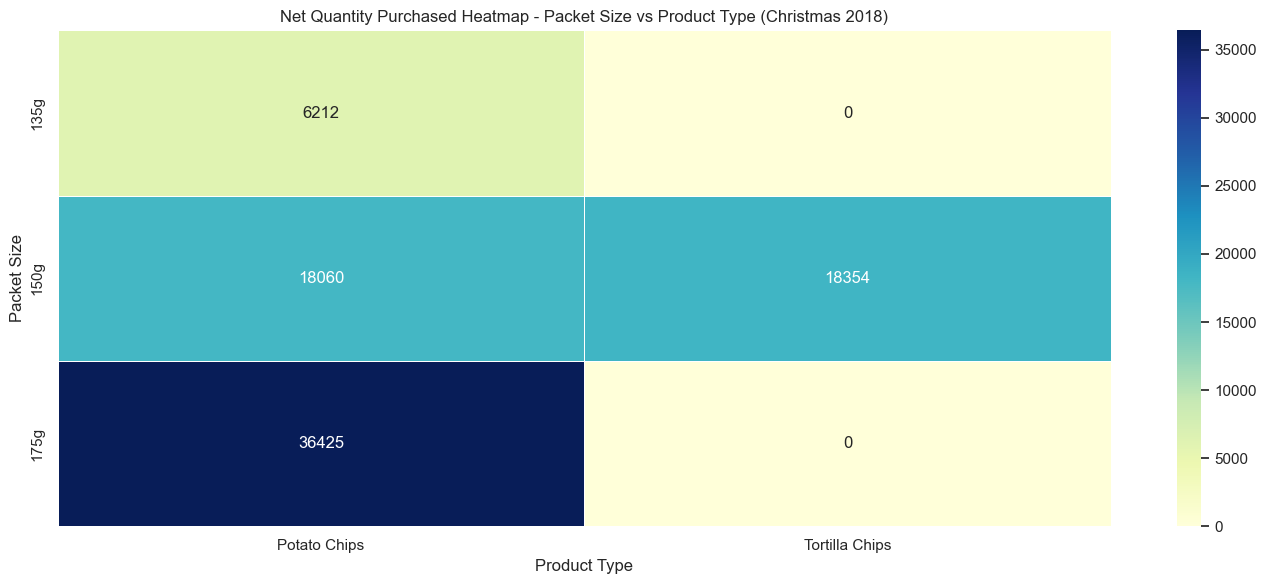

In [97]:
heat_map(kettle_chips, 'L2 Product Type', 'Packet Size', 'PROD_QTY', "Net Quantity Purchased Heatmap - Packet Size vs Product Type (Christmas 2018)", "Product Type", "Packet Size", 'YlGnBu', 0)

## Summary & Recommendations

### Brand Summary - Chips

In [98]:
chips_summary = brand_summary(chips,mode_percent)
chips_summary.head(30)

Brand Name  Total Sales ($)  Quantity Ordered  Total Transactions  \
0            Kettle         390240.0             79051               41288   
1           Doritos         226330.0             48331               25224   
2            Smiths         224654.0             60337               31822   
3          Pringles         177656.0             48019               25102   
4     Red Rock Deli          95046.0             33646               17779   
5             Thins          88852.0             26929               14075   
6          Tostitos          79790.0             18134                9471   
7         Cobs Popd          70570.0             18571                9693   
8         Infuzions          69494.0             18290                9560   
9          Tyrrells          51647.0             12298                6442   
10      Grain Waves          51617.0             14726                7740   
11  Natural Chip Co          42318.0             14106                7469   
12       Woolworths          35889.0             19461               10320   
13              CCs          18079.0              8609                4551   
14         Sunbites           9676.0              5692                3008   
15     French Fries           7929.0              2643                1418   

    Average Sales ($)  Average Quantity Lifestage (Most Ordered)  \
0                 9.0               2.0    OLDER SINGLES/COUPLES   
1                 9.0               2.0    OLDER SINGLES/COUPLES   
2                 7.0               2.0           OLDER FAMILIES   
3                 7.0               2.0    OLDER SINGLES/COUPLES   
4                 5.0               2.0           OLDER FAMILIES   
5                 6.0               2.0    OLDER SINGLES/COUPLES   
6                 8.0               2.0    OLDER SINGLES/COUPLES   
7                 7.0               2.0    OLDER SINGLES/COUPLES   
8                 7.0               2.0    OLDER SINGLES/COUPLES   
9                 8.0               2.0    OLDER SINGLES/COUPLES   
10                7.0               2.0    OLDER SINGLES/COUPLES   
11                6.0               2.0           OLDER FAMILIES   
12                3.0               2.0           OLDER FAMILIES   
13                4.0               2.0           OLDER FAMILIES   
14                3.0               2.0           OLDER FAMILIES   
15                6.0               2.0    OLDER SINGLES/COUPLES   

    Lifestage (%) Customer Segment (Most Ordered)  Customer Segment (%)  \
0            21.0                      Mainstream                  40.0   
1            21.0                      Mainstream                  40.0   
2            20.0                      Mainstream                  37.0   
3            21.0                      Mainstream                  39.0   
4            22.0                          Budget                  36.0   
5            21.0                      Mainstream                  39.0   
6            22.0                      Mainstream                  39.0   
7            21.0                      Mainstream                  40.0   
8            21.0                      Mainstream                  40.0   
9            21.0                      Mainstream                  40.0   
10           21.0                      Mainstream                  39.0   
11           21.0                          Budget                  37.0   
12           22.0                          Budget                  38.0   
13           21.0                          Budget                  37.0   
14           21.0                          Budget                  38.0   
15           20.0                          Budget                  38.0   

           Flavour (Most Ordered)  Flavour (%)  \
0                   Basil & Pesto          8.0   
1                  Cheese Supreme         25.0   
2                        Original         30.0   
3                        Barbeque         13.0   

In [99]:
# Categorical Fields - mode with % population
lf_ms,lf_ms_pct = mode_percent(chips['LIFESTAGE'])
cs_ms,cs_ms_pct = mode_percent(chips['PREMIUM_CUSTOMER'])
fl_ms,fl_ms_pct = mode_percent(chips['L2 Flavour'])
pt_ms,pt_ms_pct = mode_percent(chips['L2 Product Type'])
ps_ms,ps_ms_pct = mode_percent(chips['Packet Size'])

print (f"* Most Ordered Lifestage is '{lf_ms}' with population of {lf_ms_pct}%")
print (f"* Most Ordered Customer Segment is '{cs_ms}' with population of {cs_ms_pct}%")
print (f"* Most Ordered Flavour is '{fl_ms}' with population of {fl_ms_pct}%")
print (f"* Most Ordered Product Type is '{pt_ms}' with population of {pt_ms_pct}%")
print (f"* Most Ordered Packet Size is '{ps_ms}' with population of {ps_ms_pct}%")

* Most Ordered Lifestage is 'OLDER SINGLES/COUPLES' with population of 20.59%
* Most Ordered Customer Segment is 'Mainstream' with population of 38.52%
* Most Ordered Flavour is 'Original' with population of 11.66%
* Most Ordered Product Type is 'Potato Chips' with population of 66.4%
* Most Ordered Packet Size is '175g' with population of 29.51%


/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2497404219.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Brand Name', y='Total Sales ($)', palette='viridis', ax=axes[0])
/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2497404219.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Brand Name', y='Avg Spend per Transaction', palette='coolwarm', ax=axes[1])


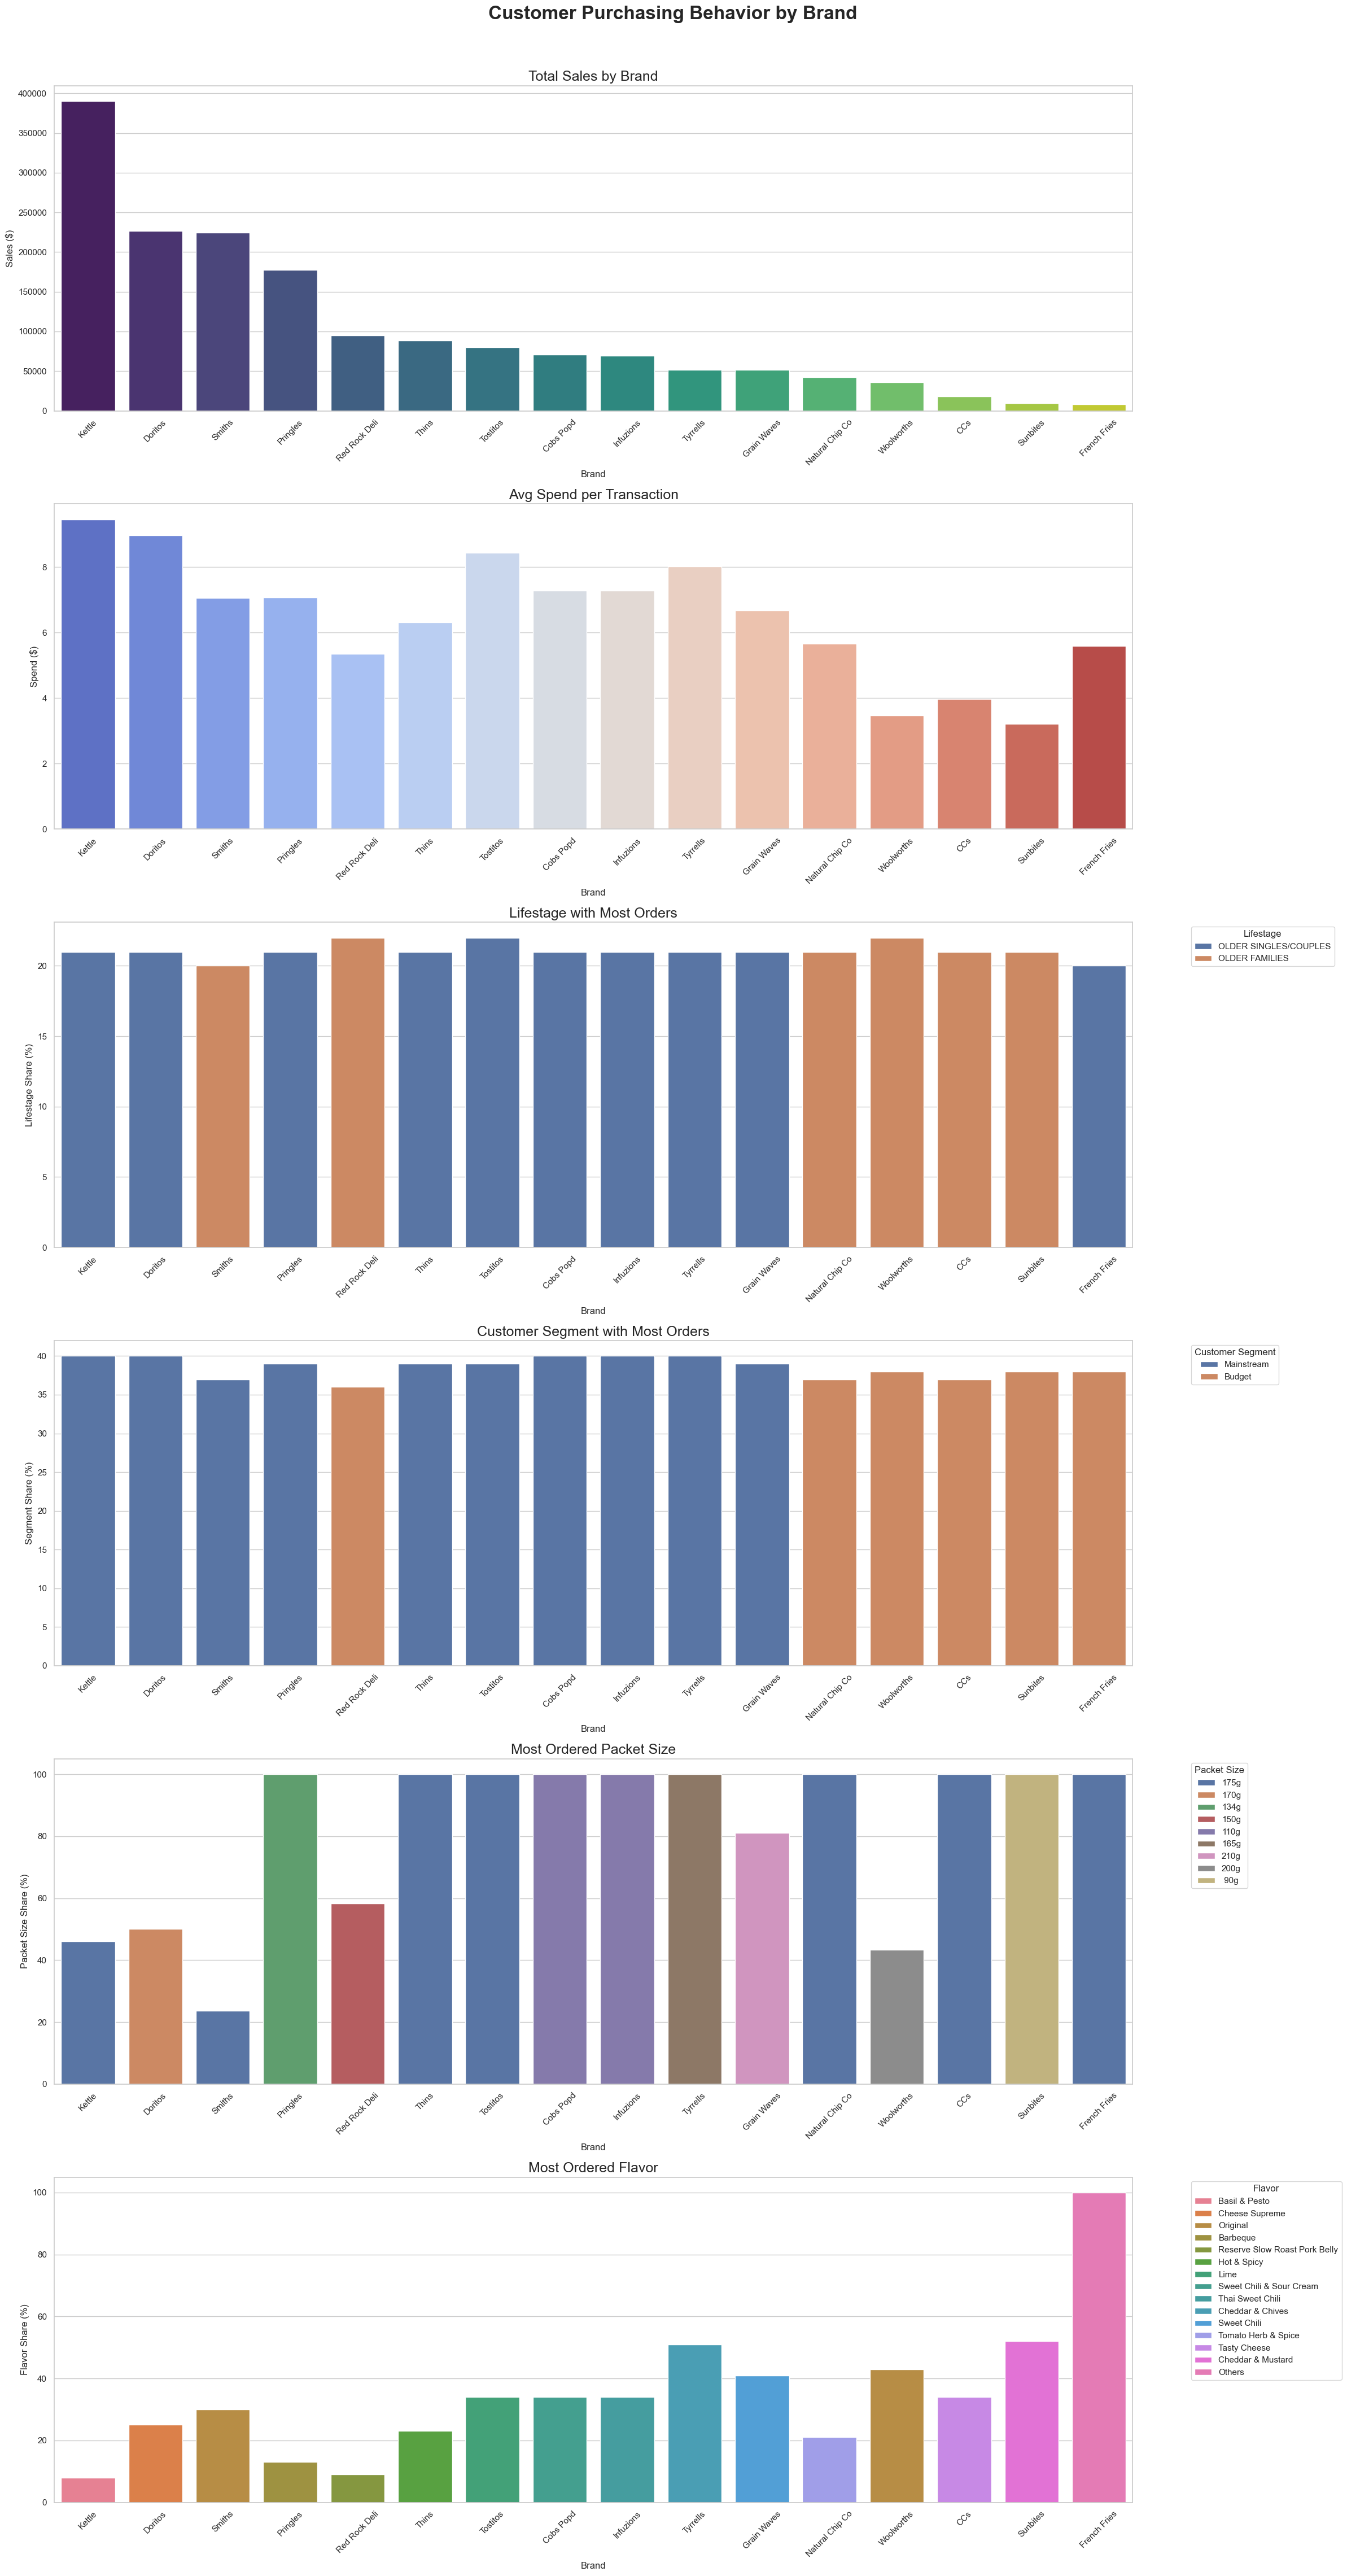

In [100]:
customer_behavior_dashboard(chips_summary)

### Brand Summary: Chips -> christmas_2018

In [101]:
christmas_2018_summary = brand_summary(christmas_2018,mode_percent)
christmas_2018_summary.head(30)

Brand Name  Total Sales ($)  Quantity Ordered  Total Transactions  \
0            Kettle           8714.0              1762                 908   
1           Doritos           5415.0              1148                 588   
2            Smiths           5086.0              1362                 719   
3          Pringles           4055.0              1096                 568   
4             Thins           2356.0               714                 368   
5     Red Rock Deli           2277.0               806                 421   
6          Tostitos           1800.0               409                 214   
7         Cobs Popd           1706.0               449                 235   
8         Infuzions           1615.0               425                 218   
9       Grain Waves           1245.0               356                 188   
10         Tyrrells           1218.0               290                 152   
11  Natural Chip Co           1041.0               347                 183   
12       Woolworths            855.0               463                 243   
13              CCs            521.0               248                 128   
14         Sunbites            296.0               174                  93   
15     French Fries            171.0                57                  31   

    Average Sales ($)  Average Quantity Lifestage (Most Ordered)  \
0                10.0               2.0                 RETIREES   
1                 9.0               2.0                 RETIREES   
2                 7.0               2.0           OLDER FAMILIES   
3                 7.0               2.0                 RETIREES   
4                 6.0               2.0    OLDER SINGLES/COUPLES   
5                 5.0               2.0           OLDER FAMILIES   
6                 8.0               2.0    OLDER SINGLES/COUPLES   
7                 7.0               2.0                 RETIREES   
8                 7.0               2.0    OLDER SINGLES/COUPLES   
9                 7.0               2.0                 RETIREES   
10                8.0               2.0           OLDER FAMILIES   
11                6.0               2.0           OLDER FAMILIES   
12                4.0               2.0           YOUNG FAMILIES   
13                4.0               2.0           OLDER FAMILIES   
14                3.0               2.0    OLDER SINGLES/COUPLES   
15                6.0               2.0    OLDER SINGLES/COUPLES   

    Lifestage (%) Customer Segment (Most Ordered)  Customer Segment (%)  \
0            22.0                      Mainstream                  42.0   
1            20.0                      Mainstream                  43.0   
2            21.0                      Mainstream                  39.0   
3            22.0                          Budget                  36.0   
4            24.0                      Mainstream                  42.0   
5            27.0                          Budget                  39.0   
6            24.0                      Mainstream                  39.0   
7            22.0                      Mainstream                  41.0   
8            24.0                      Mainstream                  37.0   
9            25.0                      Mainstream                  43.0   
10           20.0                      Mainstream                  36.0   
11           27.0                          Budget                  37.0   
12           23.0                      Mainstream                  39.0   
13           22.0                      Mainstream                  41.0   
14           26.0                          Budget                  46.0   
15           26.0                          Budget                  48.0   

      Flavour (Most Ordered)  Flavour (%)  \
0            Camembert & Fig          9.0   
1             Cheese Supreme         25.0   
2                   Original         31.0   
3           Sweet & Spcy BBQ         13.0   
4           Seasoned Chi

In [102]:
# Categorical Fields - mode with % population
lf_ms,lf_ms_pct = mode_percent(christmas_2018['LIFESTAGE'])
cs_ms,cs_ms_pct = mode_percent(christmas_2018['PREMIUM_CUSTOMER'])
fl_ms,fl_ms_pct = mode_percent(christmas_2018['L2 Flavour'])
pt_ms,pt_ms_pct = mode_percent(christmas_2018['L2 Product Type'])
ps_ms,ps_ms_pct = mode_percent(christmas_2018['Packet Size'])

print (f"* Most Ordered Lifestage is '{lf_ms}' with population of {lf_ms_pct}%")
print (f"* Most Ordered Customer Segment is '{cs_ms}' with population of {cs_ms_pct}%")
print (f"* Most Ordered Flavour is '{fl_ms}' with population of {fl_ms_pct}%")
print (f"* Most Ordered Product Type is '{pt_ms}' with population of {pt_ms_pct}%")
print (f"* Most Ordered Packet Size is '{ps_ms}' with population of {ps_ms_pct}%")

* Most Ordered Lifestage is 'OLDER SINGLES/COUPLES' with population of 20.14%
* Most Ordered Customer Segment is 'Mainstream' with population of 39.26%
* Most Ordered Flavour is 'Original' with population of 11.91%
* Most Ordered Product Type is 'Potato Chips' with population of 66.18%
* Most Ordered Packet Size is '175g' with population of 30.3%


/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2497404219.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Brand Name', y='Total Sales ($)', palette='viridis', ax=axes[0])
/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2497404219.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Brand Name', y='Avg Spend per Transaction', palette='coolwarm', ax=axes[1])


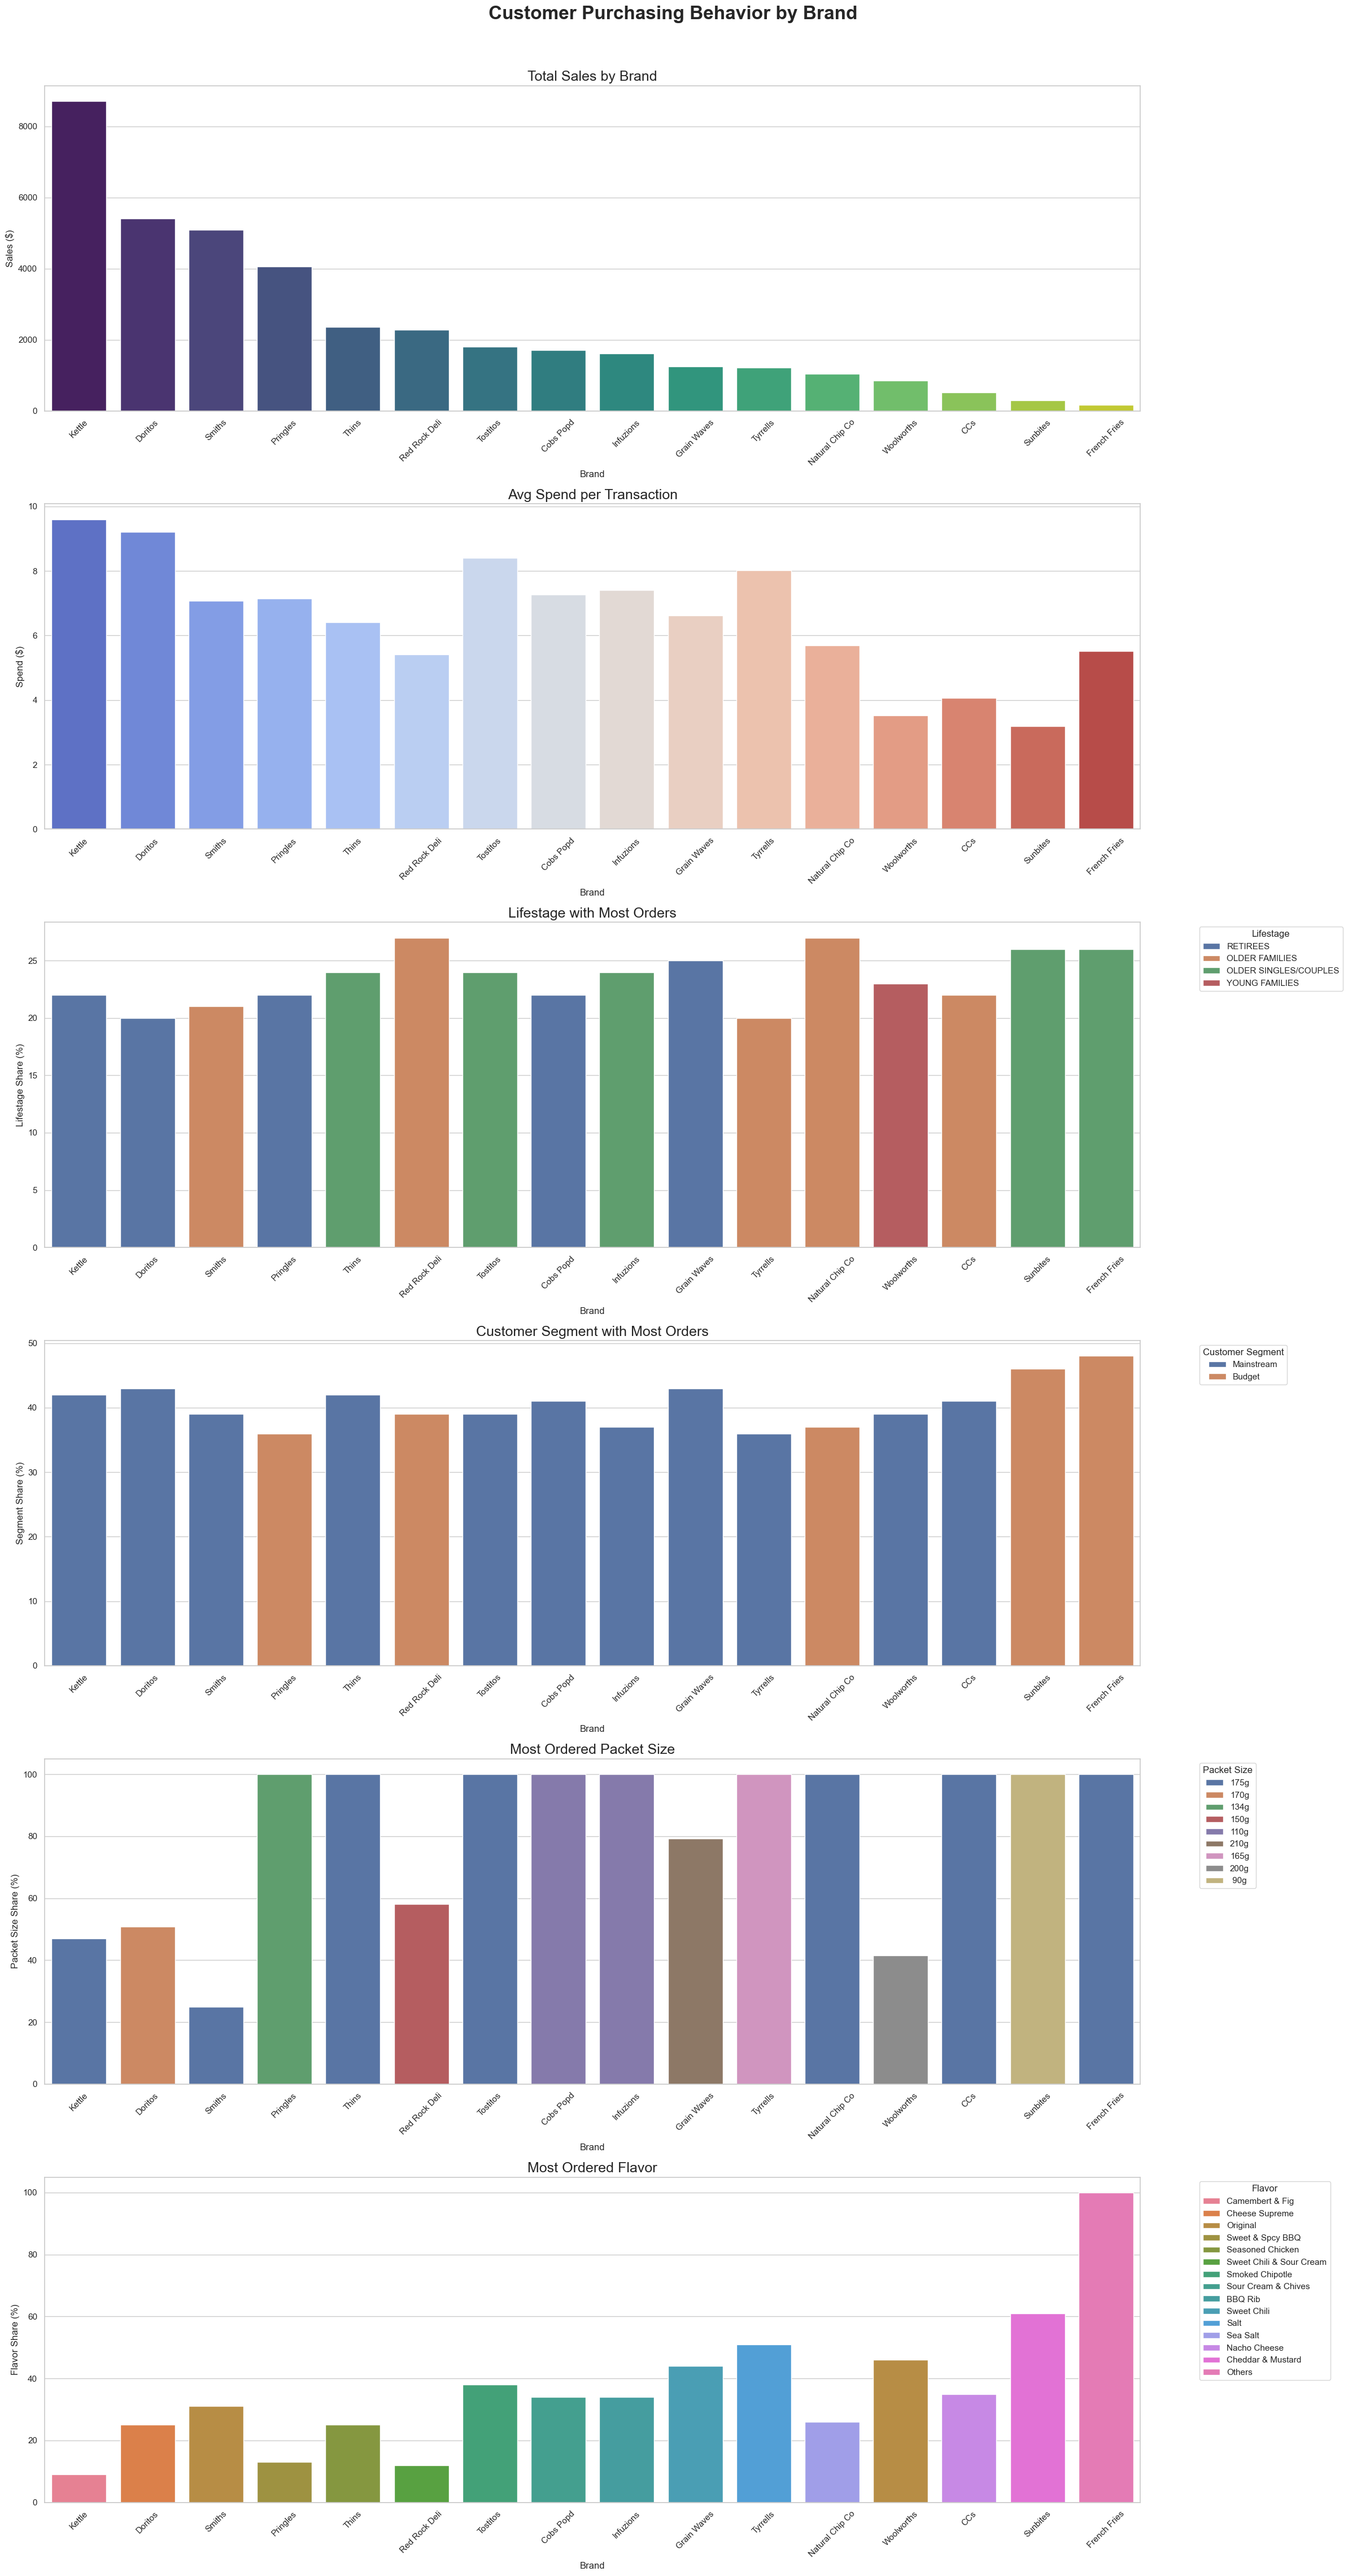

In [103]:
customer_behavior_dashboard(christmas_2018_summary)

### Other Products (Excluding Chips)

In [104]:
other_products_summary = brand_summary(other_products,mode_percent)
other_products_summary.head(30)

Brand Name  Total Sales ($)  Quantity Ordered  Total Transactions  \
0   Old El Paso          90785.0             17805                9324   
1      Twisties          81522.0             18118                9454   
2      Cheezels          40030.0              8747                4603   
3     Infuzions          29553.0              8829                4641   
4       Cheetos          16885.0              5530                2927   
5       Doritos          14261.0              5485                2921   
6    Woolworths          13454.0              8395                4437   
7  Burger Rings           6831.0              2970                1564   

   Average Sales ($)  Average Quantity Lifestage (Most Ordered)  \
0               10.0               2.0    OLDER SINGLES/COUPLES   
1                9.0               2.0    OLDER SINGLES/COUPLES   
2                9.0               2.0    OLDER SINGLES/COUPLES   
3                6.0               2.0    OLDER SINGLES/COUPLES   
4                6.0               2.0           OLDER FAMILIES   
5                5.0               2.0           OLDER FAMILIES   
6                3.0               2.0           OLDER FAMILIES   
7                4.0               2.0           OLDER FAMILIES   

   Lifestage (%) Customer Segment (Most Ordered)  Customer Segment (%)  \
0           21.0                      Mainstream                  40.0   
1           21.0                      Mainstream                  40.0   
2           21.0                      Mainstream                  38.0   
3           21.0                      Mainstream                  38.0   
4           21.0                      Mainstream                  38.0   
5           22.0                          Budget                  38.0   
6           21.0                      Mainstream                  36.0   
7           23.0                          Budget                  37.0   

  Flavour (Most Ordered)  Flavour (%) Product Type (Most Ordered)  \
0                 Others        100.0                       Salsa   
1                Chicken         34.0                  Corn Puffs   
2                 Others        100.0                Cheese Rings   
3     Sour Cream & Herbs         68.0               Veggie Straws   
4   Cheese & Bacon Balls         51.0                  Corn Puffs   
5                 Others        100.0                       Salsa   
6                 Others         66.0                       Salsa   
7                 Others        100.0                  Corn Rings   

   Product Type (%) Packet Size (Most Ordered)  Packet Size (%)  
0             100.0                       300g           100.00  
1             100.0                       270g            66.48  
2             100.0                       330g            68.41  
3              68.0                       110g            67.53  
4             100.0                       190g            50.53  
5             100.0                       300g           100.00  
6              66.0                       300g            65.83  
7             100.0                       220g           100.00

In [105]:
# Categorical Fields - mode with % population
lf_ms,lf_ms_pct = mode_percent(other_products['LIFESTAGE'])
cs_ms,cs_ms_pct = mode_percent(other_products['PREMIUM_CUSTOMER'])
fl_ms,fl_ms_pct = mode_percent(other_products['L2 Flavour'])
pt_ms,pt_ms_pct = mode_percent(other_products['L2 Product Type'])
ps_ms,ps_ms_pct = mode_percent(other_products['Packet Size'])

print (f"* Most Ordered Lifestage is '{lf_ms}' with population of {lf_ms_pct}%")
print (f"* Most Ordered Customer Segment is '{cs_ms}' with population of {cs_ms_pct}%")
print (f"* Most Ordered Flavour is '{fl_ms}' with population of {fl_ms_pct}%")
print (f"* Most Ordered Product Type is '{pt_ms}' with population of {pt_ms_pct}%")
print (f"* Most Ordered Packet Size is '{ps_ms}' with population of {ps_ms_pct}%")

* Most Ordered Lifestage is 'OLDER SINGLES/COUPLES' with population of 20.45%
* Most Ordered Customer Segment is 'Mainstream' with population of 38.47%
* Most Ordered Flavour is 'Others' with population of 57.14%
* Most Ordered Product Type is 'Salsa' with population of 38.04%
* Most Ordered Packet Size is '300g' with population of 38.04%


/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2497404219.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Brand Name', y='Total Sales ($)', palette='viridis', ax=axes[0])
/var/folders/ss/8rq0ggbx6bv7040x7p17thsr0000gn/T/ipykernel_2302/2497404219.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Brand Name', y='Avg Spend per Transaction', palette='coolwarm', ax=axes[1])


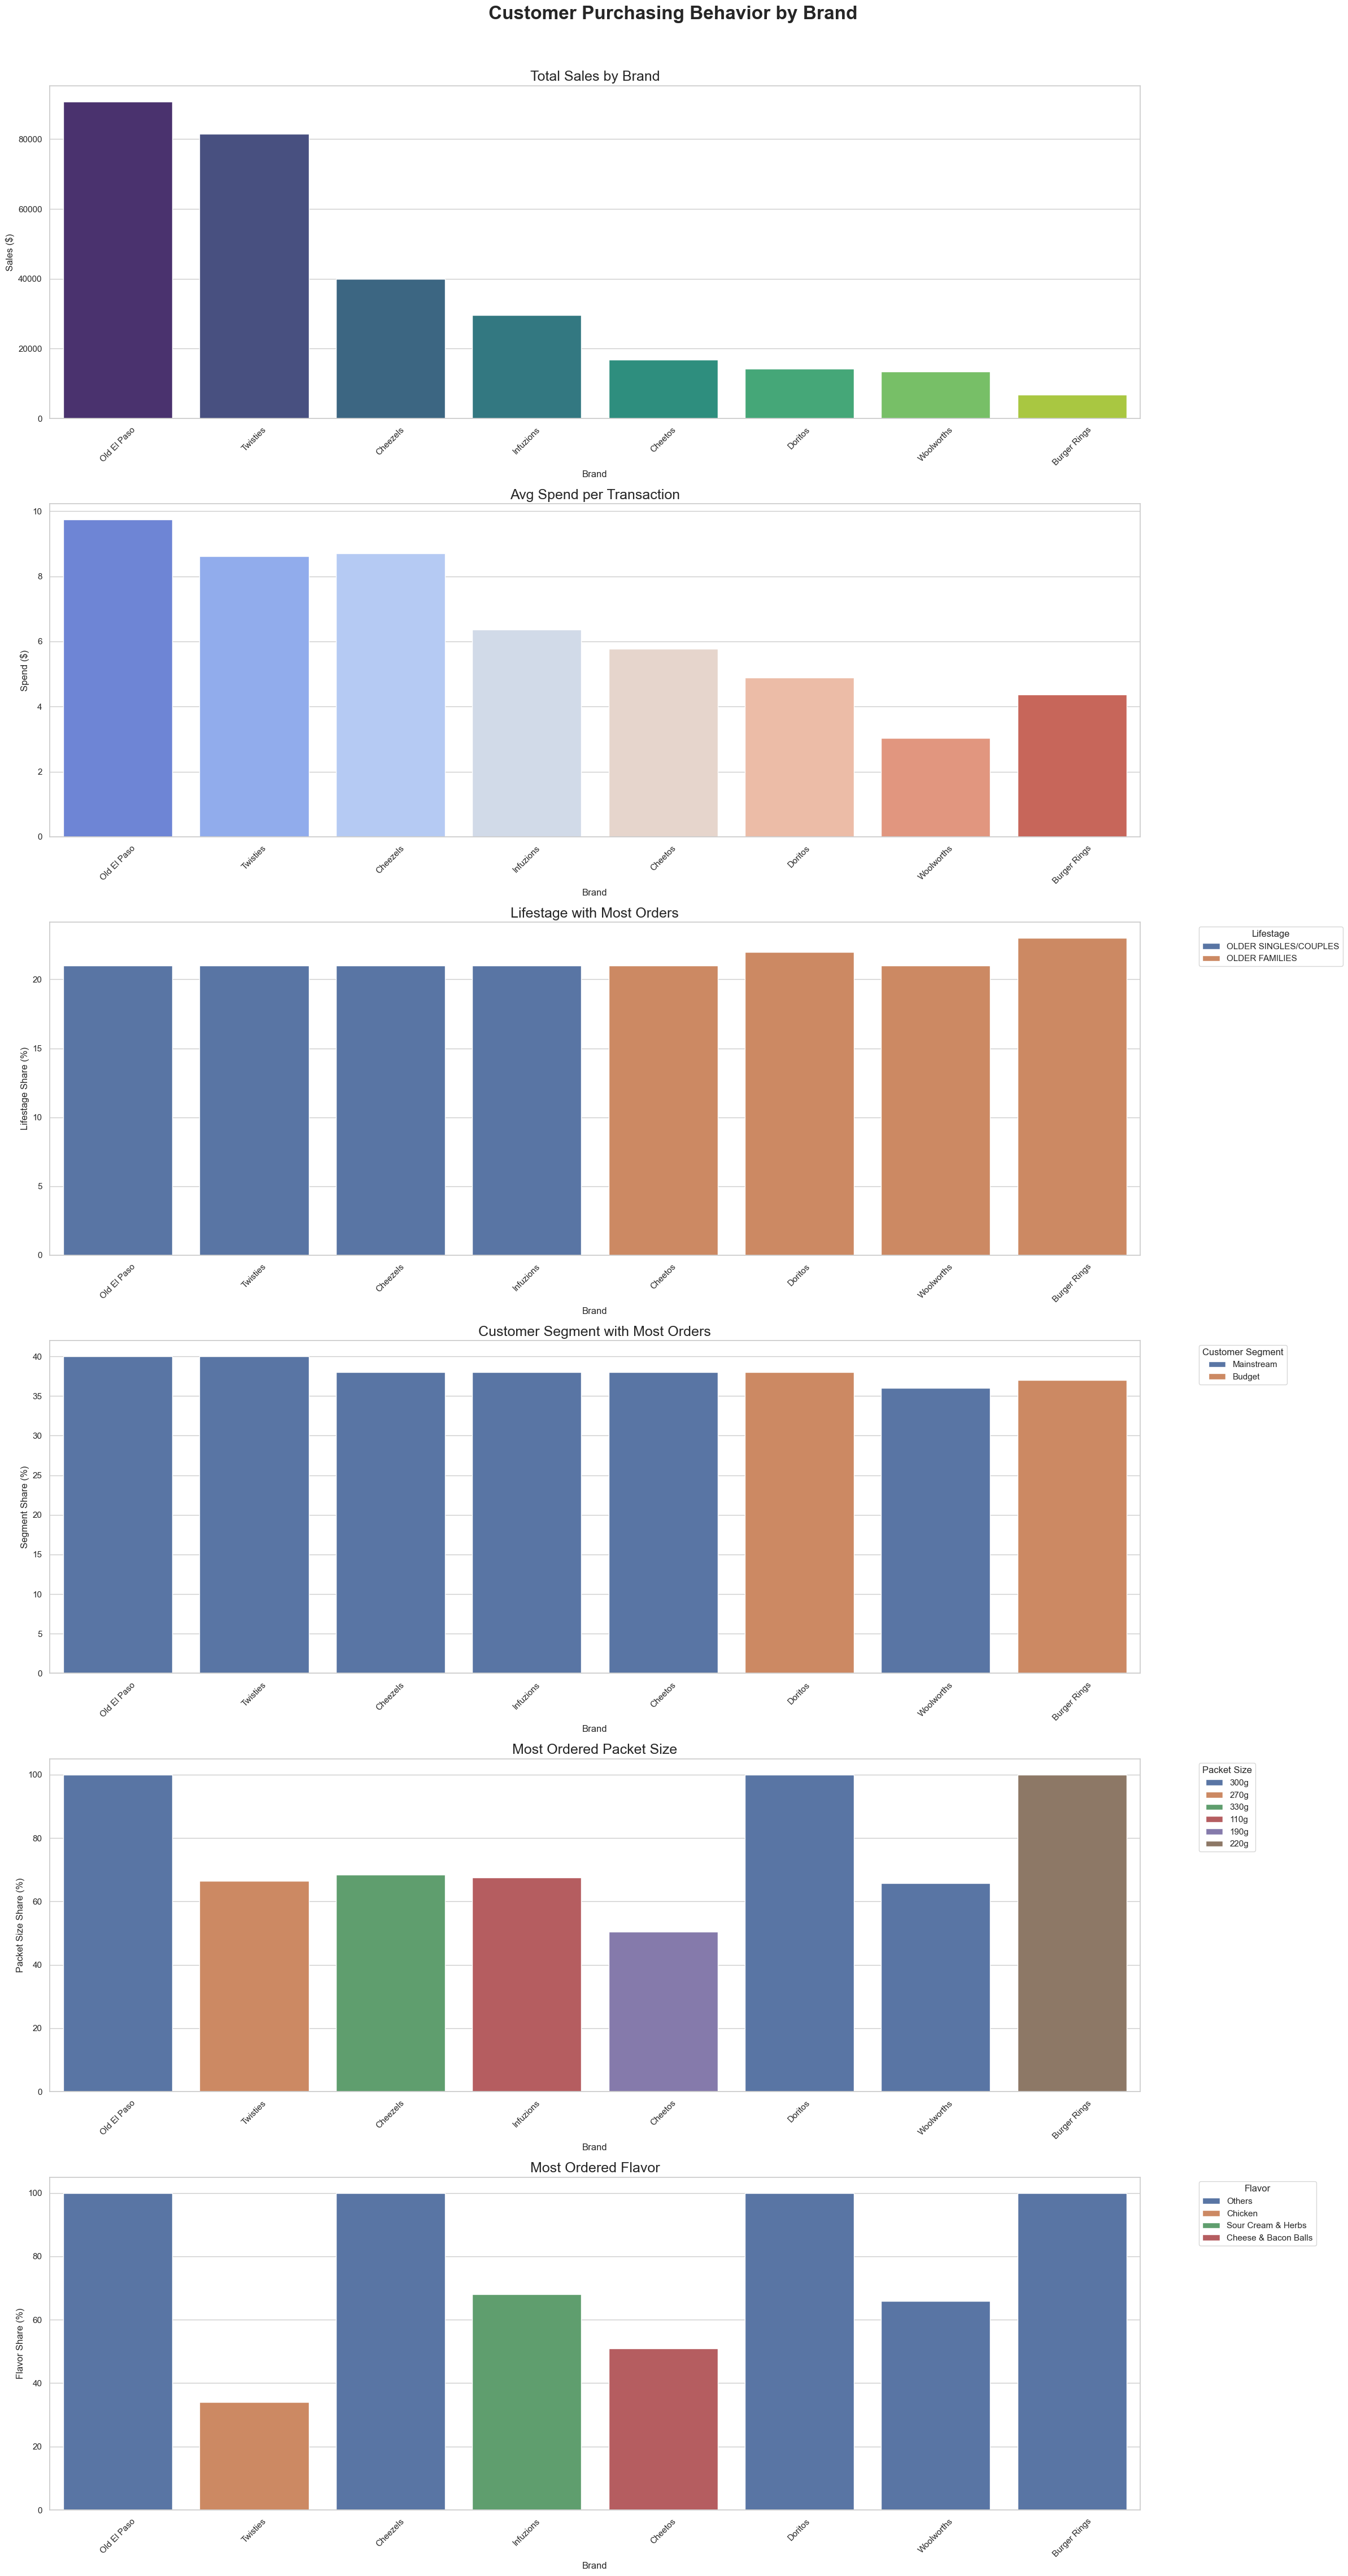

In [106]:
customer_behavior_dashboard(other_products_summary)

## Purchasing Behaviour - Key Observations & Commercial Recommendations

### **_Key Observations_**:
- *_Kettle, Doritos, Smiths, and Pringles are **_top performers_** — they lead in sales, transactions, and customer interest both overall and during the holiday season._*
- *_Retirees, Older Families, and Older Singles/Couples are our **_most engaged customers_** — retirees drive Christmas demand, while the others contribute year-round._*
- _Mainstream customers dominate, making up over **_40% of chip purchases_**. **_Budget shoppers_** also show strong interest, especially for **_Pringles during December_**._
- _Cheese Supreme (Doritos), Original (Smiths), Camembert & Fig (Kettle), and Sweet & Spicy BBQ (Pringles) are the **_go-to flavors across brands_** — some classic, some seasonal hits._
- _One in four customers picked the **_175g pack — that's 66k transactions_**. The best-selling sizes: 175g (Kettle, Smiths, Thins), 170g (Doritos), and 134g (Pringles)._
- _Sales peaked during **_Christmas week 2018_**, with ~750 transactions per day on average — a clear seasonal sales spike to target again._
---
### **_Commercial Recommendations:_**
- *_Put your **_best-selling brands — Kettle, Doritos, Smiths, and Pringles_** — front and center. Highlight them in all campaigns, give them premium shelf spots, and bundle them in holiday deals._*
- _Start holiday **_promotions early for retirees_**. For older families & older singles/couples, run everyday snack offers all year through flyers, loyalty rewards, or digital deals._
- _Reach budget families & mainstream young shoppers with **_value-first offers_**. Use smart promos like **_loyalty points, multipacks, or “buy again” rewards_** to boost repeat purchases._
- _Create $9.99 chip bundles for Christmas 2019. Pack your most popular brands (best selling flavours) with dips or drinks._
- *_Stick to what works: 170g–175g packs (and 134g for Pringles). Keep these sizes fully stocked and avoid cluttering shelves with smaller, low-turnover packs._*

# Uplift Testing

## Trial Stores

In [107]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['Month_Year'] = df['DATE'].dt.to_period('M').astype(str)

In [108]:
trial_stores_lst = ['77', '86','88']
trial_stores = df[df['STORE_NBR'].isin(trial_stores_lst)]
trial_stores.shape

(3974, 19)

### Monthly Sales

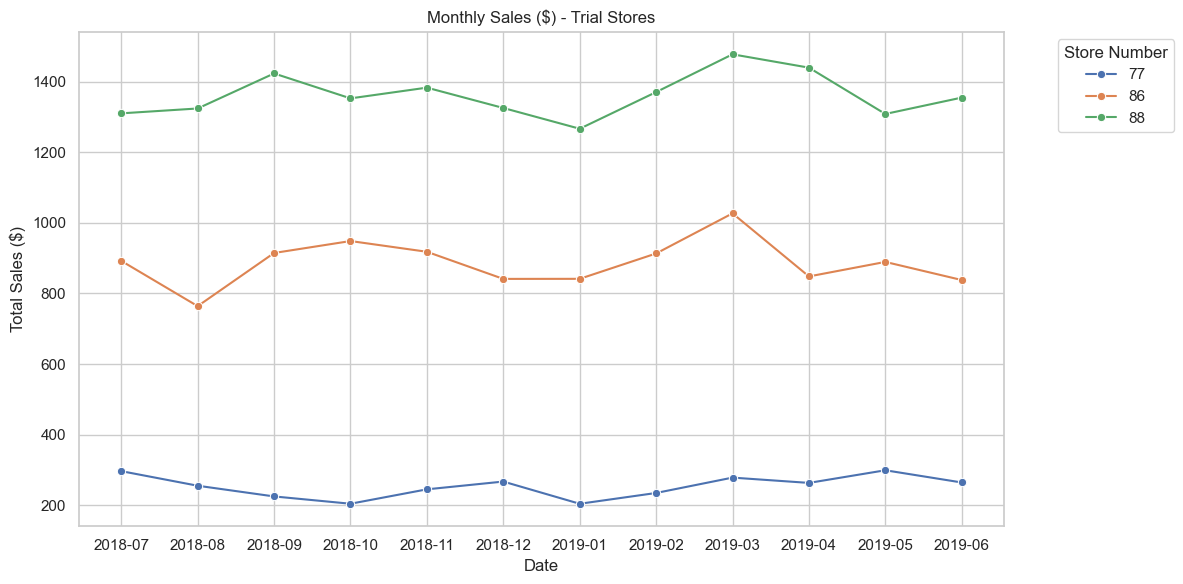

In [109]:
line_chart_groupby(trial_stores, 'Month_Year', 'TOT_SALES', 'sum', 'STORE_NBR',"Monthly Sales ($) - Trial Stores", 'Date', 'Total Sales ($)', 'o',"Store Number")

### Monthly Customers

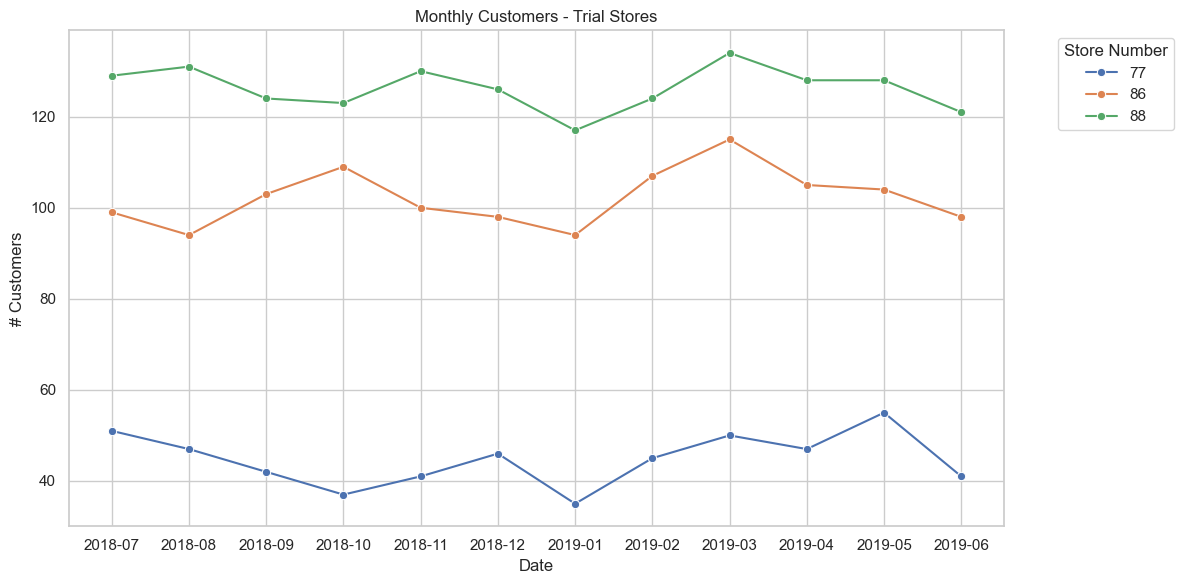

In [110]:
line_chart_groupby(trial_stores, 'Month_Year', 'LYLTY_CARD_NBR', 'nunique', 'STORE_NBR',"Monthly Customers - Trial Stores", 'Date', '# Customers', 'o',"Store Number")

### Monthly Transactions

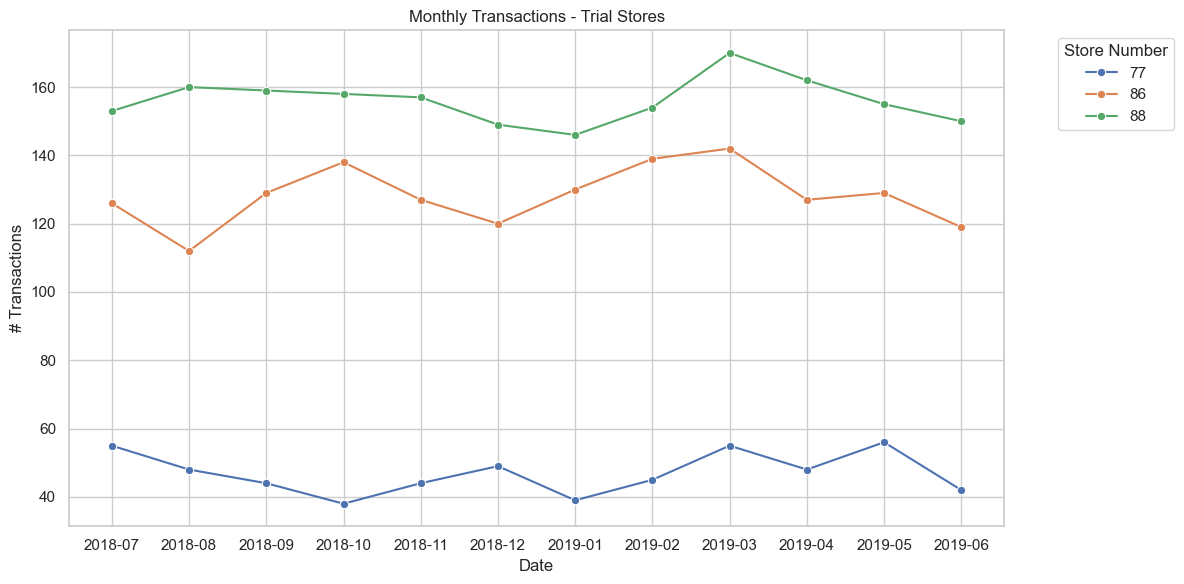

In [111]:
line_chart_groupby(trial_stores, 'Month_Year', 'count', 'count', 'STORE_NBR',"Monthly Transactions - Trial Stores", 'Date', '# Transactions', 'o',"Store Number")

## Control Stores Selection

In [112]:
# Include stores where sales happened every month

total_months = df['Month_Year'].nunique()

store_month_sales = df.groupby(['STORE_NBR', 'Month_Year'])['TOT_SALES'].sum().reset_index()

store_month_sales = store_month_sales[store_month_sales['TOT_SALES'] > 0]

months_per_store = store_month_sales.groupby('STORE_NBR')['Month_Year'].nunique().reset_index()
stores_all_months = months_per_store[months_per_store['Month_Year'] == total_months]['STORE_NBR'].tolist()

filtered_df = df[df['STORE_NBR'].isin(stores_all_months)]
filtered_df.shape

(264644, 19)

In [113]:
filtered_df['DATE'].min()

Timestamp('2018-07-01 00:00:00')

In [114]:
# df - before trial period
filtered_df= filtered_df[(filtered_df['DATE']>='2018-07-01') & (filtered_df['DATE']<'2019-02-01')]
filtered_df.shape

(155733, 19)

In [115]:
# Group by store number
control_stores_sales = filtered_df.groupby(['STORE_NBR'])['TOT_SALES'].sum().reset_index(name='Total Sales')
control_stores_customers = filtered_df.groupby(['STORE_NBR'])['LYLTY_CARD_NBR'].nunique().reset_index(name='Customers')
control_stores_transactions = filtered_df.groupby(['STORE_NBR']).size().reset_index(name='Transactions')
control_stores = (control_stores_sales.merge(control_stores_customers, on='STORE_NBR', how='inner')).merge(control_stores_transactions, on='STORE_NBR', how='inner')
control_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   STORE_NBR     260 non-null    object 
 1   Total Sales   260 non-null    float64
 2   Customers     260 non-null    int64  
 3   Transactions  260 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 8.2+ KB


In [116]:
# Transaction size
control_stores['Transaction Size (Avg)'] = control_stores['Total Sales'] / (control_stores['Transactions'])
control_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   STORE_NBR               260 non-null    object 
 1   Total Sales             260 non-null    float64
 2   Customers               260 non-null    int64  
 3   Transactions            260 non-null    int64  
 4   Transaction Size (Avg)  260 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 10.3+ KB


In [117]:
# Normalized Performance Score
control_stores['Z-score_Total_Sales']=(control_stores['Total Sales']-control_stores['Total Sales'].mean())/control_stores['Total Sales'].std()
control_stores['Z-score_customer']=(control_stores['Customers']-control_stores['Customers'].mean())/control_stores['Customers'].std()
control_stores['Z-score_Transactions']=(control_stores['Transactions']-control_stores['Transactions'].mean())/control_stores['Transactions'].std()
control_stores['Z-score_Transaction_size']=(control_stores['Transaction Size (Avg)']-control_stores['Transaction Size (Avg)'].mean())/control_stores['Transaction Size (Avg)'].std()

control_stores['NPS'] = control_stores['Z-score_Total_Sales'] + control_stores['Z-score_customer'] + control_stores['Z-score_Transactions'] + control_stores['Z-score_Transaction_size']

In [118]:
trial_stores_nps = control_stores[control_stores['STORE_NBR'].isin(trial_stores_lst)]
trial_stores_nps.head()

STORE_NBR  Total Sales  Customers  Transactions  Transaction Size (Avg)  \
237        77      1699.00        239           317                5.359621   
246        86      6119.85        254           882                6.938605   
248        88      9383.60        374          1082                8.672458   

     Z-score_Total_Sales  Z-score_customer  Z-score_Transactions  \
237            -0.997380          0.043100             -0.851309   
246             0.647995          0.239239              0.854490   
248             1.862715          1.808353              1.458313   

     Z-score_Transaction_size       NPS  
237                 -1.051954 -2.857542  
246                  0.003442  1.745167  
248                  1.162352  6.291732

In [119]:
# Control Store for 77 -> Store 233
control_store_77 = control_stores[(control_stores['NPS']>-2.9) &(control_stores['NPS']<-2.80)]
control_store_77.head()

STORE_NBR  Total Sales  Customers  Transactions  Transaction Size (Avg)  \
143       233       1659.8        240           311                5.336977   
237        77       1699.0        239           317                5.359621   

     Z-score_Total_Sales  Z-score_customer  Z-score_Transactions  \
143             -1.01197          0.056176             -0.869423   
237             -0.99738          0.043100             -0.851309   

     Z-score_Transaction_size       NPS  
143                 -1.067089 -2.892306  
237                 -1.051954 -2.857542

In [120]:
# Control Store for 86 -> Store 138
control_store_86 = control_stores[(control_stores['NPS']>1.744) &(control_stores['NPS']<1.746)]
control_store_86.head()

STORE_NBR  Total Sales  Customers  Transactions  Transaction Size (Avg)  \
41        138      6323.00        242           915                6.910383   
246        86      6119.85        254           882                6.938605   

     Z-score_Total_Sales  Z-score_customer  Z-score_Transactions  \
41              0.723604          0.082328              0.954121   
246             0.647995          0.239239              0.854490   

     Z-score_Transaction_size       NPS  
41                  -0.015422  1.744631  
246                  0.003442  1.745167

In [121]:
# Control Store for 88 -> Store 237
control_store_88 = control_stores[(control_stores['NPS']>6.10)]
control_store_88.head()

STORE_NBR  Total Sales  Customers  Transactions  Transaction Size (Avg)  \
71        165      9237.80        365          1048                8.814695   
135       226     10239.15        363          1182                8.662563   
147       237      9369.00        361          1073                8.731594   
217        58      9178.75        370          1054                8.708491   
248        88      9383.60        374          1082                8.672458   

     Z-score_Total_Sales  Z-score_customer  Z-score_Transactions  \
71              1.808450          1.690669              1.355663   
135             2.181138          1.664517              1.760224   
147             1.857281          1.638366              1.431141   
217             1.786472          1.756049              1.373778   
248             1.862715          1.808353              1.458313   

     Z-score_Transaction_size       NPS  
71                   1.257423  6.112205  
135                  1.155738  6.761618  
147                  1.201878  6.128665  
217                  1.186437  6.102736  
248                  1.162352  6.291732

**_Selected Control stores for each trial store based on NPS_**:
- Store 233 for Store 77
- Store 138 for Store 86
- Store 237 for Store 88

## Trial Store & Control Store Comparison

## Store 77 & Store 233

In [122]:
store_77 = ['233','77']
trial_stores = df[df['STORE_NBR'].isin(store_77)]
trial_stores.shape

(1098, 19)

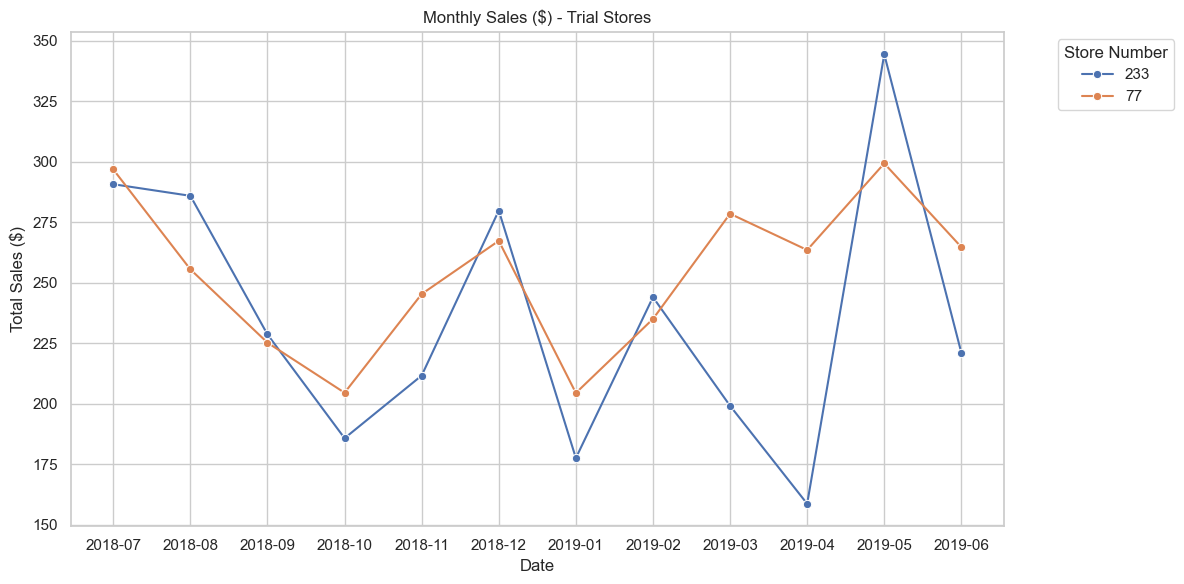

In [123]:
line_chart_groupby(trial_stores, 'Month_Year', 'TOT_SALES', 'sum', 'STORE_NBR',"Monthly Sales ($) - Trial Stores", 'Date', 'Total Sales ($)', 'o',"Store Number")

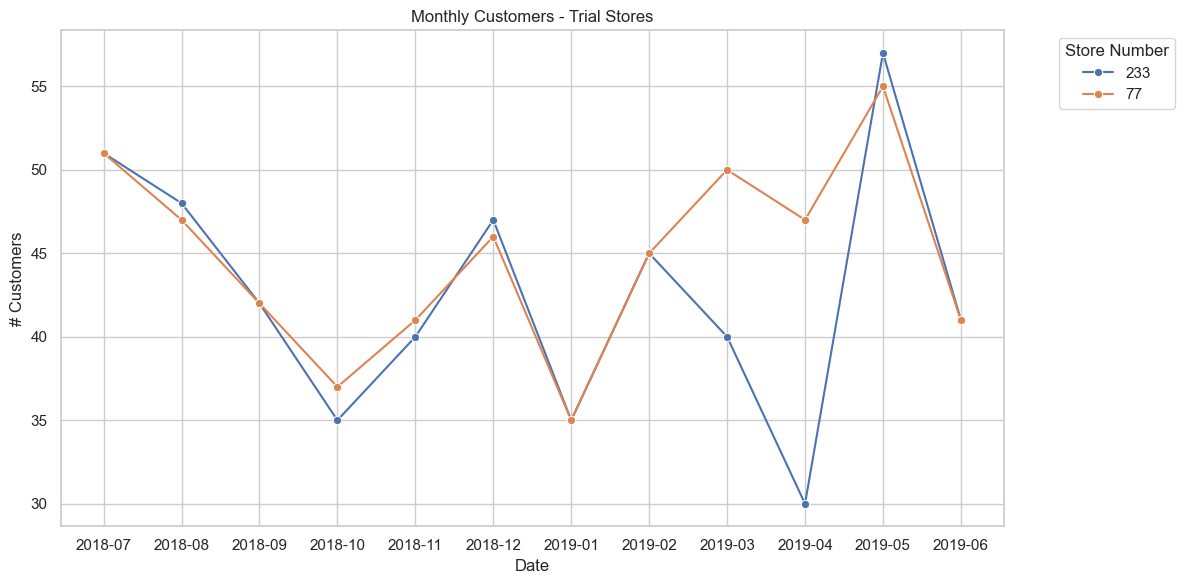

In [124]:
line_chart_groupby(trial_stores, 'Month_Year', 'LYLTY_CARD_NBR', 'nunique', 'STORE_NBR',"Monthly Customers - Trial Stores", 'Date', '# Customers', 'o',"Store Number")

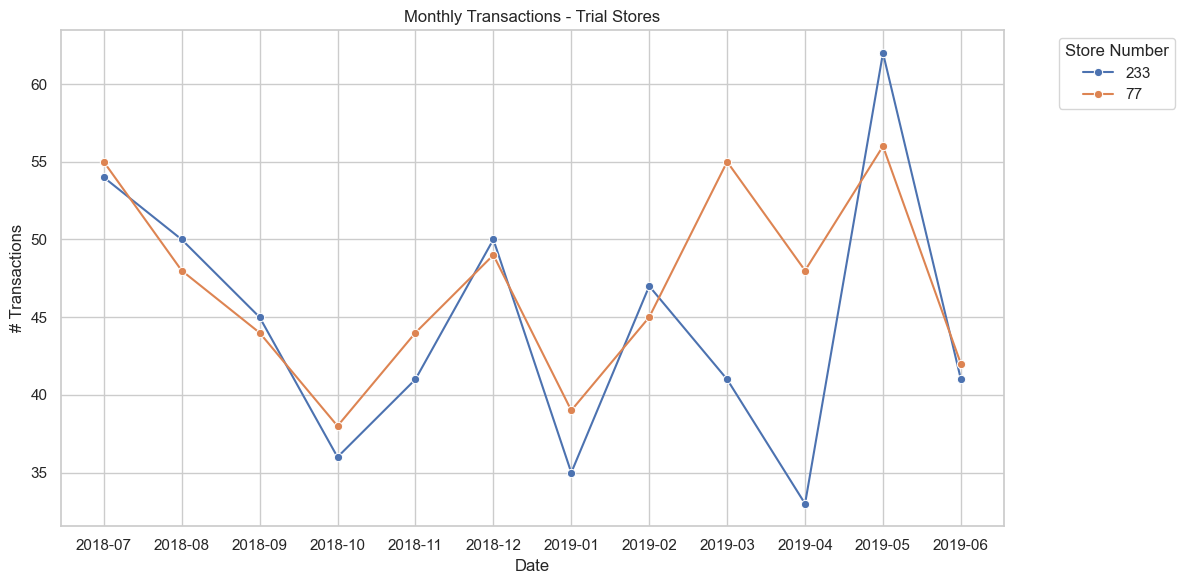

In [125]:
line_chart_groupby(trial_stores, 'Month_Year', 'count', 'count', 'STORE_NBR',"Monthly Transactions - Trial Stores", 'Date', '# Transactions', 'o',"Store Number")

## Store 86 & Store 138

In [126]:
store_86 = ['138','86']
trial_stores = df[df['STORE_NBR'].isin(store_86)]
trial_stores.shape

(3117, 19)

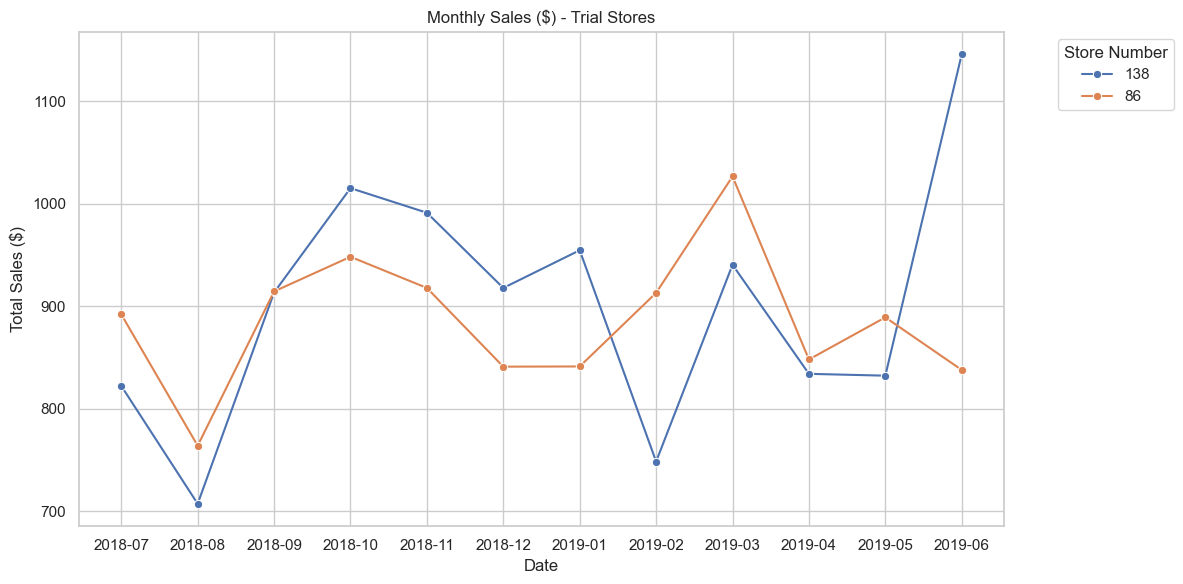

In [127]:
line_chart_groupby(trial_stores, 'Month_Year', 'TOT_SALES', 'sum', 'STORE_NBR',"Monthly Sales ($) - Trial Stores", 'Date', 'Total Sales ($)', 'o',"Store Number")

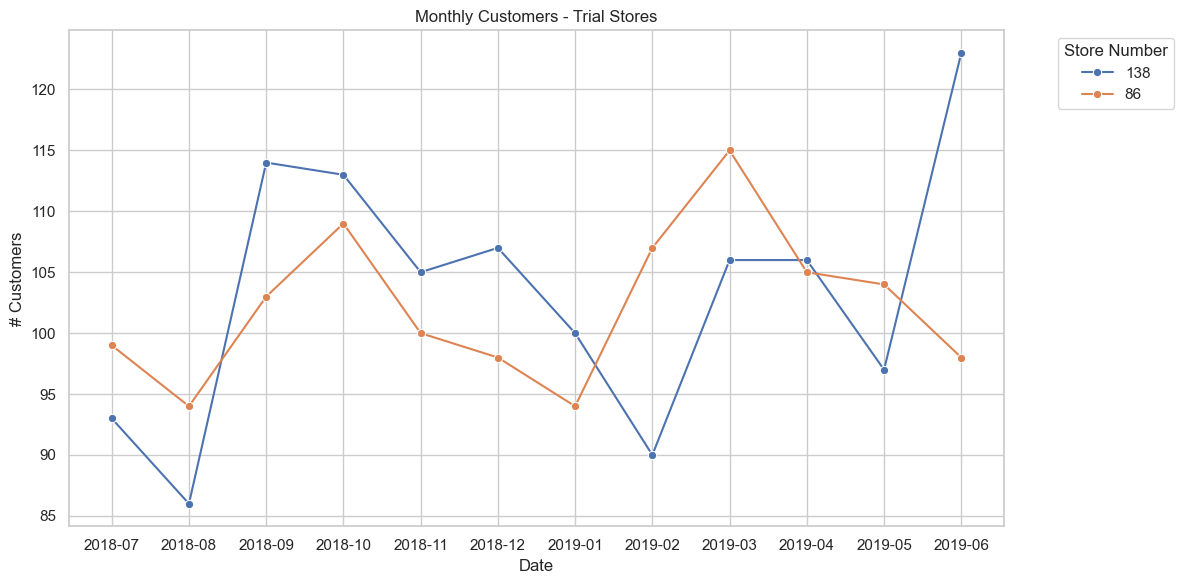

In [128]:
line_chart_groupby(trial_stores, 'Month_Year', 'LYLTY_CARD_NBR', 'nunique', 'STORE_NBR',"Monthly Customers - Trial Stores", 'Date', '# Customers', 'o',"Store Number")

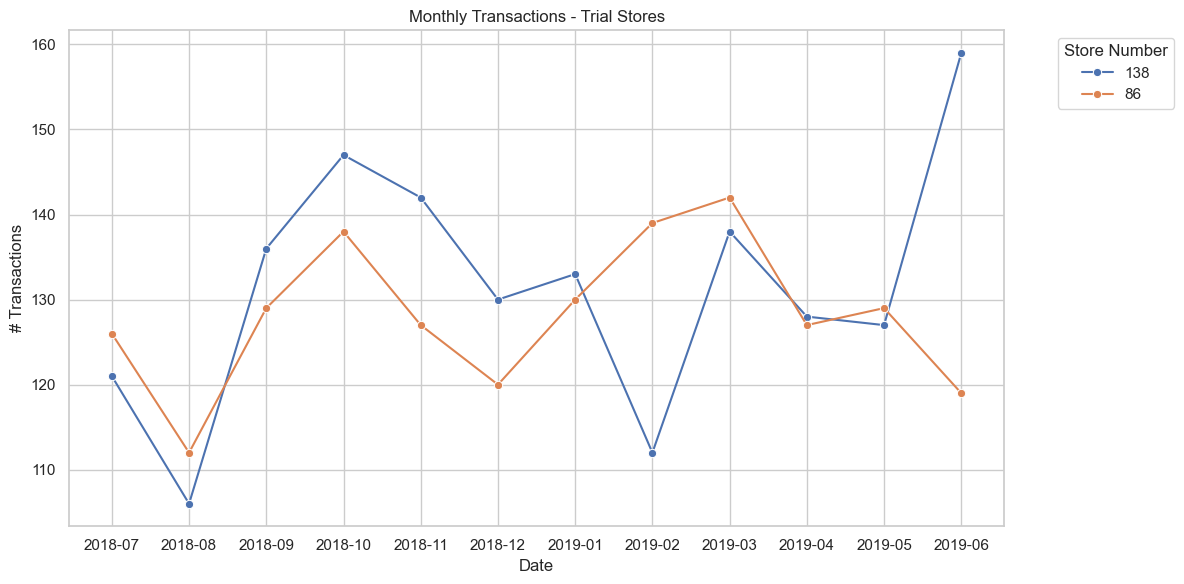

In [129]:
line_chart_groupby(trial_stores, 'Month_Year', 'count', 'count', 'STORE_NBR',"Monthly Transactions - Trial Stores", 'Date', '# Transactions', 'o',"Store Number")

## Store 88 & Store 237

In [130]:
store_88 = ['237','88']
trial_stores = df[df['STORE_NBR'].isin(store_88)]
trial_stores.shape

(3658, 19)

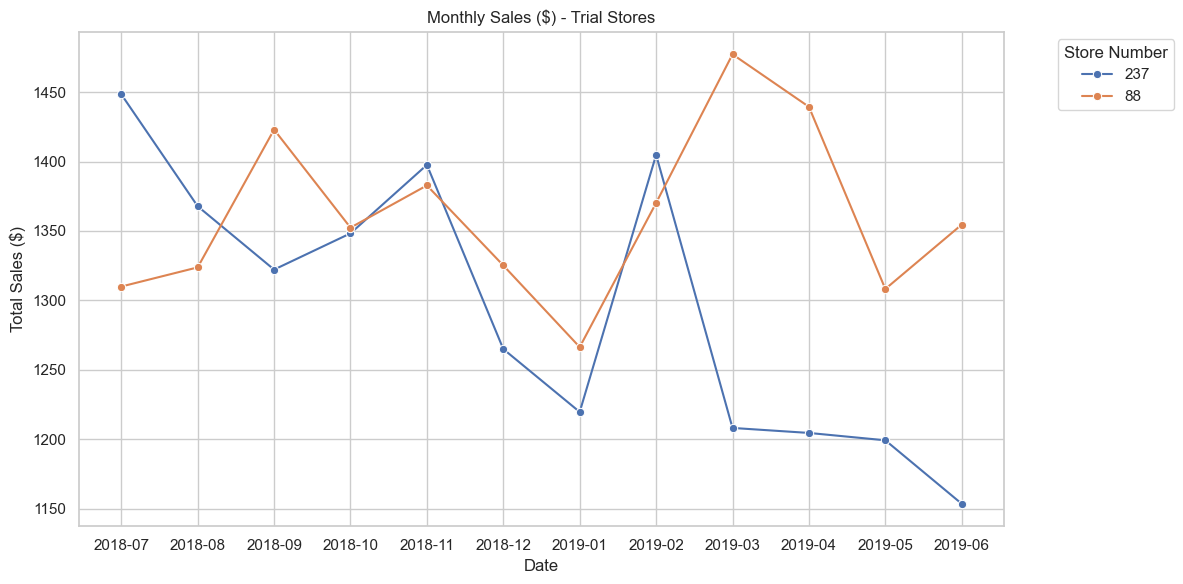

In [131]:
line_chart_groupby(trial_stores, 'Month_Year', 'TOT_SALES', 'sum', 'STORE_NBR',"Monthly Sales ($) - Trial Stores", 'Date', 'Total Sales ($)', 'o',"Store Number")

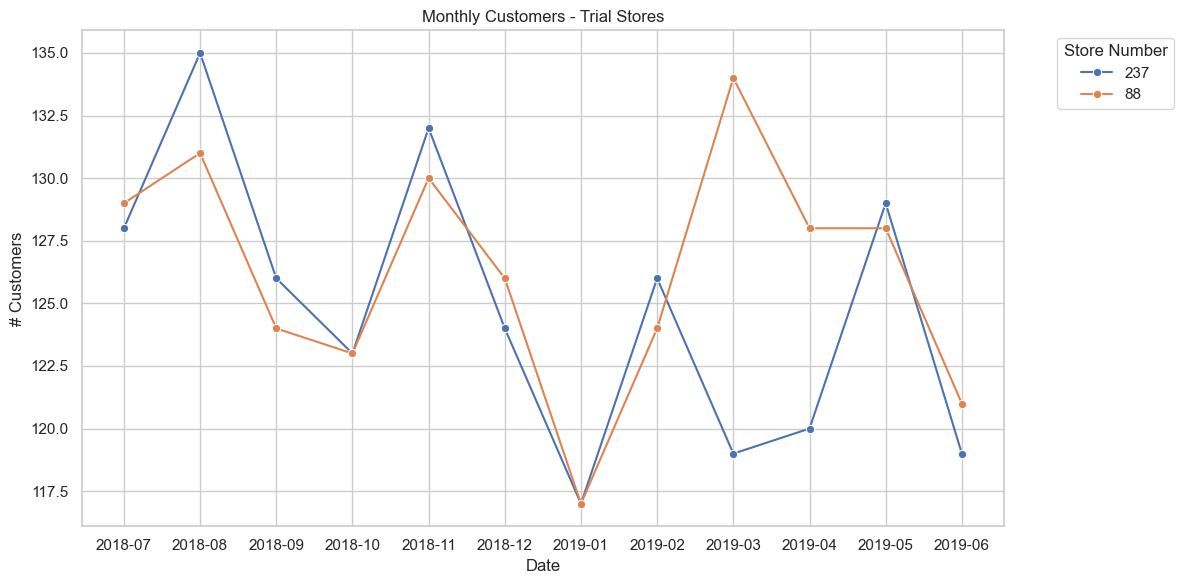

In [132]:
line_chart_groupby(trial_stores, 'Month_Year', 'LYLTY_CARD_NBR', 'nunique', 'STORE_NBR',"Monthly Customers - Trial Stores", 'Date', '# Customers', 'o',"Store Number")

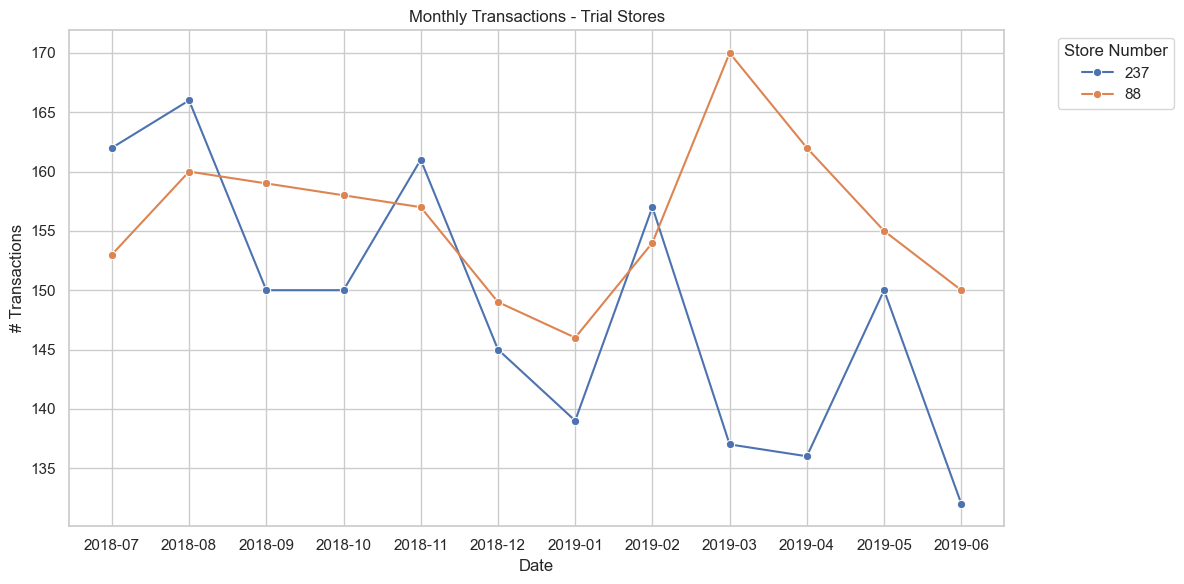

In [133]:
line_chart_groupby(trial_stores, 'Month_Year', 'count', 'count', 'STORE_NBR',"Monthly Transactions - Trial Stores", 'Date', '# Transactions', 'o',"Store Number")

## Uplift Testing - Key Observations & Recommendations

### **_Key Observations:_**
- **_Store 77_**: Sales went up during the trial period compared to control store 233. But after the trial, the trend started to flatten out.
- **_Store 86_**: The layout change didn’t make a difference during the trial, and after the trial, sales dropped sharply when compared to control store 138.
- **_Store 88_**: Sales saw a strong boost during the trial compared to control store 237 and post-trial, sales continue to rise sharply, outperforming the control store.
---
### **_Recommendations:_** 
- Continue with the new layout for Store 88 & 77.
- Discontinue/tweak the layout of Store 86 to boost the sales.